In [2]:
# Import libraries

import pandas as pd
import numpy as np
import math 
import rbo
import scipy.stats as stats
import sys
import seaborn as sns
from collections import Counter
import numpy as np

from scipy.special import binom
import ast


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

from scipy.stats import spearmanr
import pandas as pd
import numpy as np


from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from venn import venn
from supervenn import supervenn
import upsetplot
from upsetplot import plot

In [271]:
df = pd.read_csv('/Users/alejandroospina/Documents/GitHub/IR-analysis/woz.csv')

/Users/alejandroospina/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [270]:
# Group dataframe by 'qID' column and create lists of 'docID' and 'score' values
doc_lists = df.groupby('qID').apply(lambda x: x['docID'].tolist())
score_lists = df.groupby('qID').apply(lambda x: x['score'].tolist())

# Reset the index and create a new dataframe
doc_lists_df = pd.DataFrame({'qID': doc_lists.index, 'docList': doc_lists, 'scoreList': score_lists}).reset_index(drop=True)

# Split qID into userID and topicQuery columns
doc_lists_df['userID'] = doc_lists_df['qID'].str[:5]
doc_lists_df['topicQuery'] = doc_lists_df['qID'].str[6:]

# Reorder columns
doc_lists_df = doc_lists_df[['qID', 'userID', 'topicQuery', 'docList', 'scoreList']]

doc_lists_df = doc_lists_df.drop(doc_lists_df.tail(1).index)

doc_lists_df 

qID userID topicQuery  \
0    bot10-nigeria-1  bot10  nigeria-1   
1    bot10-nigeria-2  bot10  nigeria-2   
2    bot10-nigeria-3  bot10  nigeria-3   
3    bot10-nigeria-4  bot10  nigeria-4   
4    bot10-nigeria-5  bot10  nigeria-5   
..               ...    ...        ...   
187      bot25-son-4  bot25      son-4   
188      bot25-son-5  bot25      son-5   
189      bot25-son-6  bot25      son-6   
190      bot25-son-7  bot25      son-7   
191      bot25-son-8  bot25      son-8   

                                               docList  \
0    [MARCO_03_409842917, MARCO_39_1263326923, MARC...   
1    [MARCO_47_1423941107, MARCO_08_255818962, MARC...   
2    [MARCO_01_1640763612, MARCO_22_785597206, MARC...   
3    [MARCO_24_839235176, WAPO_f69812ca-7319-11e7-8...   
4    [MARCO_05_704734189, MARCO_01_675651323, MARCO...   
..                                                 ...   
187  [MARCO_14_80678852, MARCO_54_1237923414, MARCO...   
188  [MARCO_30_1673173299, MARCO_42_1085103767, MAR...   
189  [MARCO_46_375598997, MARCO_02_1859599770, MARC...   
190  [MARCO_30_516905549, MARCO_39_1088195602, MARC...   
191  [MARCO_37_192528847, MARCO_25_1844081788, MARC...   

                                             scoreList  
0    [18.54596519470215, 18.213645935058594, 17.773...  
1    [8.93653678894043, 8.898862838745117, 8.313402...  
2    [6.61665678024292, 6.591848850250244, 6.544945...  
3    [11.666037559509277, 11.413858413696289, 11.17...  
4    [11.791707038879395, 11.51059627532959, 11.111...  
..                                                 ...  
187  [8.500187873840332, 7.819100379943848, 7.81910...  
188  [12.409607887268066, 11.658930778503418, 11.04...  
189  [9.952284812927246, 9.931158065795898, 9.88665...  
190  [10.806255340576172, 10.748833656311035, 10.39...  
191  [6.227615833282471, 6.208806037902832, 6.16197...  

[192 rows x 5 columns]

## RBO (Rank-biased Overlap)

### RBO between the same topicQuery and among the different userID

In [280]:
## This is an specific exemple with topic_query = nigeria-1 and between the user bot23 and bo10

from rbo import rbo
from rbo import RankingSimilarity

# Define the depth parameter and the probability of stopping
depth_param = 10
p_param = 0.9

# Define the number of documents to consider in the list
num_docs_to_consider = 100

# Select the document lists for the two users and the topic query
user1 = 'bot21'
user2 = 'bot10'
topic_query = 'nigeria-1'

doc_list1 = doc_lists_df[(doc_lists_df['userID'] == user1) & (doc_lists_df['topicQuery'] == topic_query)]['docList'].iloc[0][:num_docs_to_consider]
doc_list2 = doc_lists_df[(doc_lists_df['userID'] == user2) & (doc_lists_df['topicQuery'] == topic_query)]['docList'].iloc[0][:num_docs_to_consider]

# Compute the RBO similarity between the two document lists
rbo_similarity = rbo.RankingSimilarity(doc_list1, doc_list2).rbo(k=depth_param, p=p_param)

print("The RBO similarity between the two document lists is:", rbo_similarity)




The RBO similarity between the two document lists is: 0.0


In [66]:
def compute_rbo_similarity(df, num_docs_to_consider, depth_param, p_param):
    # Get the unique query topics in the dataframe
    query_topics = df['topicQuery'].unique()

    # Iterate over the unique query topics
    for query_topic in query_topics:
        # Get the unique user IDs for the current query topic
        user_ids = df[df['topicQuery'] == query_topic]['userID'].unique()

        # Initialize an empty dictionary to store the RBO similarities for the current query topic
        rbo_topic_dict = {}

        # Iterate over the unique user IDs for the current query topic
        for i in range(len(user_ids)):
            for j in range(i+1, len(user_ids)):
                # Get the document lists for the current user IDs and query topic
                doc_list1 = df[(df['userID'] == user_ids[i]) & (df['topicQuery'] == query_topic)]['docList'].iloc[0][:num_docs_to_consider]
                doc_list2 = df[(df['userID'] == user_ids[j]) & (df['topicQuery'] == query_topic)]['docList'].iloc[0][:num_docs_to_consider]

                # Check if the document lists are not empty before computing the RBO similarity
                if len(doc_list1) == 0 or len(doc_list2) == 0:
                    print(f"Warning: Empty document list found for user IDs {user_ids[i]} and {user_ids[j]} in query topic {query_topic}. Skipping RBO similarity computation.")
                    continue

                # Compute the RBO similarity between the two document lists
                rbo_similarity = rbo.RankingSimilarity(doc_list1, doc_list2).rbo(k=depth_param, p=p_param)

                # Add the RBO similarity to the dictionary for the current query topic
                rbo_topic_dict[(user_ids[i], user_ids[j])] = rbo_similarity

        # Check if the dictionary for the current query topic is empty
        if not rbo_topic_dict:
            print(f"Warning: Empty RBO similarity matrix for query topic {query_topic}. Skipping.")
            continue

        # Convert the dictionary for the current query topic to a dataframe
        rbo_df = pd.DataFrame.from_dict(rbo_topic_dict, orient='index', columns=['RBO Similarity'])

        # Create a MultiIndex from the keys of the rbo_topic_dict dictionary
        index = pd.MultiIndex.from_tuples(rbo_topic_dict.keys())

        # Set the index of the dataframe to the MultiIndex
        rbo_df.index = index

        # Unstack the dataframe to get the RBO similarities in matrix form for the current query topic
        rbo_matrix = rbo_df['RBO Similarity'].unstack()

        # Print the RBO similarity matrix for the current query topic
        print(f"RBO Similarity Matrix for Query Topic: {query_topic}")
        print(rbo_matrix)



In [273]:
compute_rbo_similarity(doc_lists_df, num_docs_to_consider=100, depth_param=10, p_param=0.7)


RBO Similarity Matrix for Query Topic: nigeria-1
          bot12     bot13     bot15     bot16     bot17     bot18  bot23  \
bot10  0.262264  0.030929  0.030929  0.216929  0.085454  0.108797    0.0   
bot12       NaN  0.039332  0.039332  0.000000  0.247858  0.034072    0.0   
bot13       NaN       NaN  0.971752  0.000000  0.513797  0.019666    0.0   
bot15       NaN       NaN       NaN  0.000000  0.513797  0.019666    0.0   
bot16       NaN       NaN       NaN       NaN  0.059797  0.007431    0.0   
bot17       NaN       NaN       NaN       NaN       NaN  0.000000    0.0   
bot18       NaN       NaN       NaN       NaN       NaN       NaN    0.0   
bot23       NaN       NaN       NaN       NaN       NaN       NaN    NaN   

          bot24  
bot10  0.030929  
bot12  0.039332  
bot13  0.971752  
bot15  0.971752  
bot16  0.000000  
bot17  0.513797  
bot18  0.019666  
bot23  0.000000  
RBO Similarity Matrix for Query Topic: nigeria-2
       bot12  bot13  bot15  bot16  bot17  bot18  bot23 

RBO Similarity Matrix for Query Topic: nigeria-6
       bot13  bot15  bot17  bot24
bot12    0.0    0.0    0.0    0.0
bot13    NaN    0.0    0.0    0.0
bot15    NaN    NaN    0.0    0.0
bot17    NaN    NaN    NaN    0.0
RBO Similarity Matrix for Query Topic: nigeria-7
       bot13  bot15  bot24
bot12    0.0    0.0    0.0
bot13    NaN    0.0    0.0
bot15    NaN    NaN    0.0
RBO Similarity Matrix for Query Topic: nigeria-8
       bot13
bot12    0.0
RBO Similarity Matrix for Query Topic: son-1
          bot14     bot16     bot25
bot13  0.765463  0.971752  0.765463
bot14       NaN  0.765463  0.971752
bot16       NaN       NaN  0.765463
RBO Similarity Matrix for Query Topic: son-2
       bot14  bot16  bot25
bot13    0.0    0.0    0.0
bot14    NaN    0.0    0.0
bot16    NaN    NaN    0.0
RBO Similarity Matrix for Query Topic: son-3
       bot14  bot16  bot25
bot13    0.0    0.0    0.0
bot14    NaN    0.0    0.0
bot16    NaN    NaN    0.0
RBO Similarity Matrix for Query Topic: son-4
       bo

### Similarity score between the documents that each user has received for each conversation they have had. Example, similarity score analysis for bot10 between the documents that came up in query 1, query2, query3, query4, and so on

In [236]:
doc_lists_df['groupID'] = doc_lists_df['qID'].str[:-1]
grouped_df = doc_lists_df.groupby('groupID')


In [288]:
import pandas as pd
import numpy as np
from rbo import RankingSimilarity

# Define a function to calculate the RBO similarity matrix between document lists
def calculate_rbo(doc_lists, weight, depth, n_docs=100): ### choose here the number of doc to consider
    if n_docs is not None:
        # Truncate the lists to the specified number of documents
        doc_lists = [lst[:n_docs] for lst in doc_lists]
    
    n_lists = len(doc_lists)
    rbo_matrix = np.zeros((n_lists, n_lists))
    for i in range(n_lists):
        for j in range(i, n_lists):
            rbo_score = RankingSimilarity(doc_lists[i], doc_lists[j]).rbo(k=depth, p=weight)
            rbo_matrix[i, j] = rbo_score
            rbo_matrix[j, i] = rbo_score
    
    # Scale the scores to the range [0, 1]
    min_score = np.min(rbo_matrix)
    max_score = np.max(rbo_matrix)
    scaled_matrix = (rbo_matrix - min_score) / (max_score - min_score)
    np.fill_diagonal(scaled_matrix, 1)  # Set the diagonal elements to 1
    return scaled_matrix

# Group the dataframe by the first part of the qID
doc_lists_df['groupID'] = doc_lists_df['qID'].str[:-1]
grouped_df = doc_lists_df.groupby('groupID')

result = {}
for group_id, group_df in grouped_df:
    doc_lists = group_df['docList'].tolist()
    rbo_matrix = calculate_rbo(doc_lists, weight=0.9, depth=50)
    result[group_id] = pd.DataFrame(rbo_matrix, index=group_df['qID'], columns=group_df['qID'])

# Print the result
for group_id, scores_df in result.items():
    print(f"Group ID: {group_id}")
    print(scores_df)


Group ID: bot10-nigeria-
qID              bot10-nigeria-1  bot10-nigeria-2  bot10-nigeria-3  \
qID                                                                  
bot10-nigeria-1              1.0         0.000000         0.000000   
bot10-nigeria-2              0.0         1.000000         0.000068   
bot10-nigeria-3              0.0         0.000068         1.000000   
bot10-nigeria-4              0.0         0.000000         0.000000   
bot10-nigeria-5              0.0         0.000000         0.000000   

qID              bot10-nigeria-4  bot10-nigeria-5  
qID                                                
bot10-nigeria-1              0.0              0.0  
bot10-nigeria-2              0.0              0.0  
bot10-nigeria-3              0.0              0.0  
bot10-nigeria-4              1.0              0.0  
bot10-nigeria-5              0.0              1.0  
Group ID: bot10-running-
qID              bot10-running-1  bot10-running-2  bot10-running-3  \
qID                      

/var/folders/lf/j2xbv1mx32j03z068_2h63100000gn/T/ipykernel_1368/1525826687.py:22: RuntimeWarning: invalid value encountered in true_divide
  scaled_matrix = (rbo_matrix - min_score) / (max_score - min_score)


# Overlap  in documents

### Working with overlapping in documents (within the same user)

### Supervenn

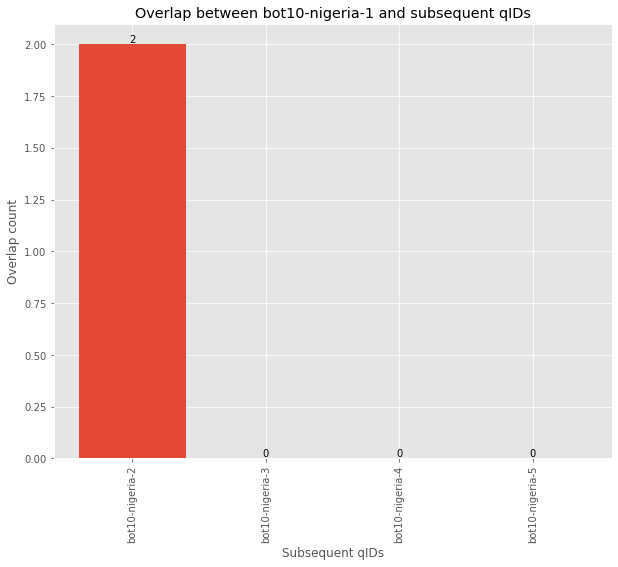

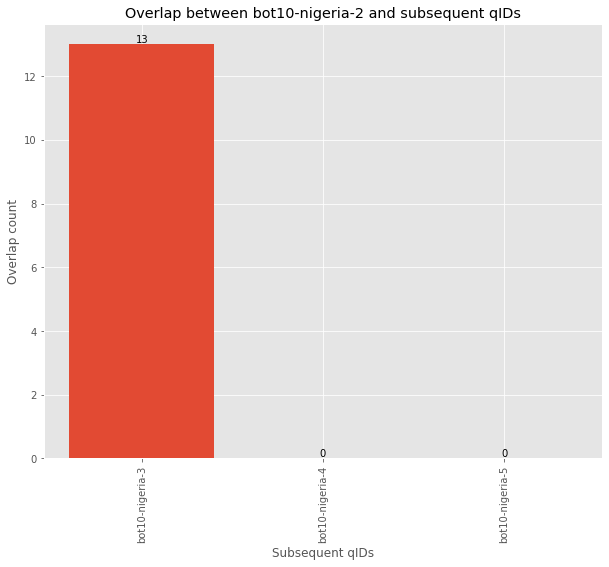

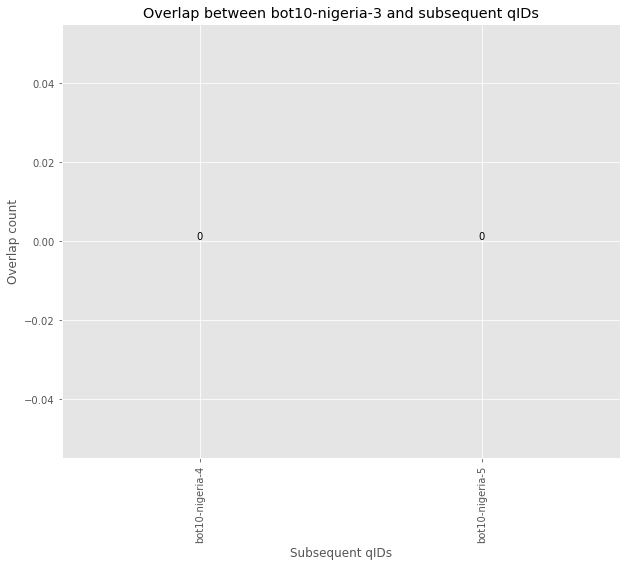

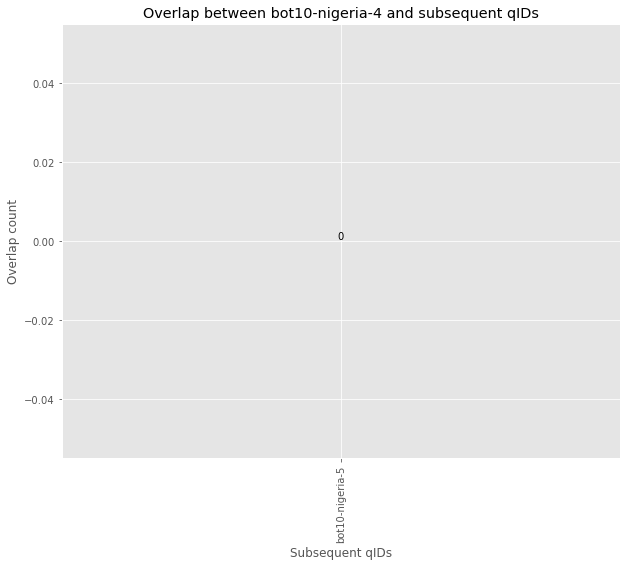

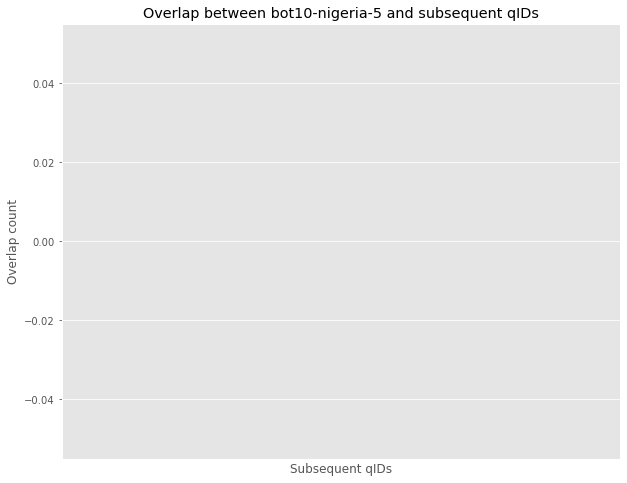

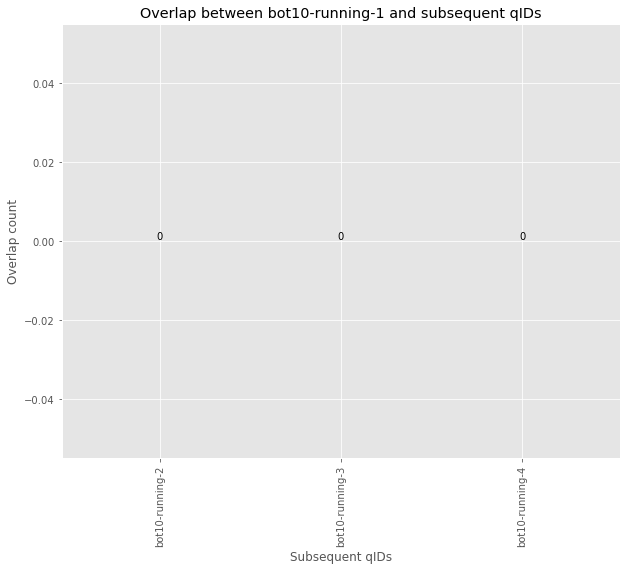

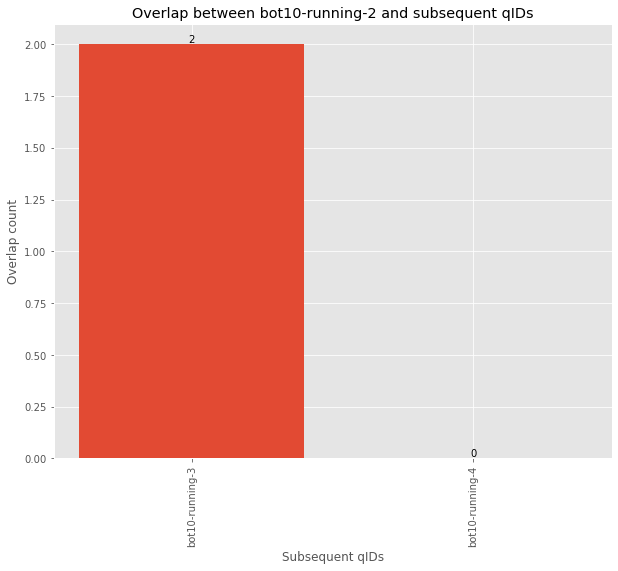

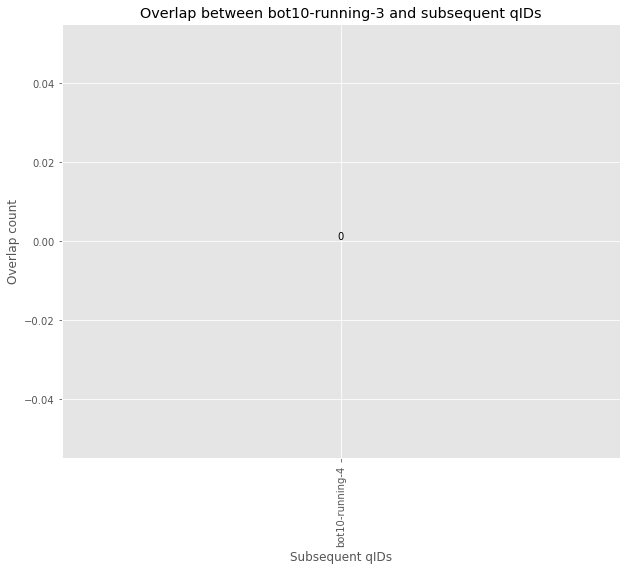

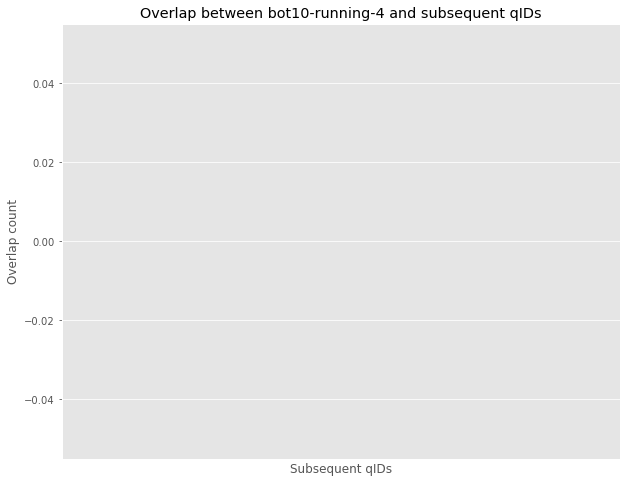

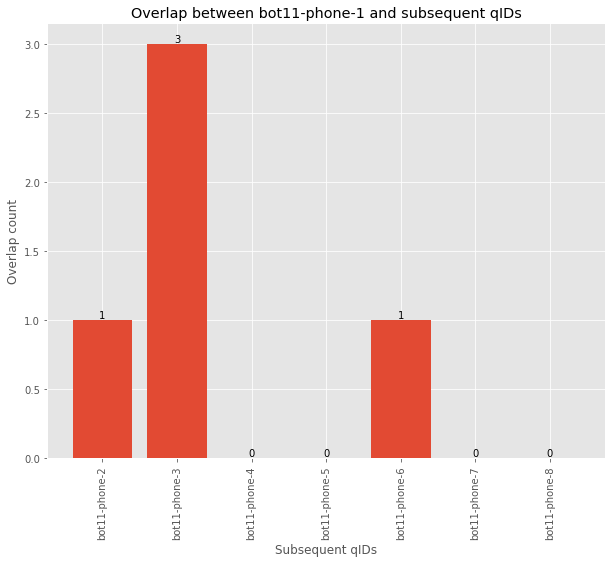

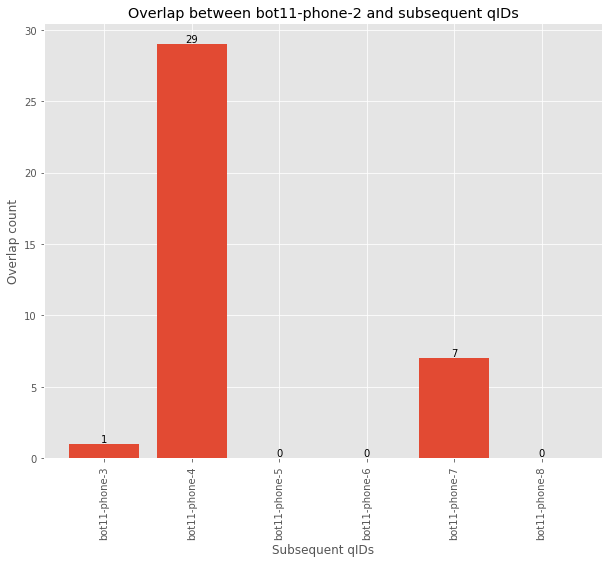

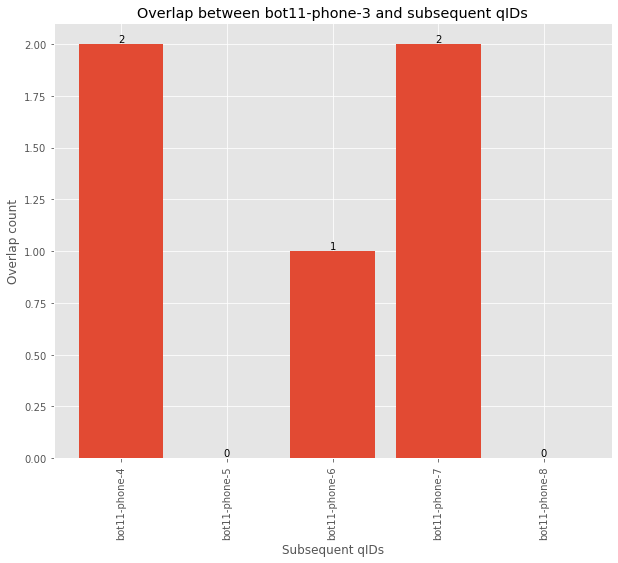

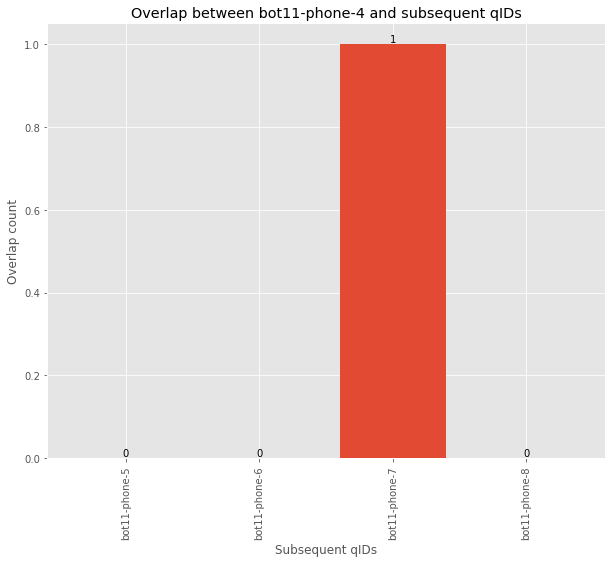

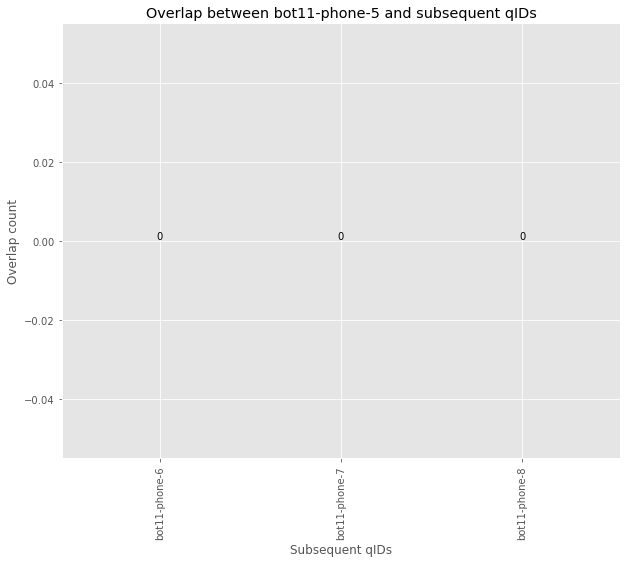

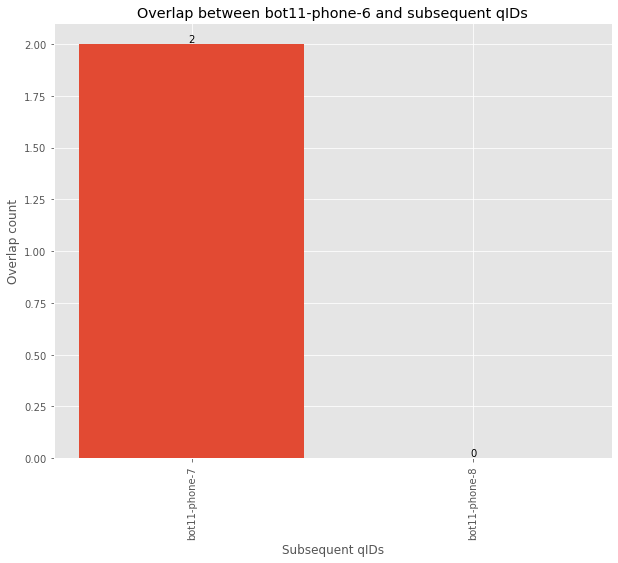

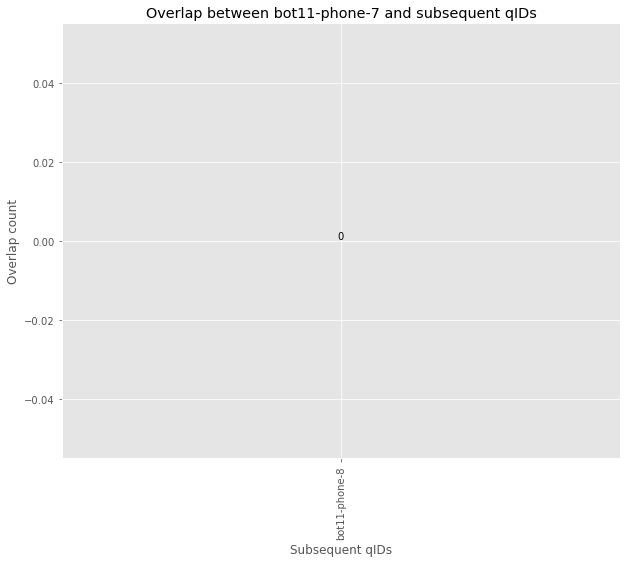

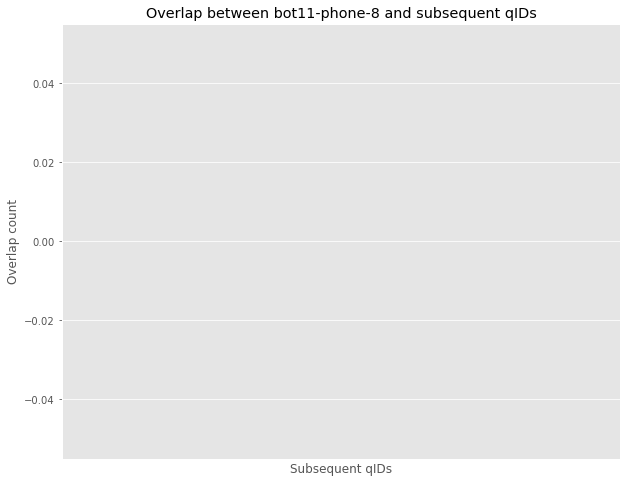

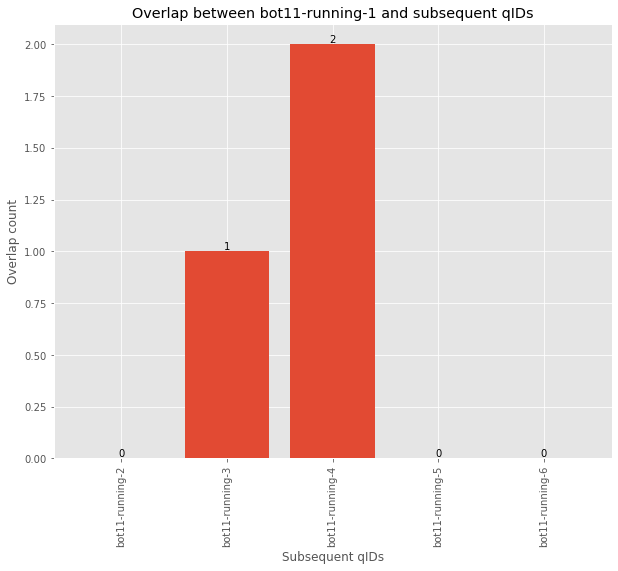

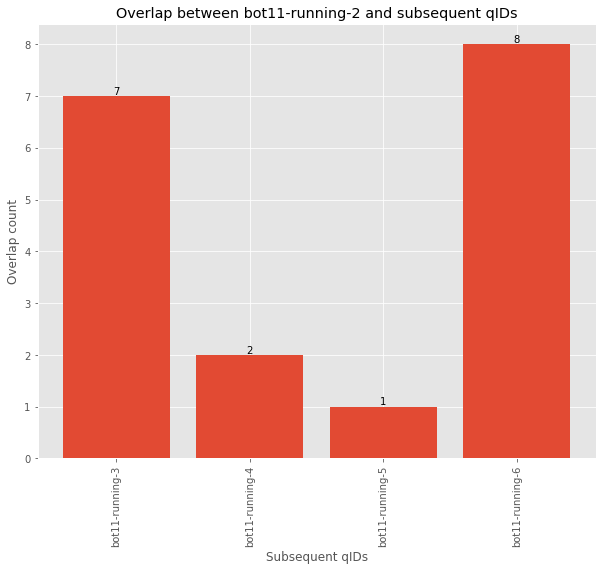

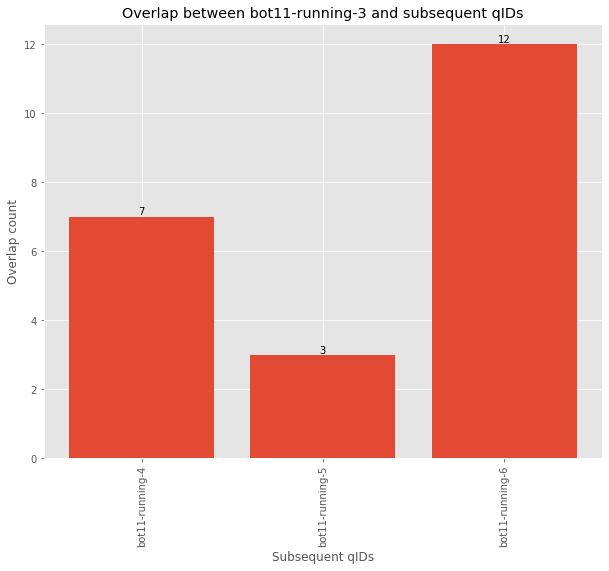

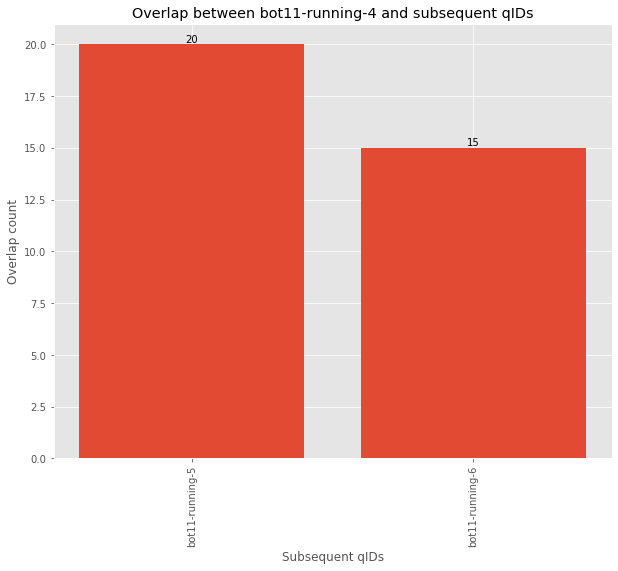

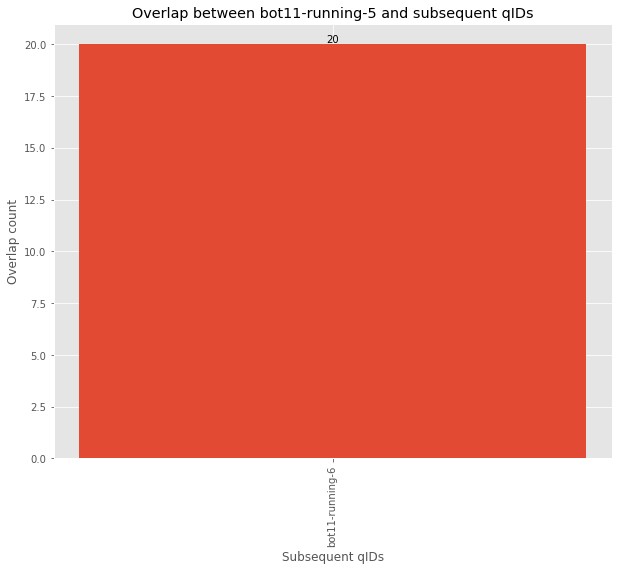

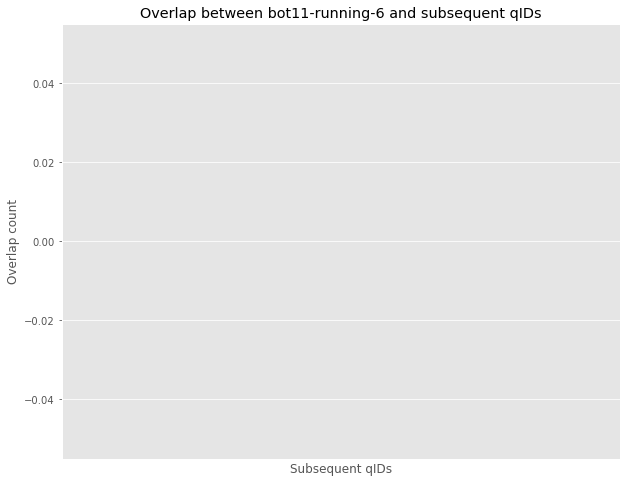

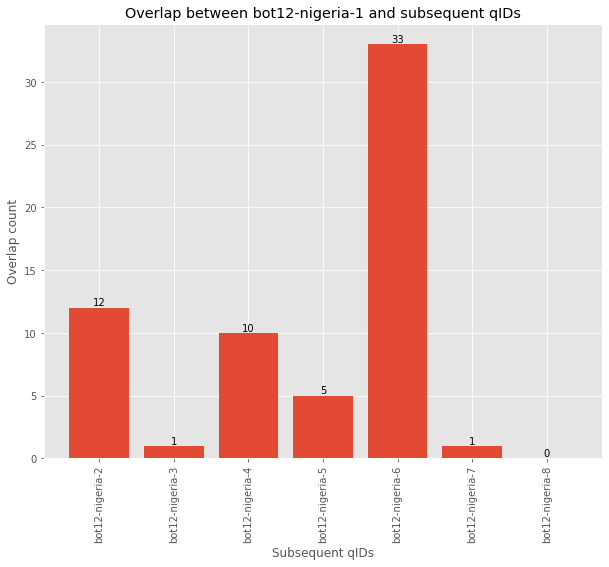

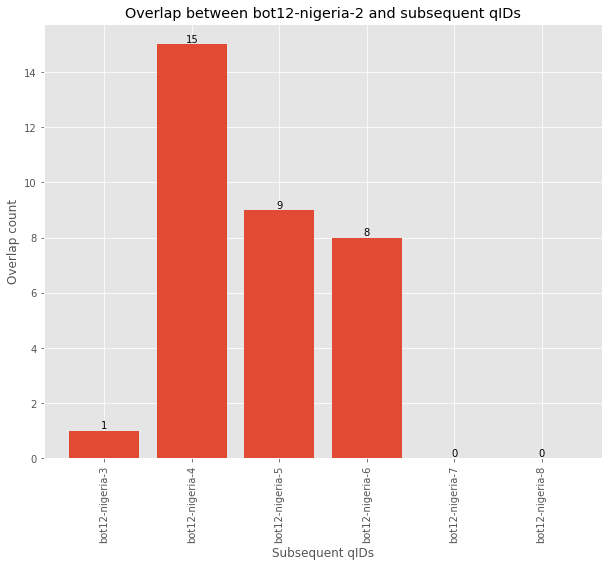

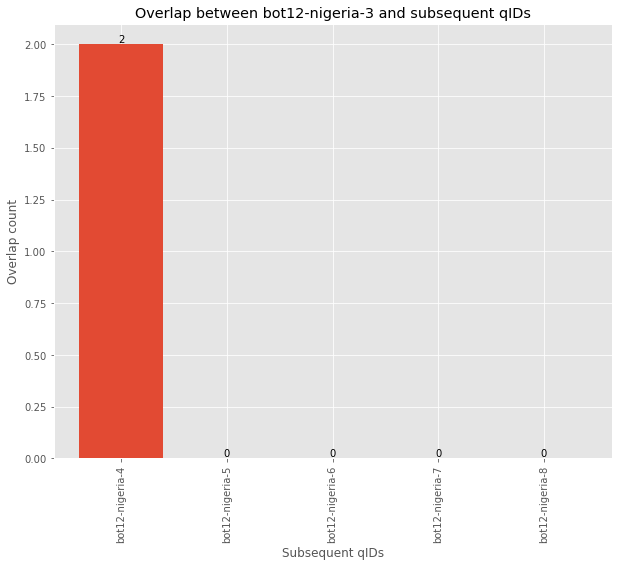

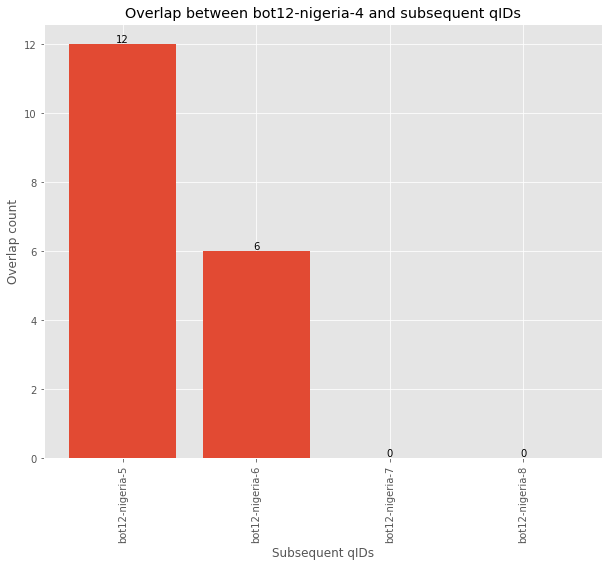

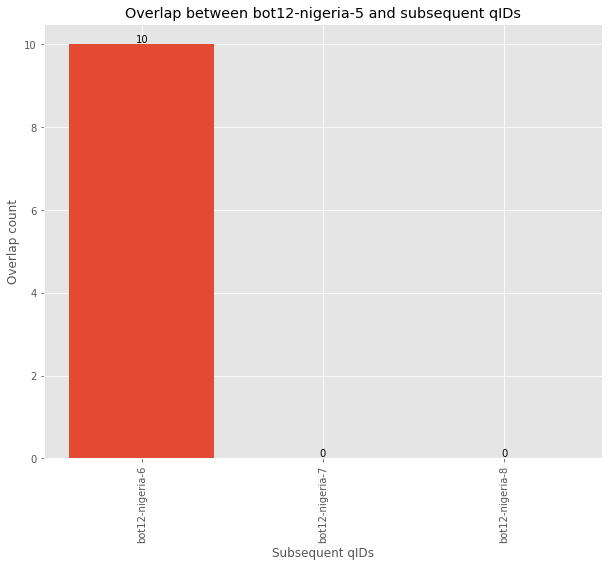

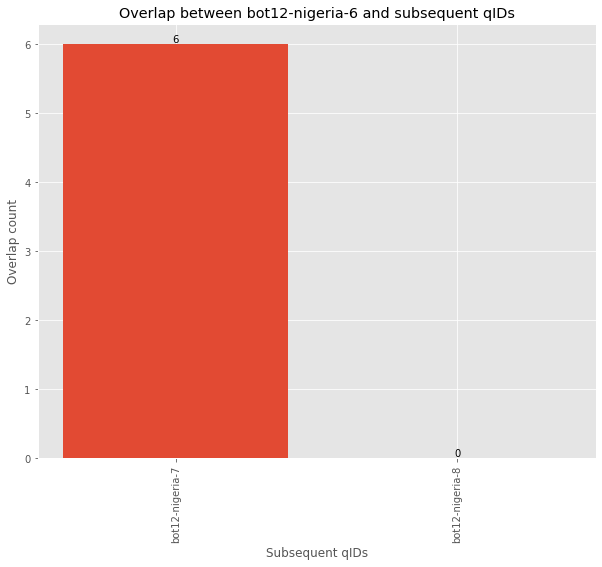

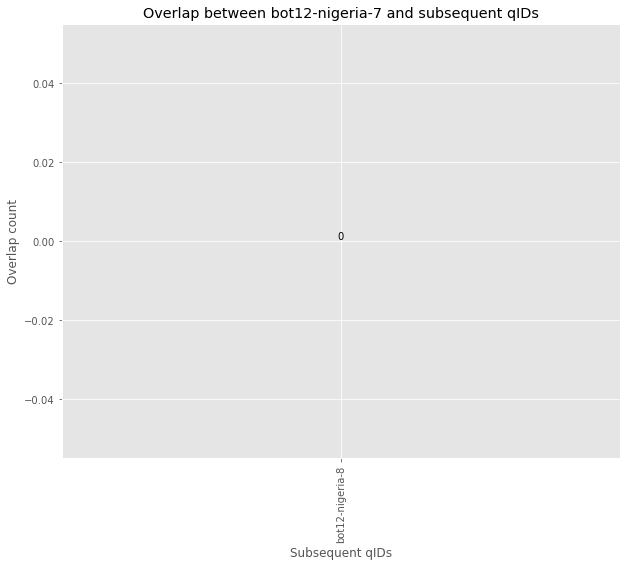

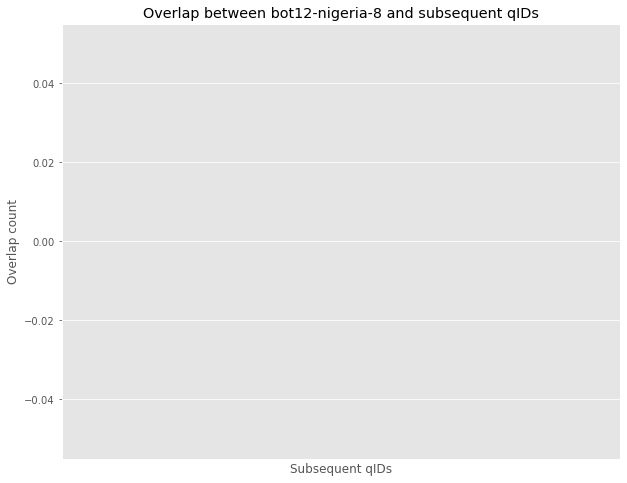

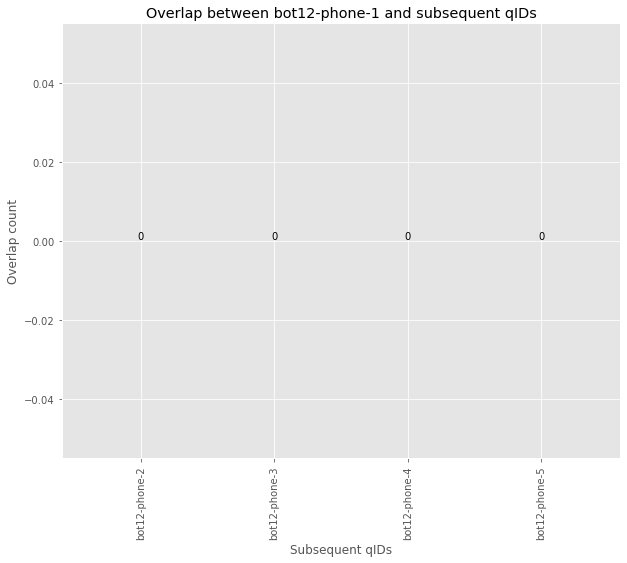

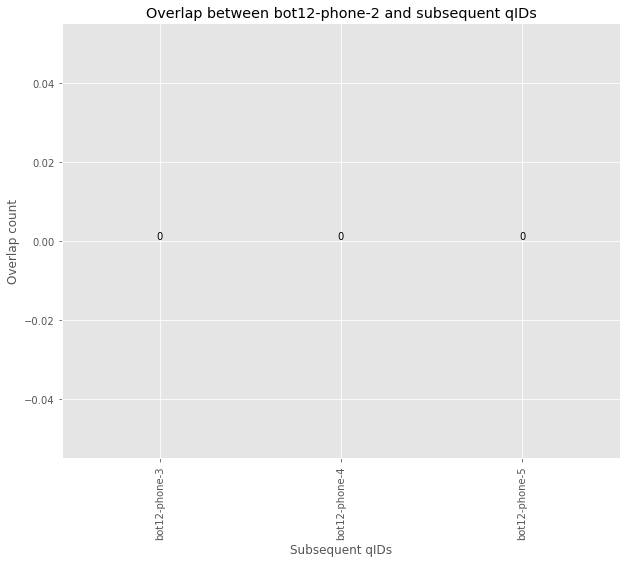

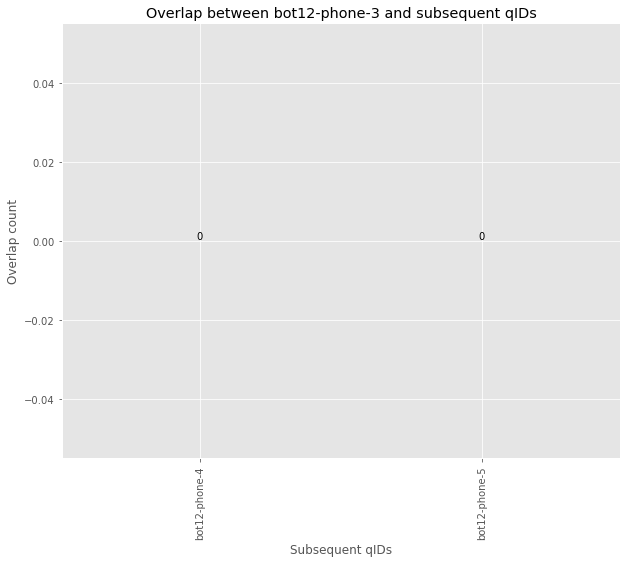

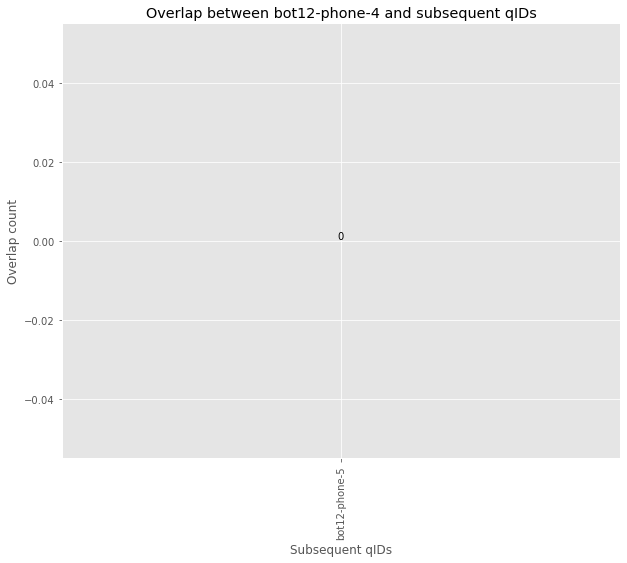

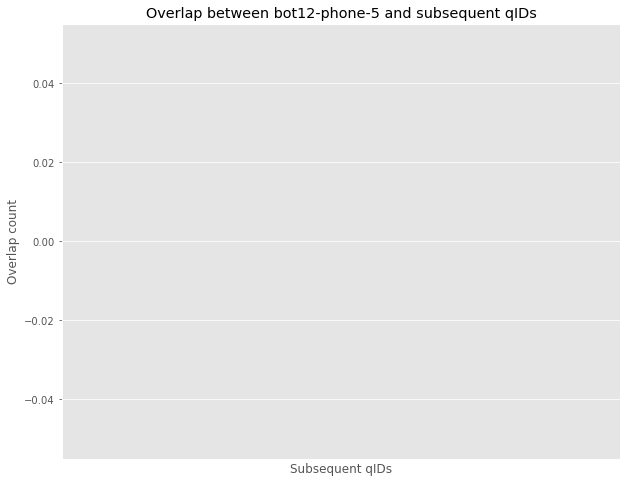

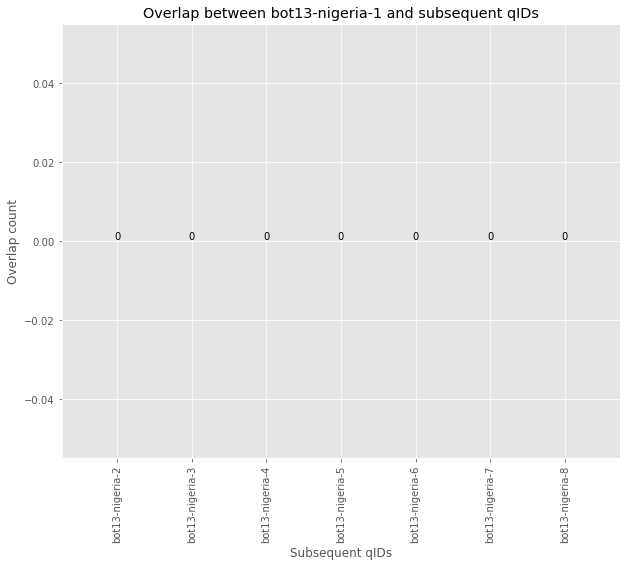

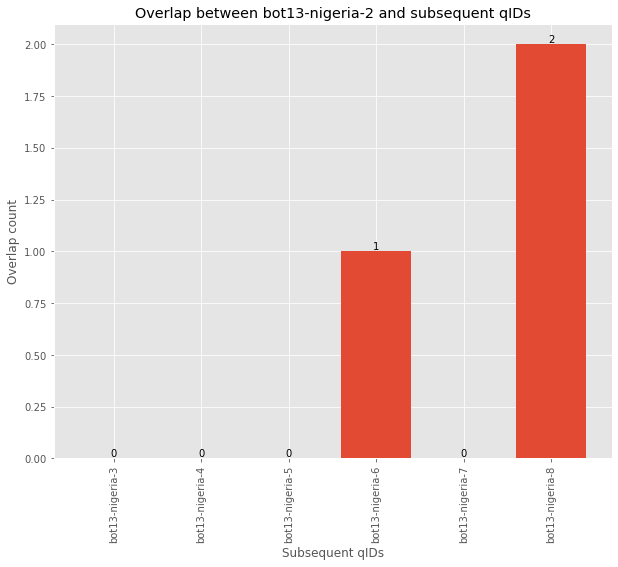

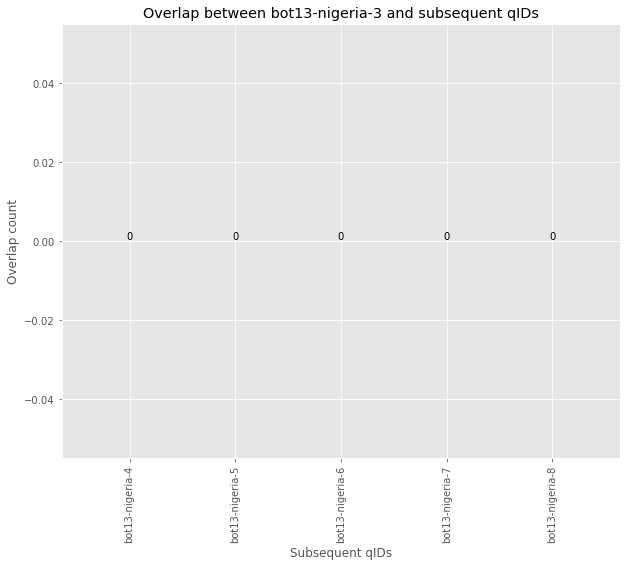

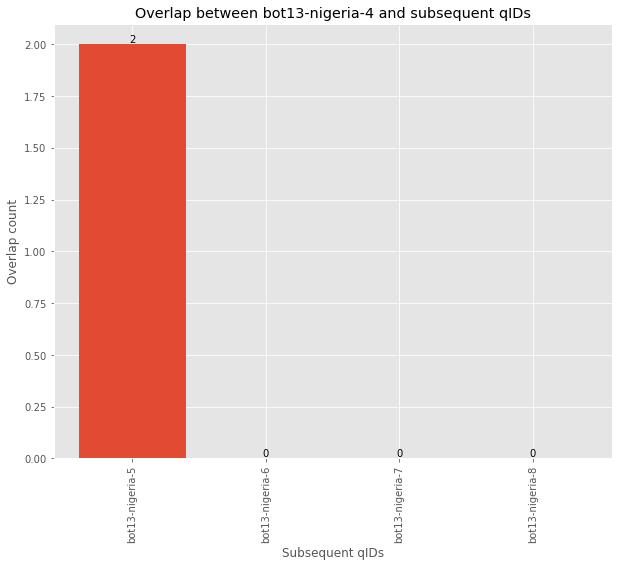

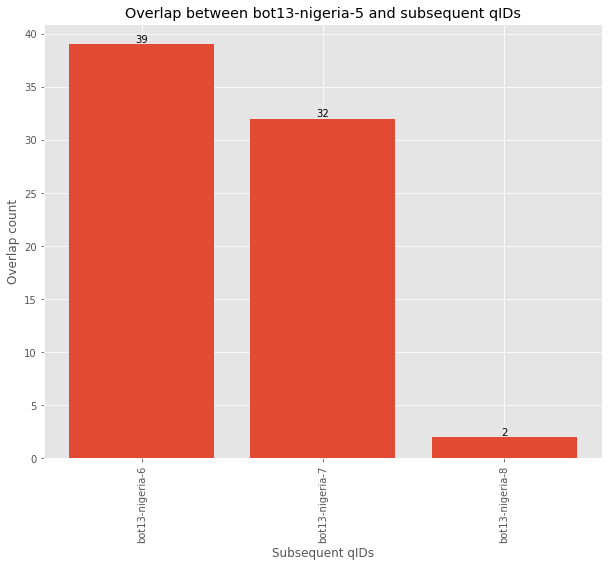

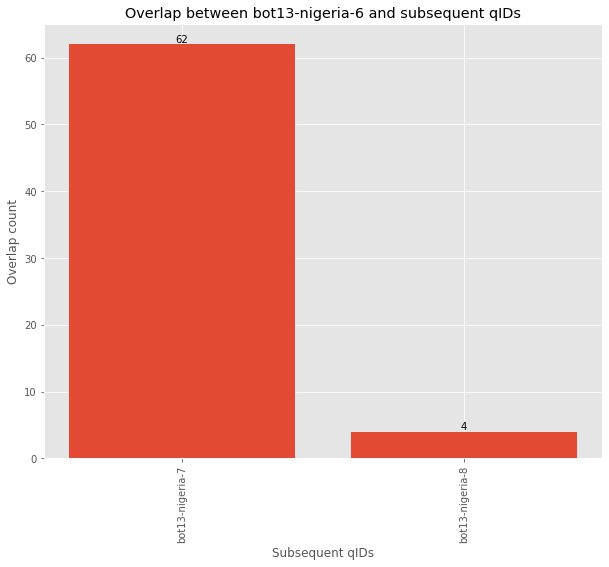

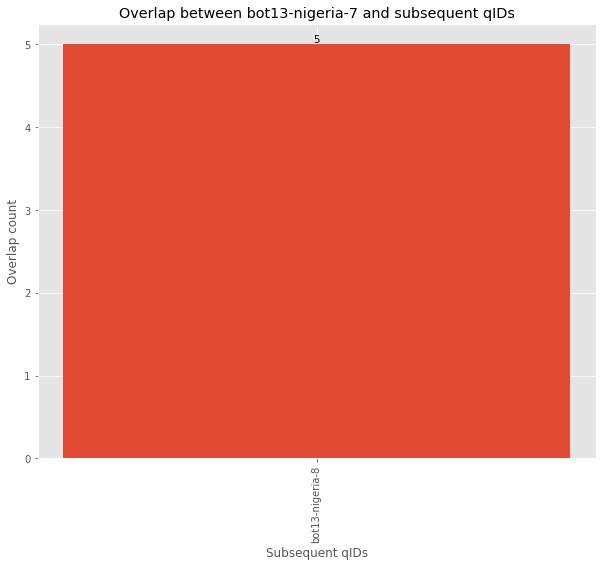

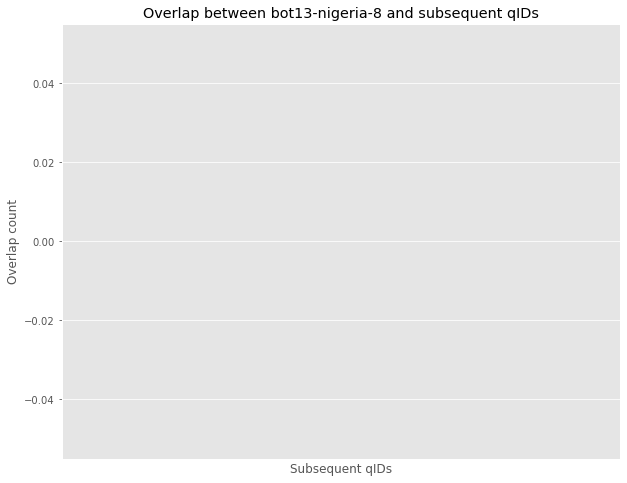

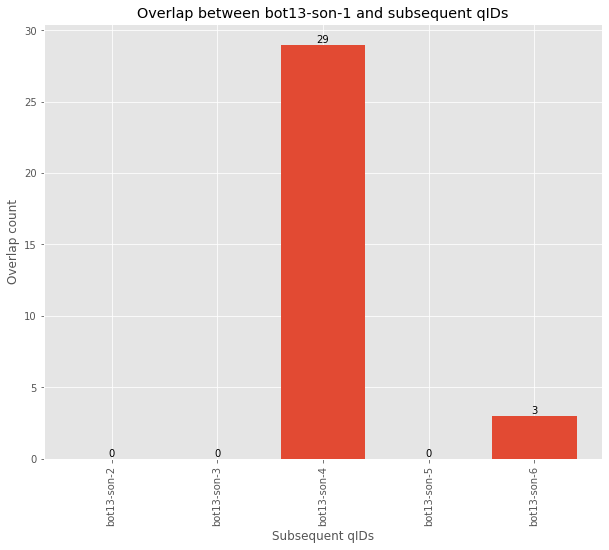

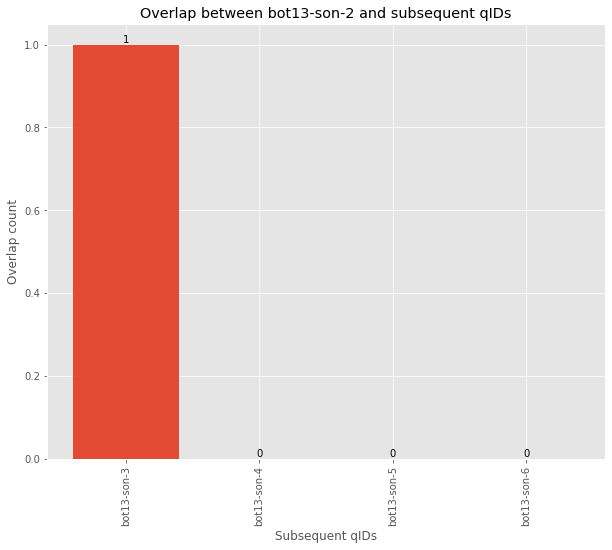

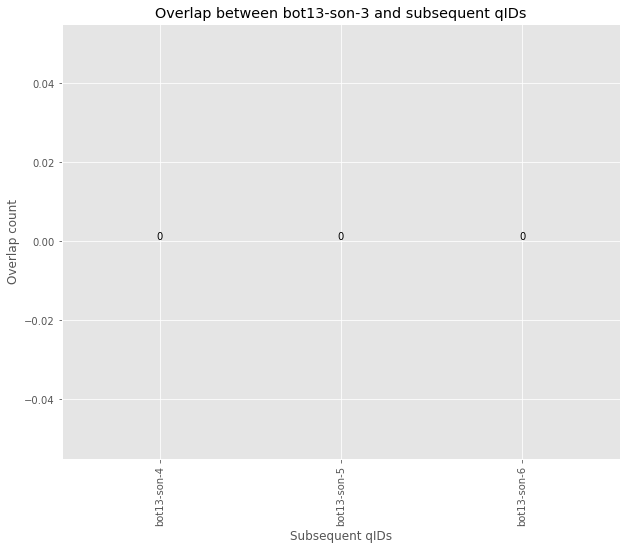

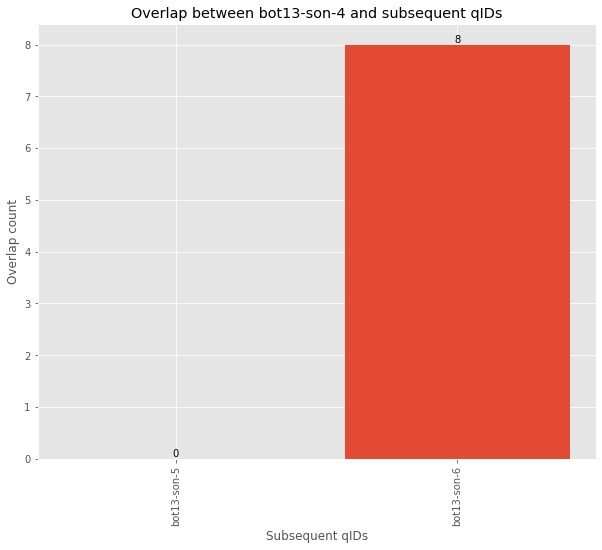

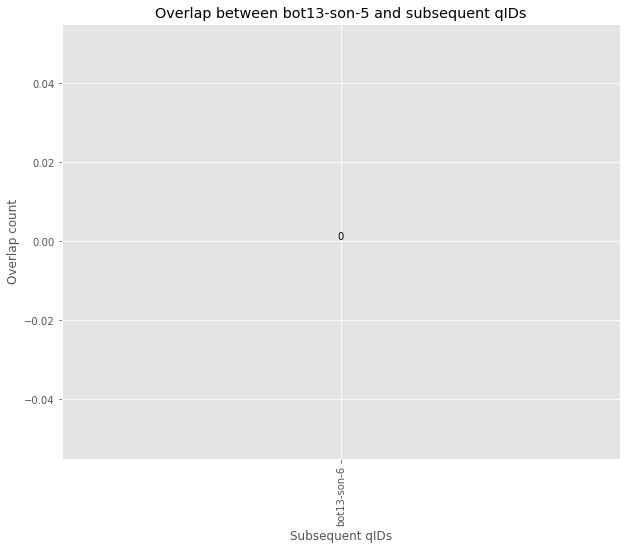

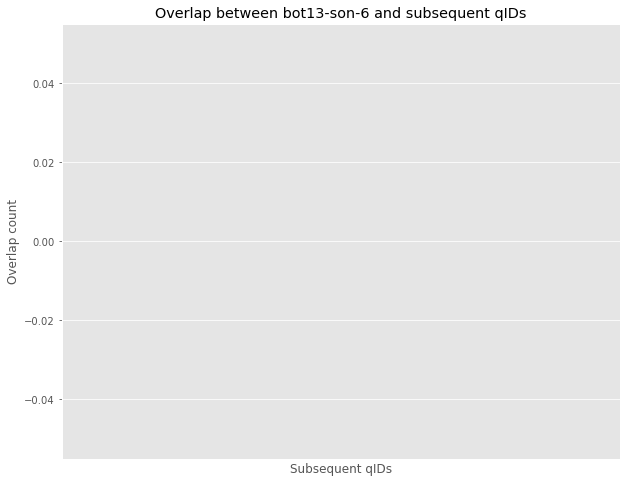

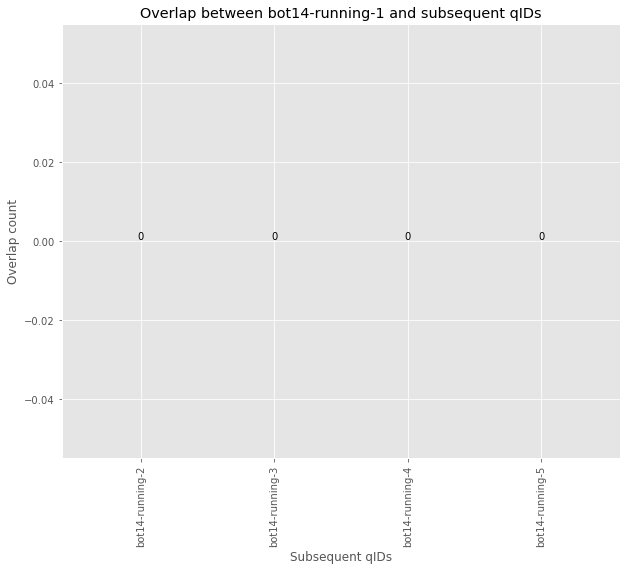

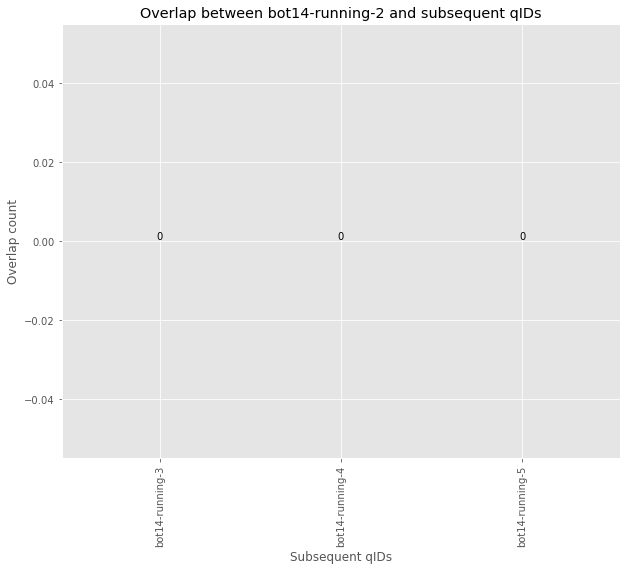

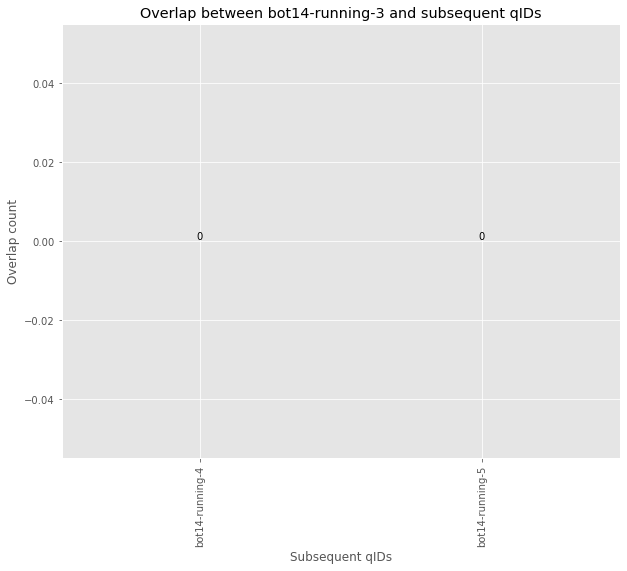

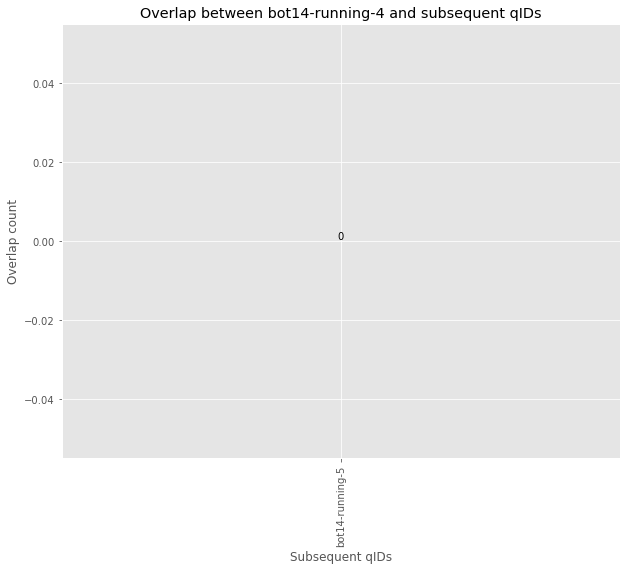

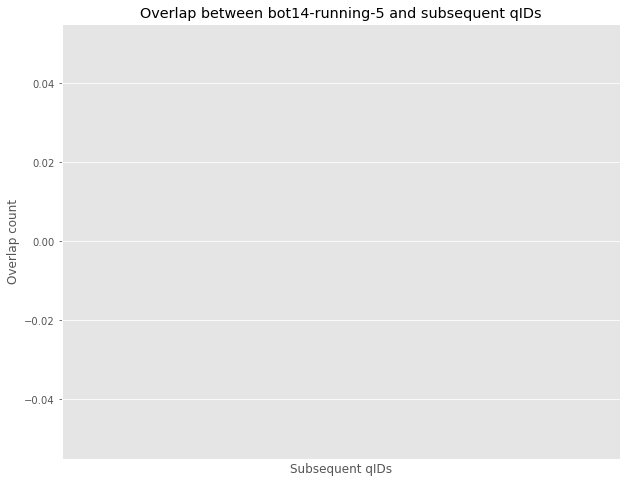

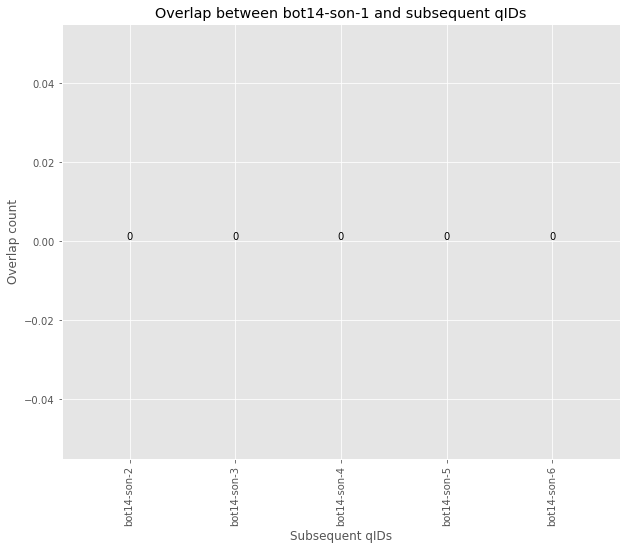

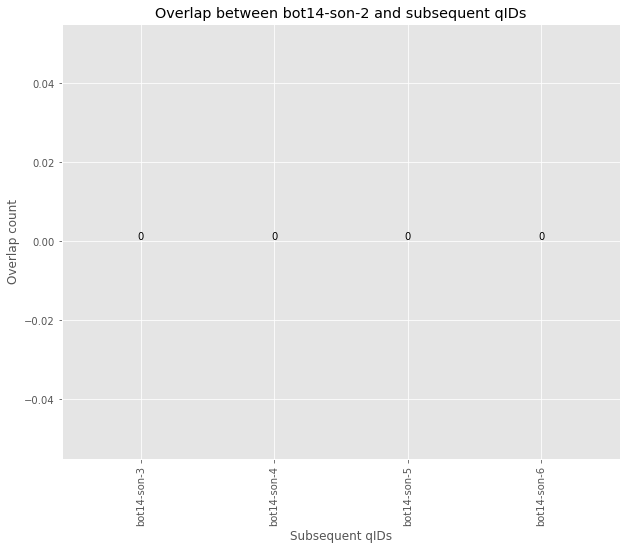

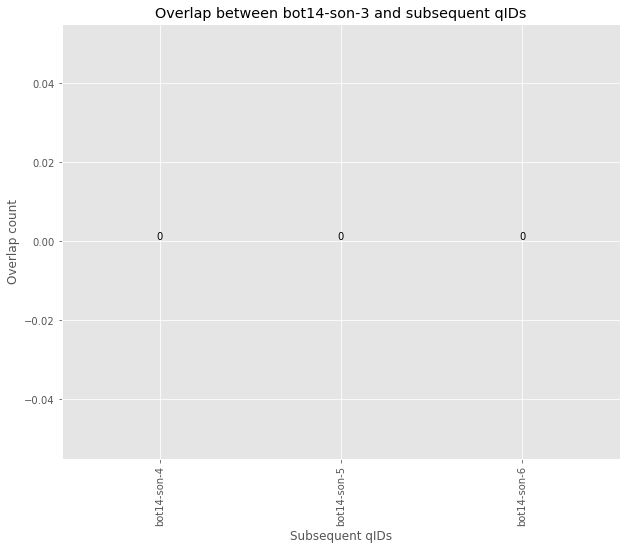

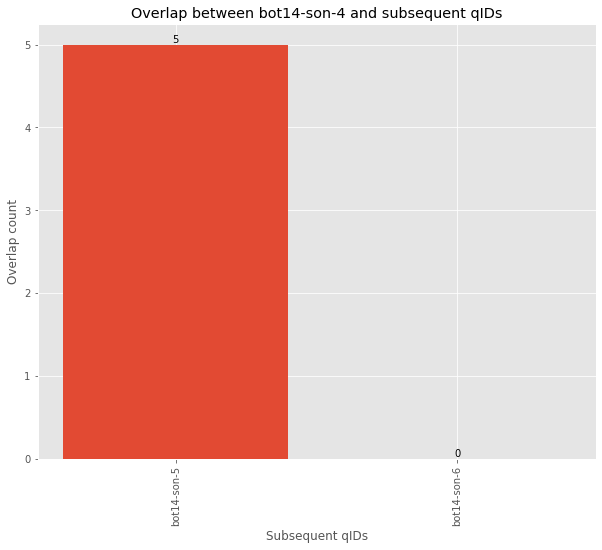

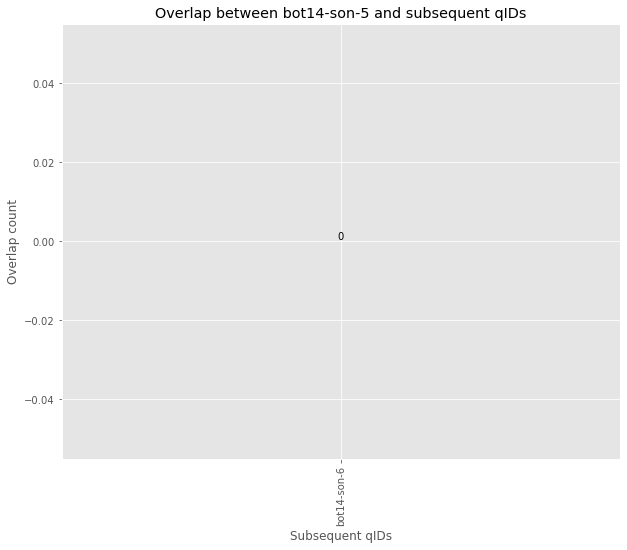

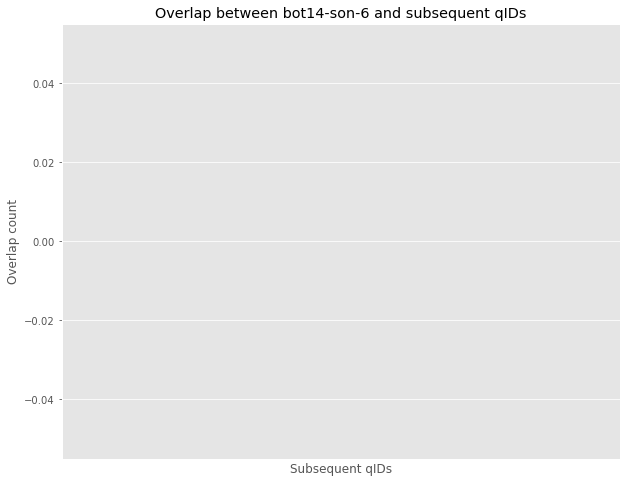

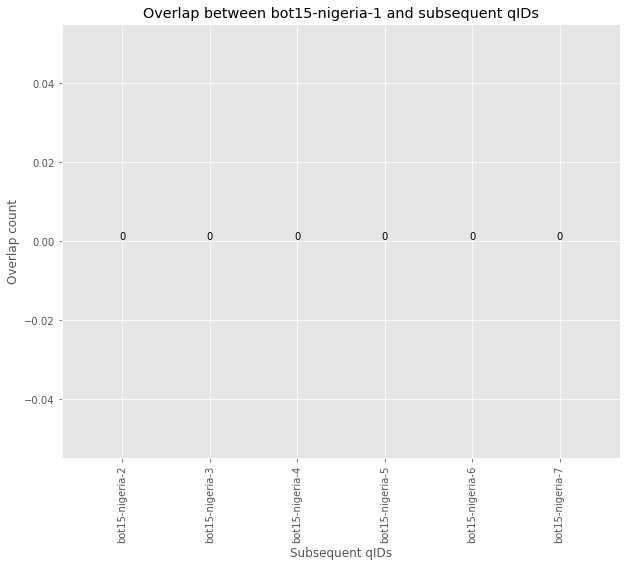

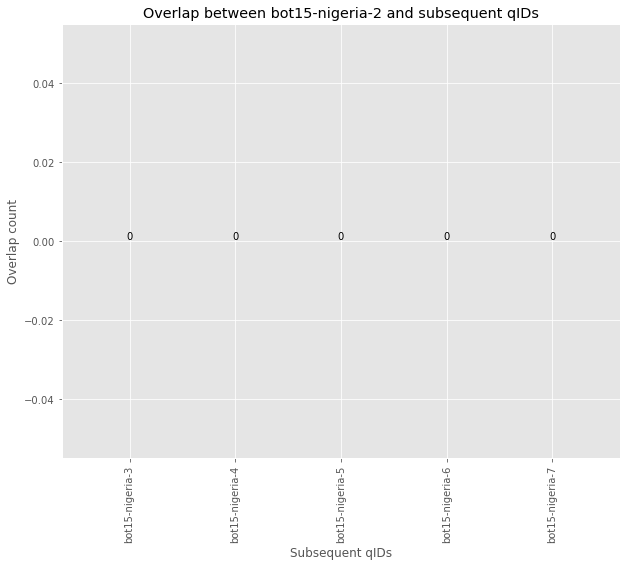

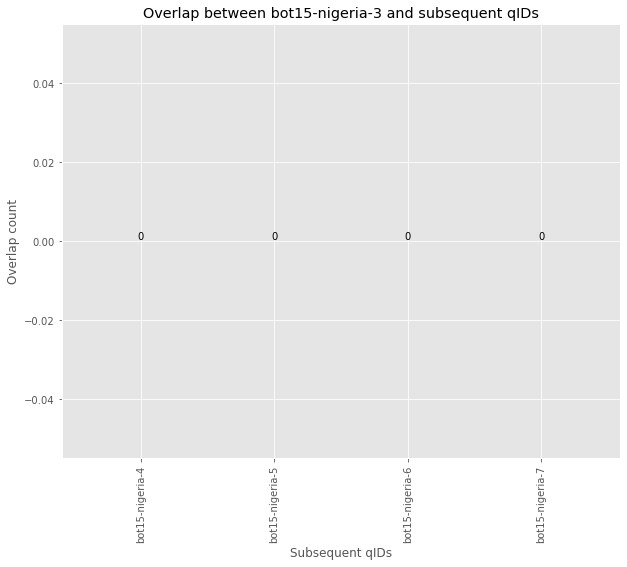

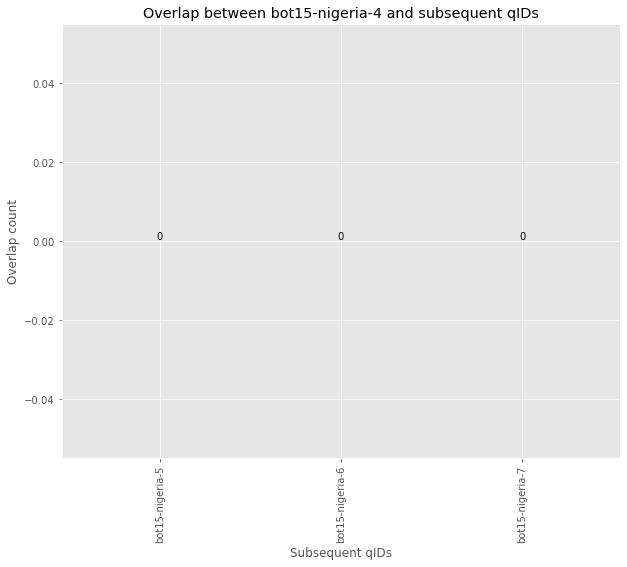

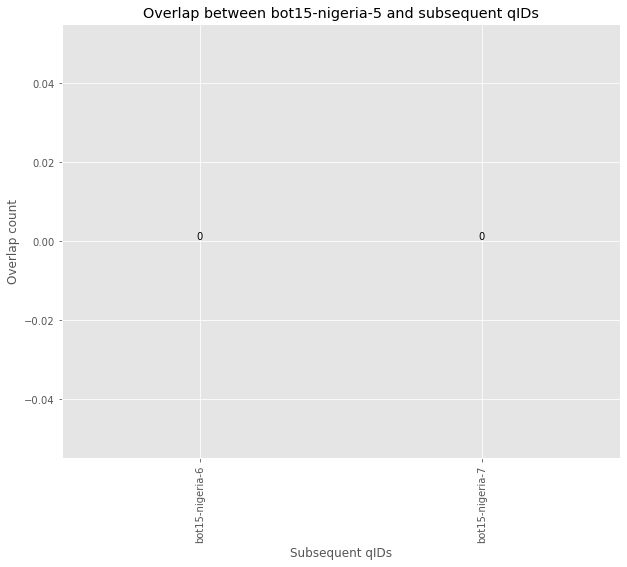

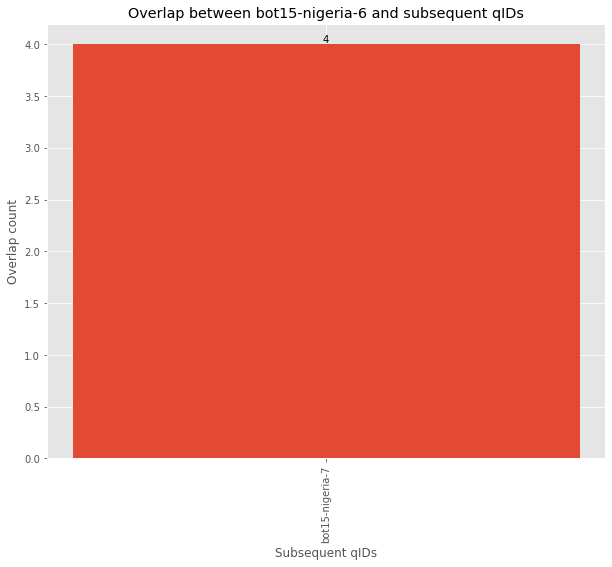

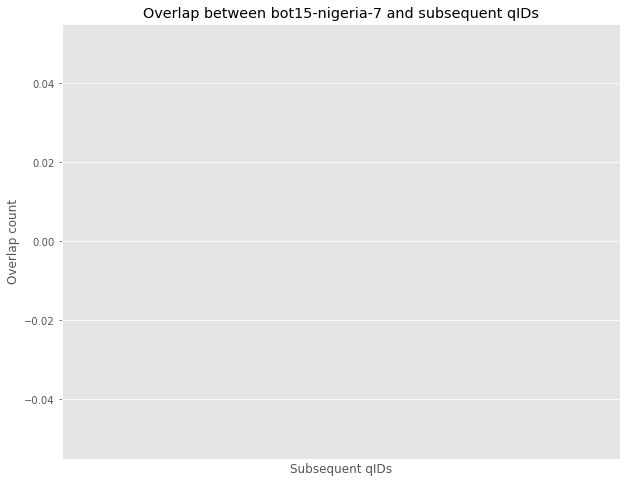

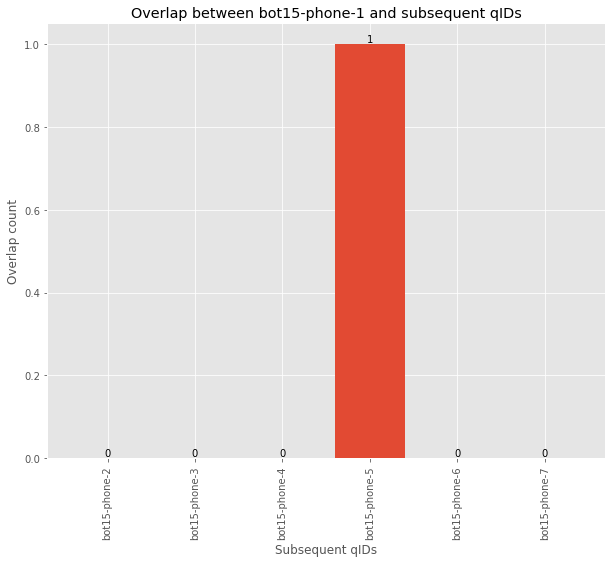

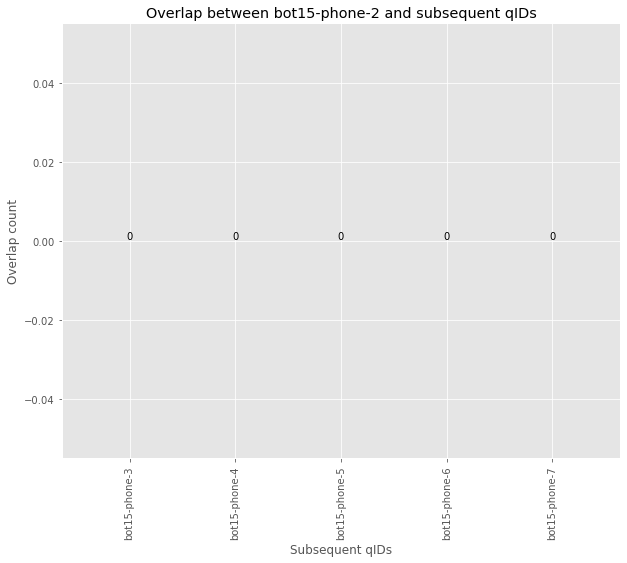

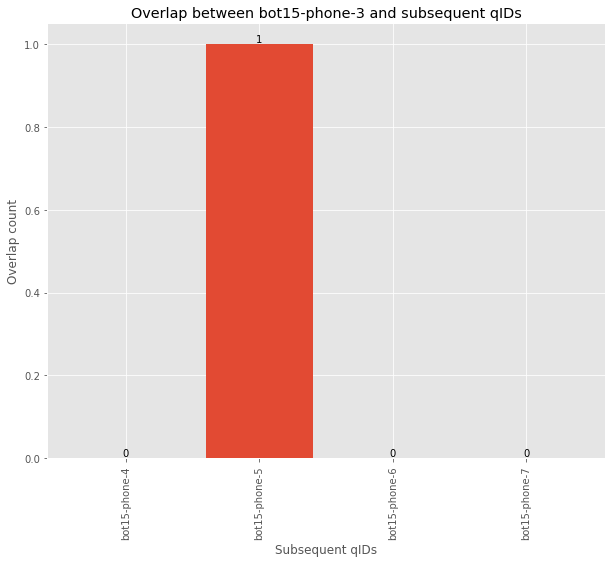

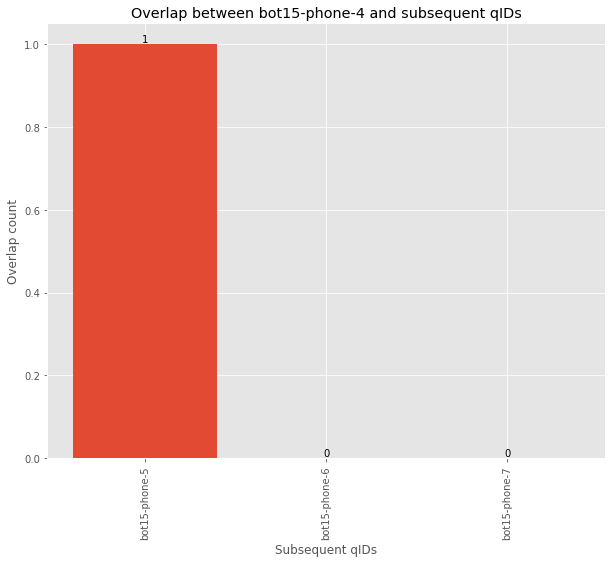

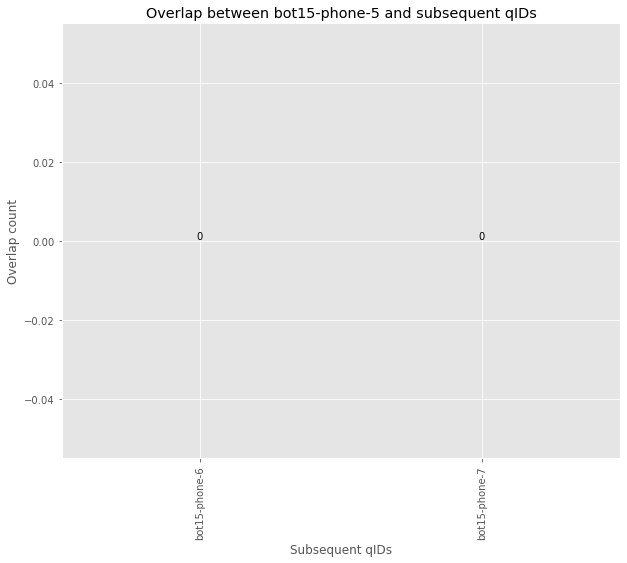

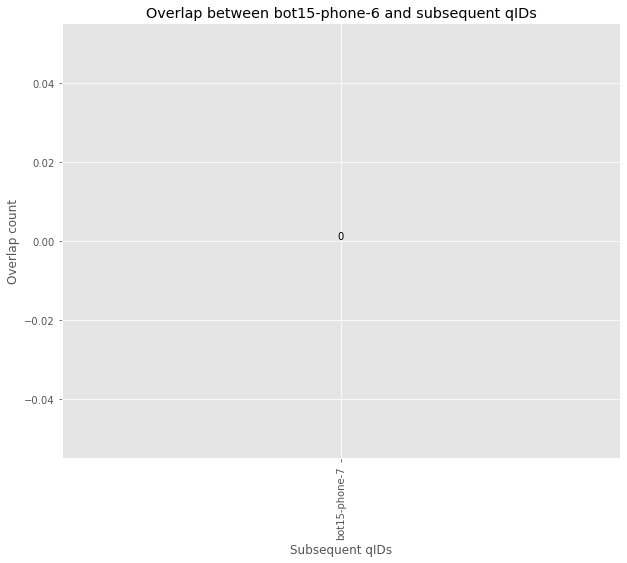

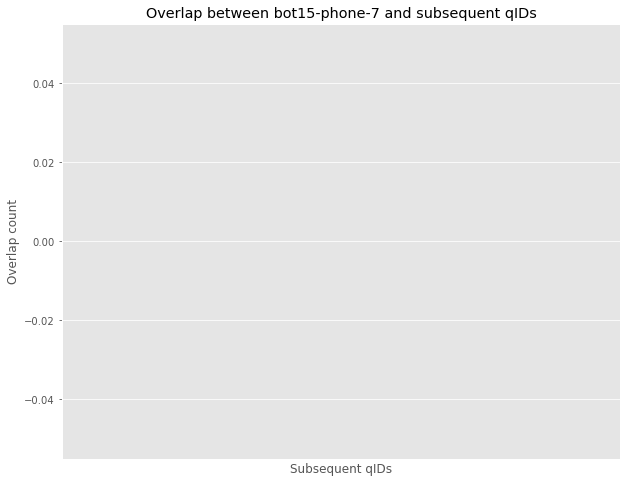

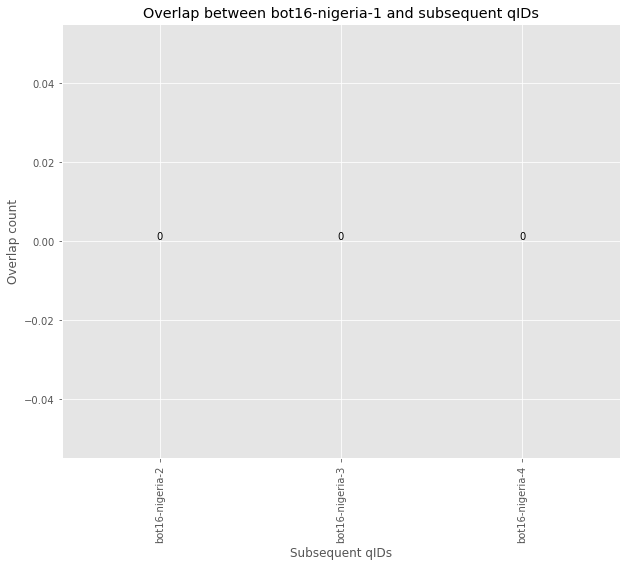

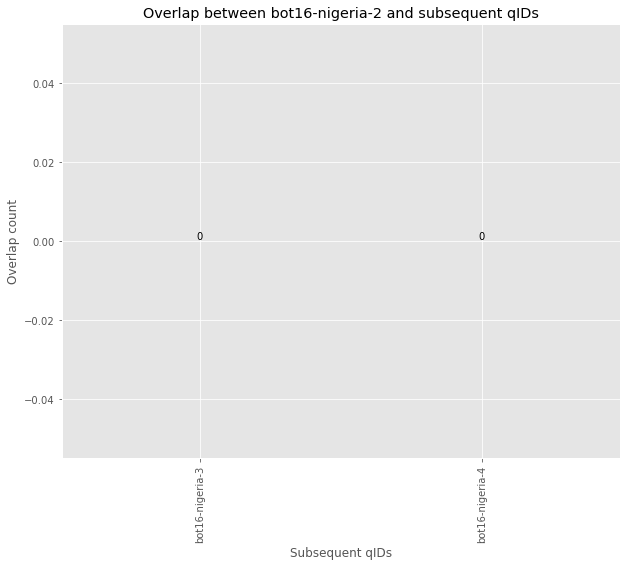

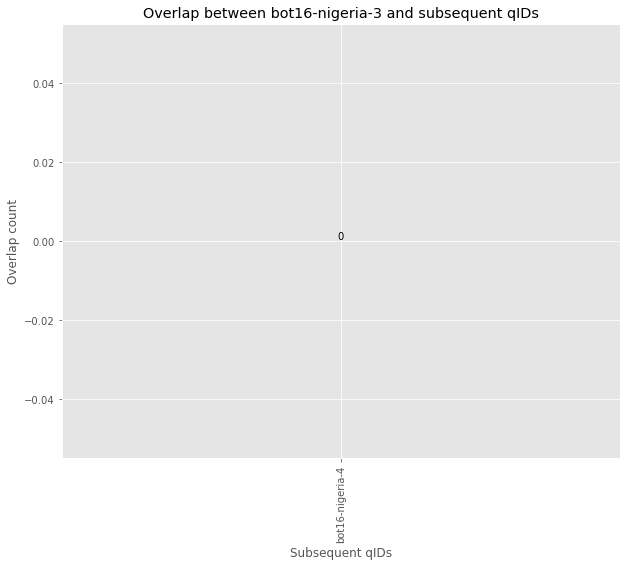

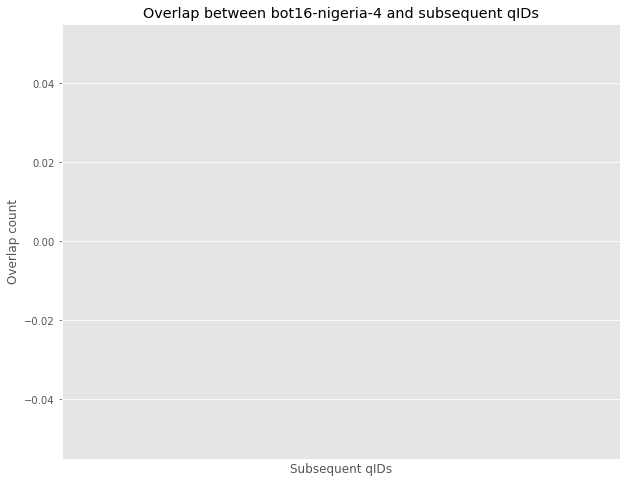

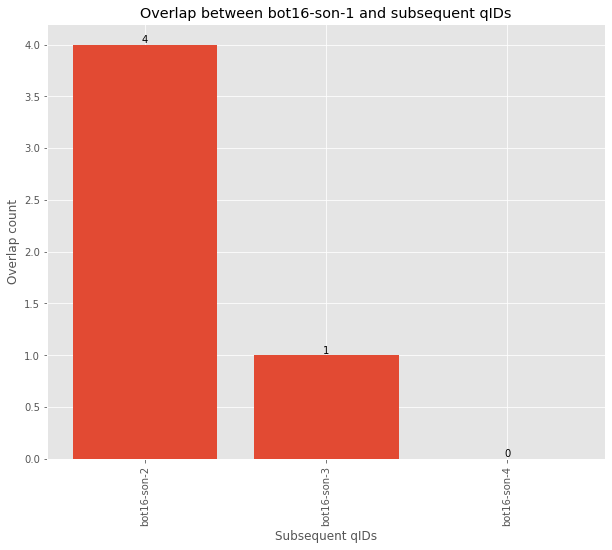

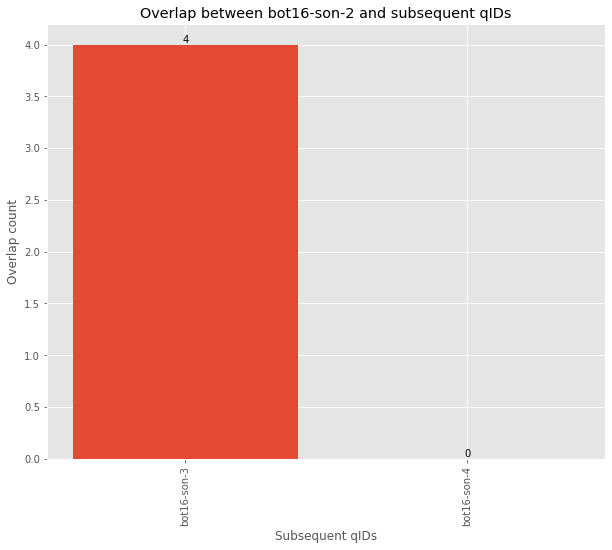

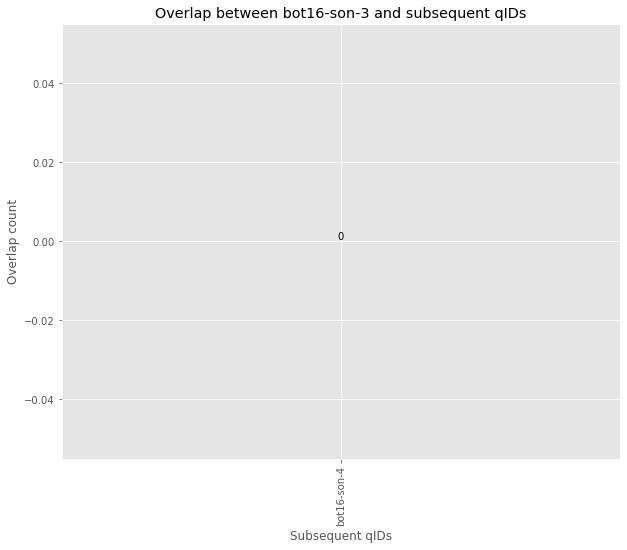

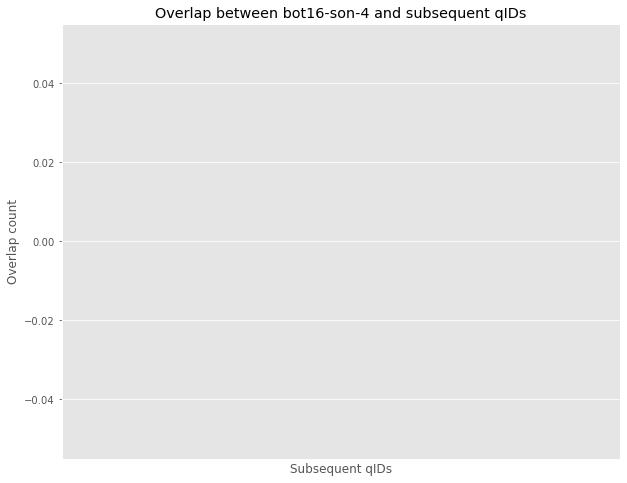

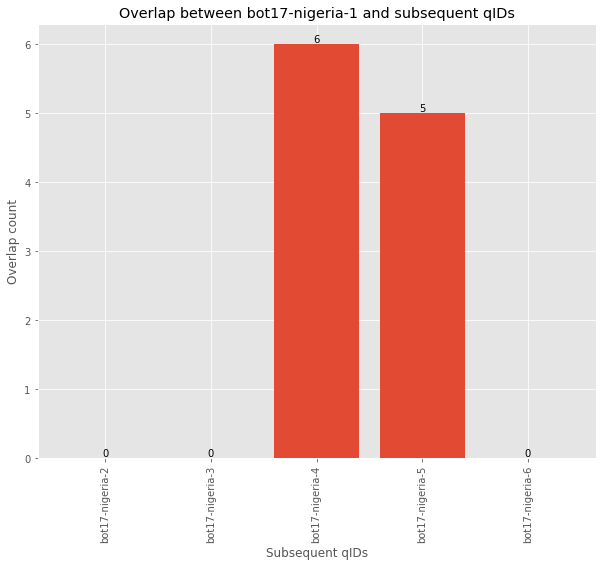

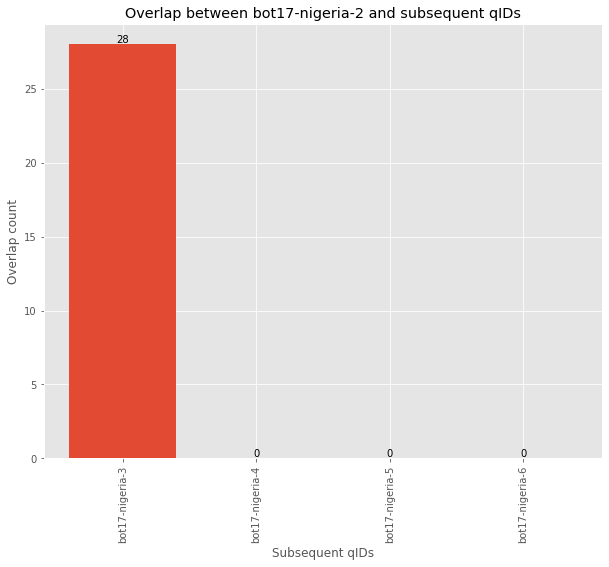

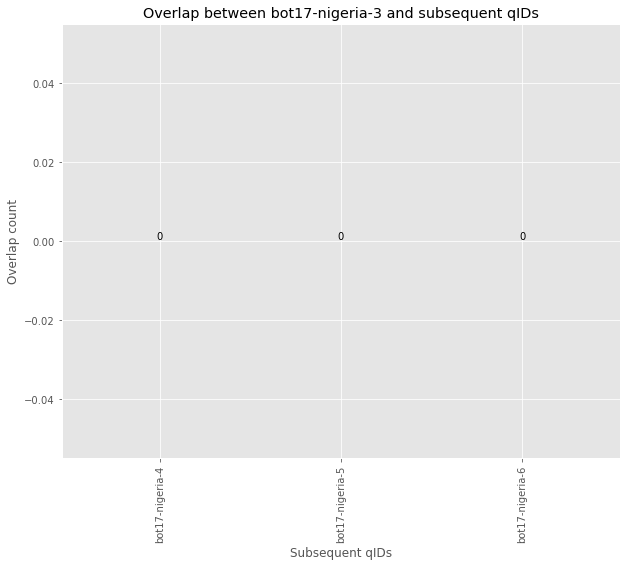

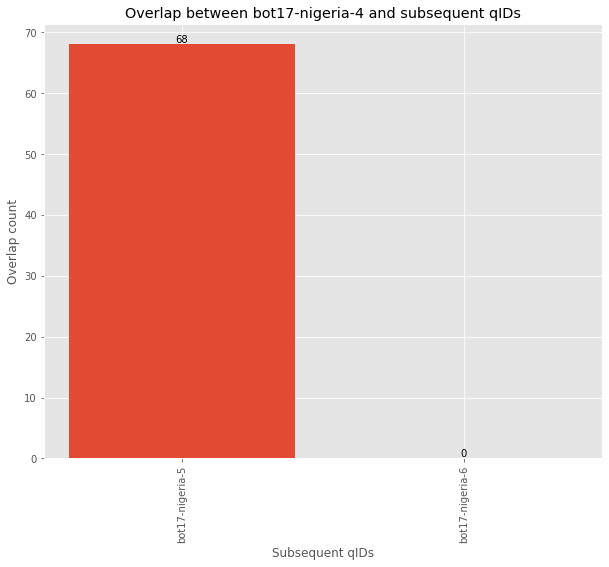

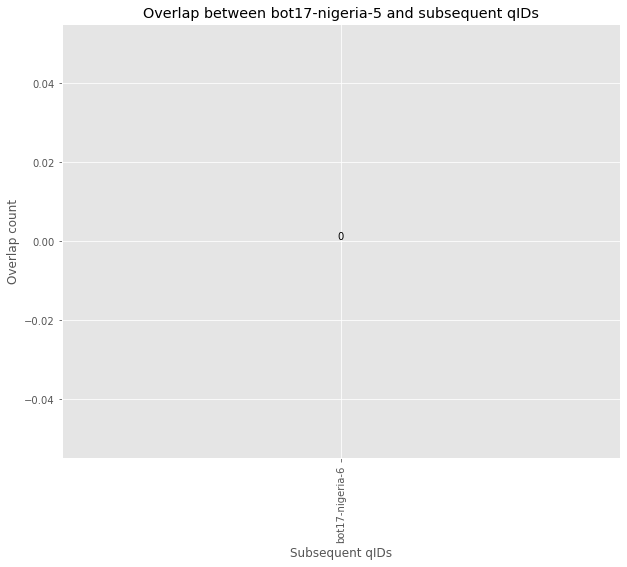

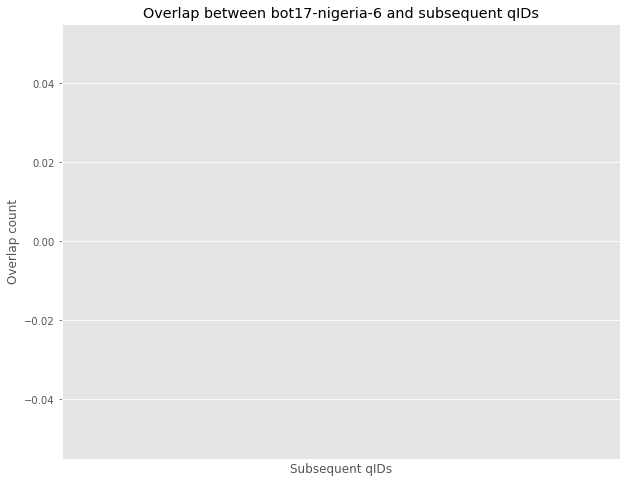

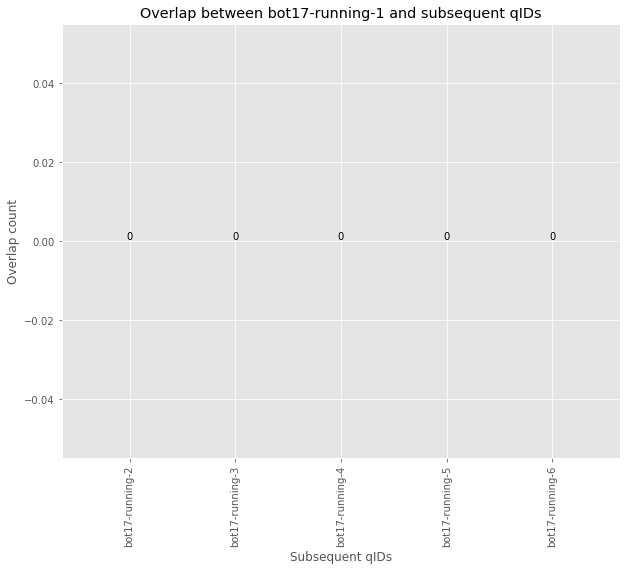

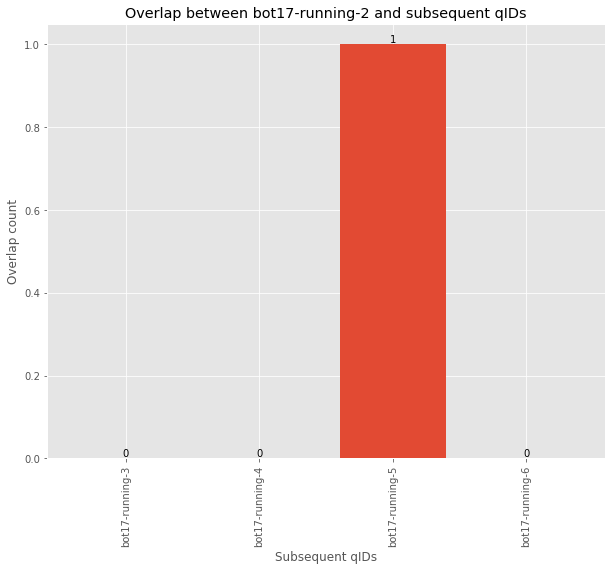

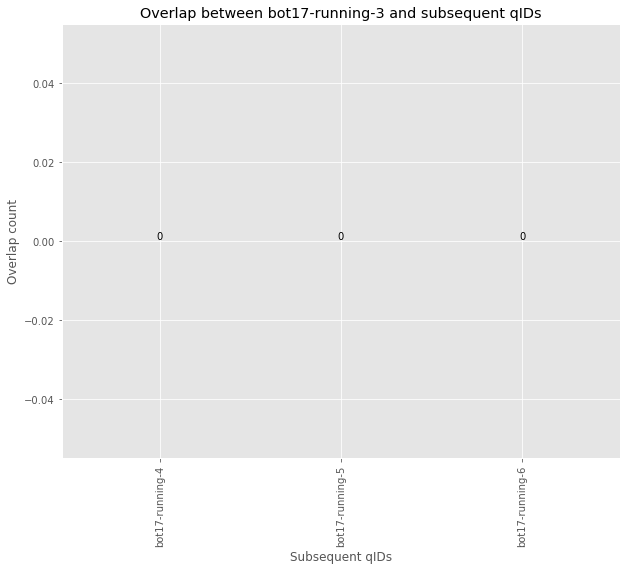

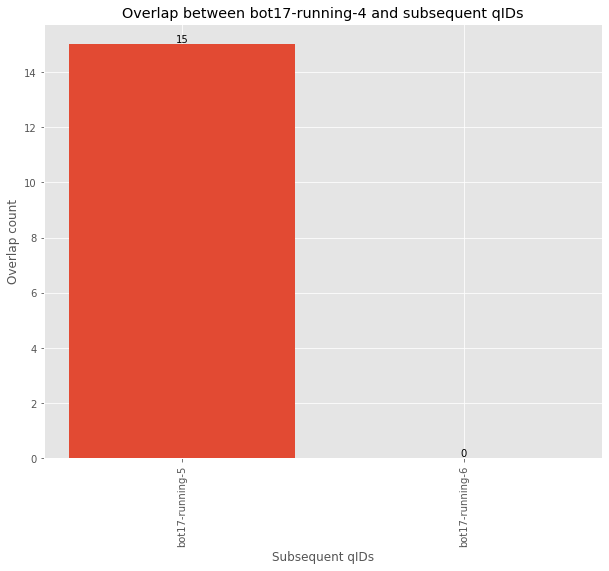

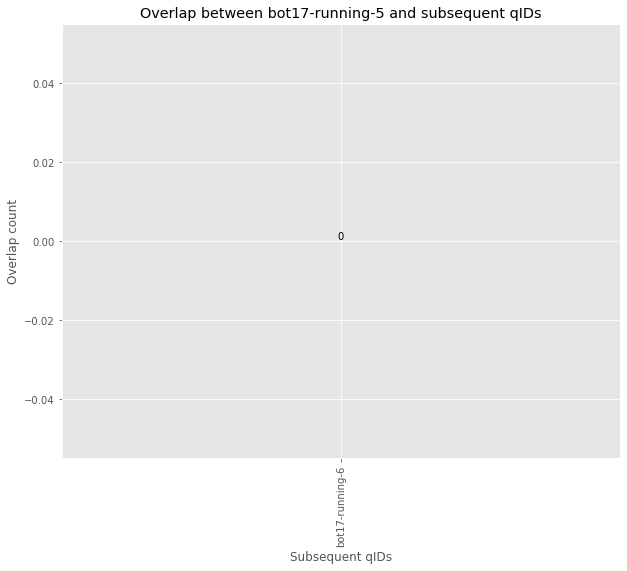

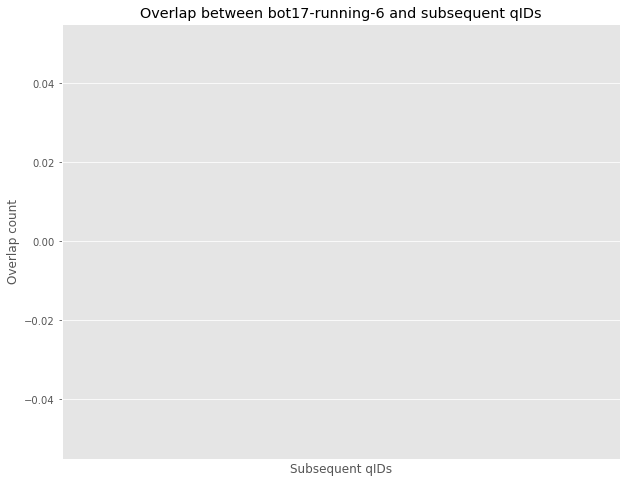

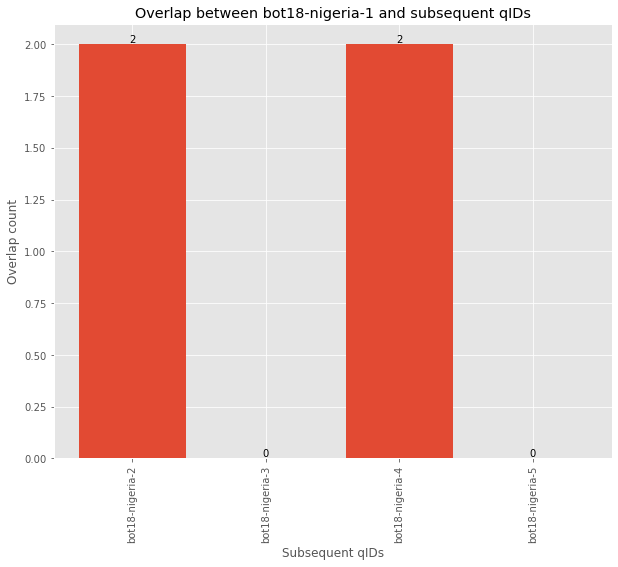

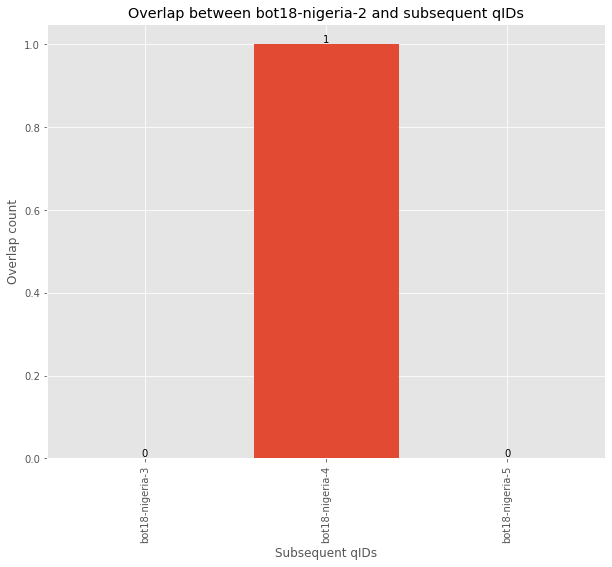

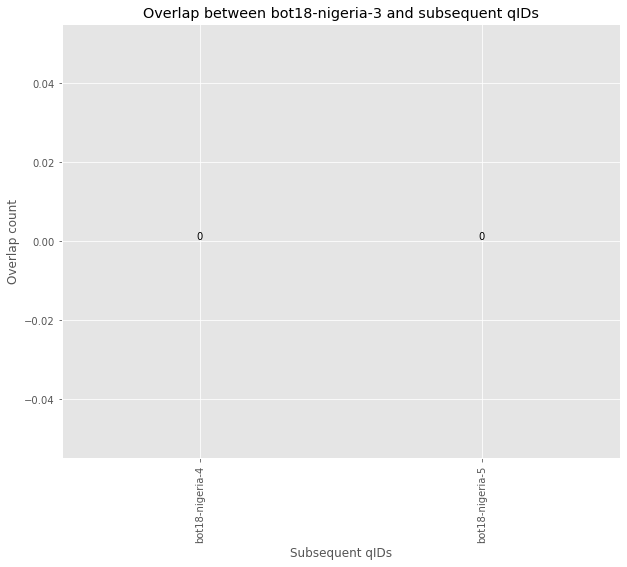

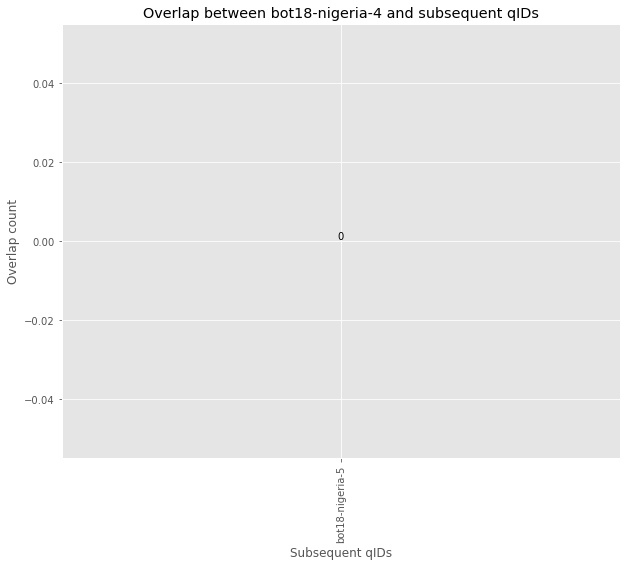

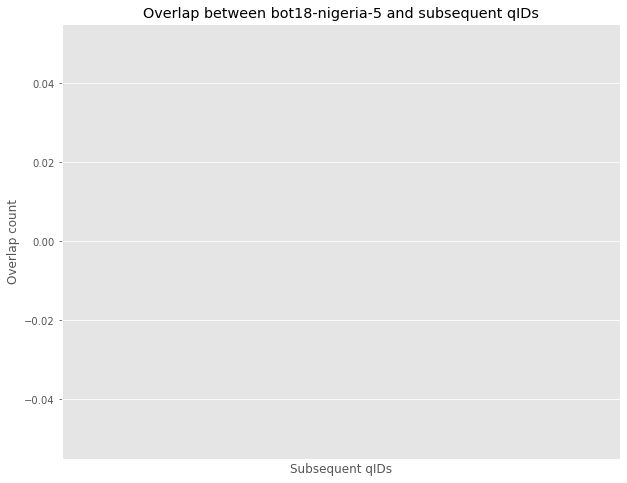

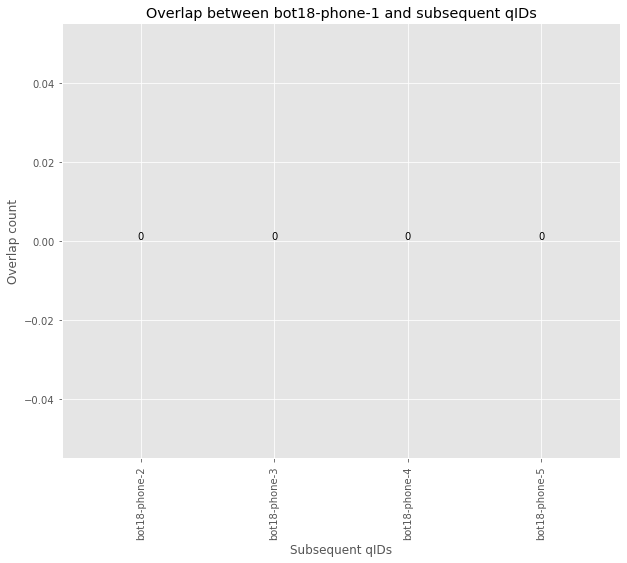

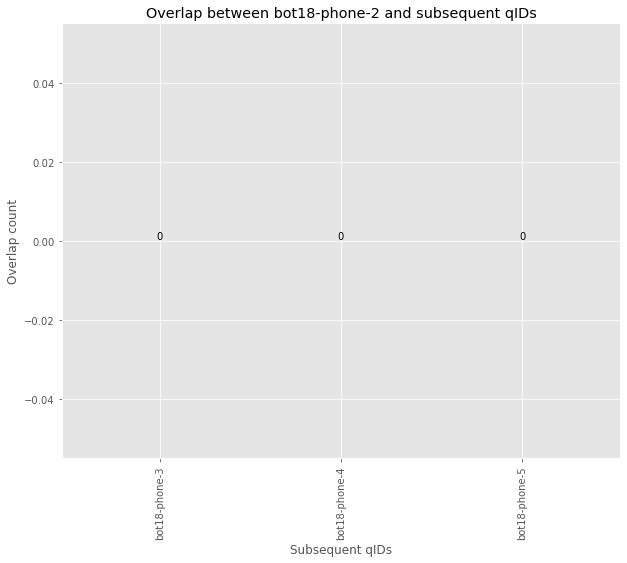

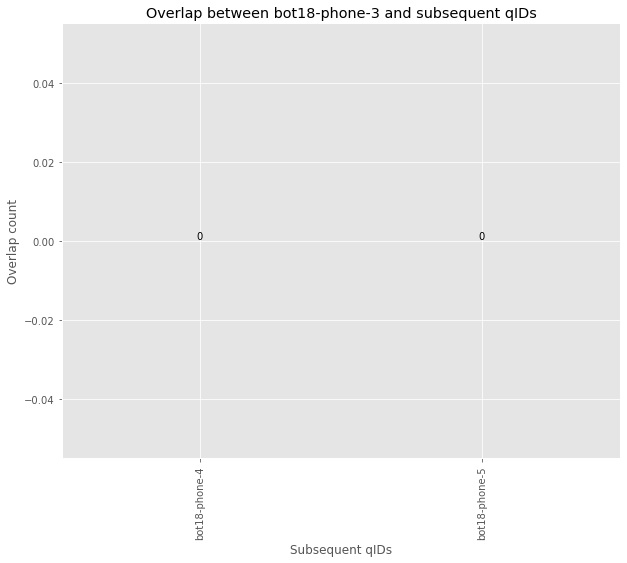

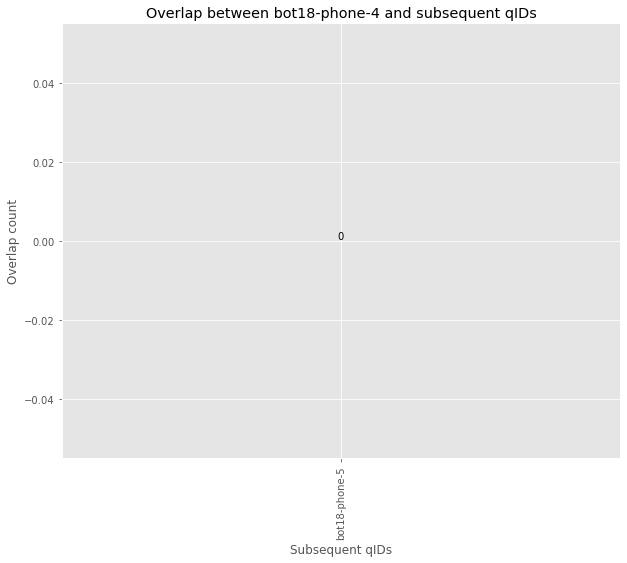

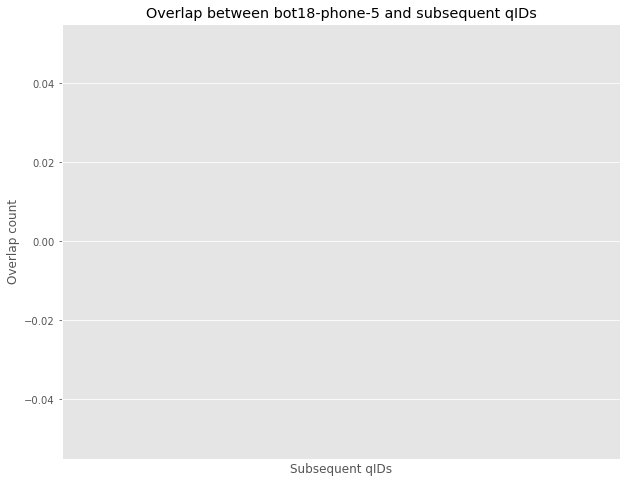

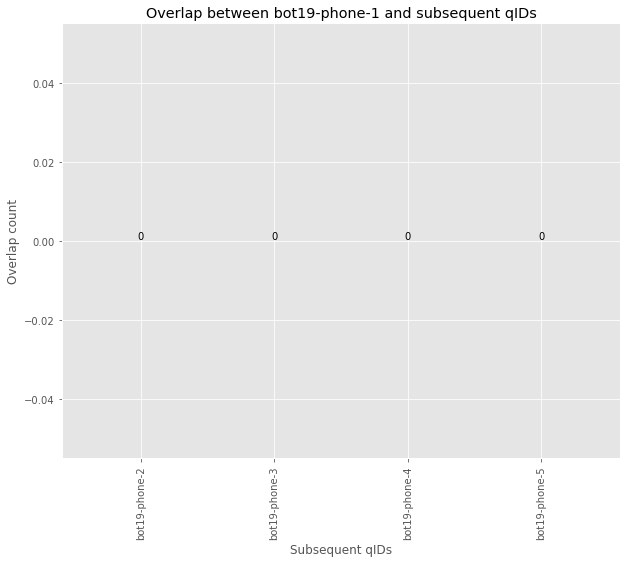

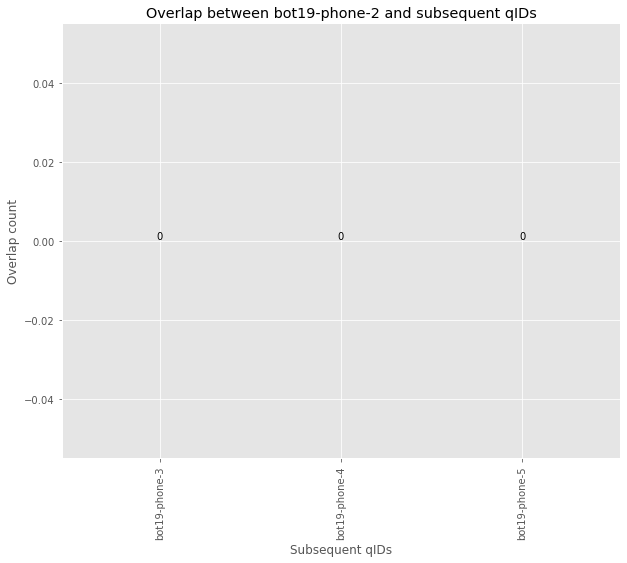

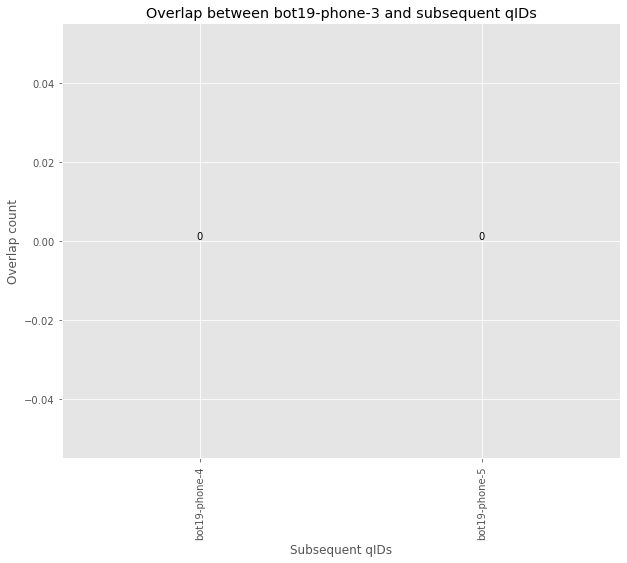

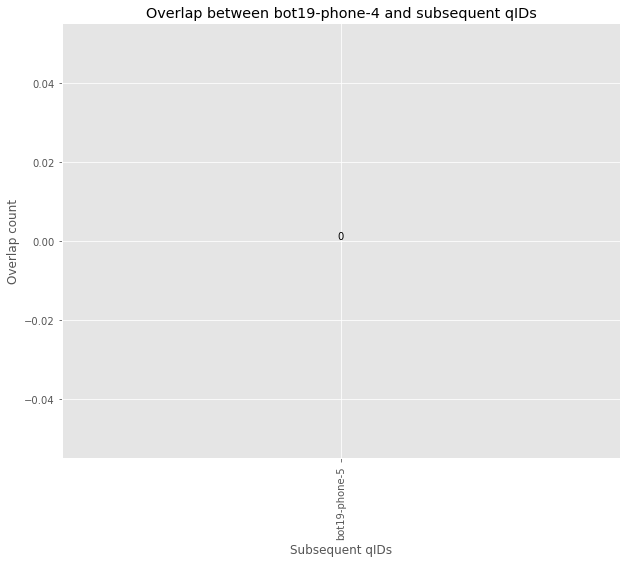

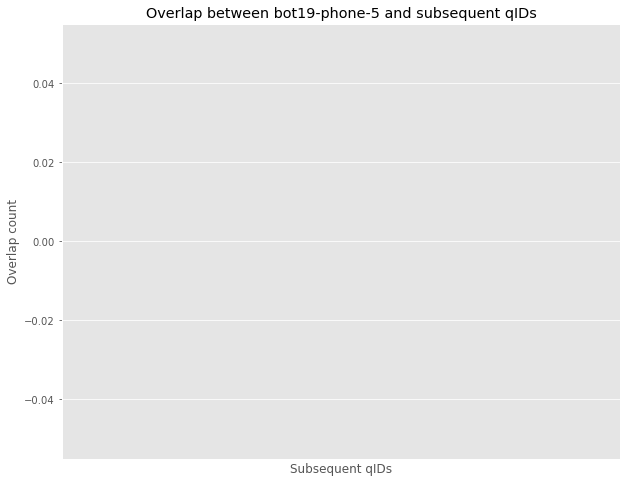

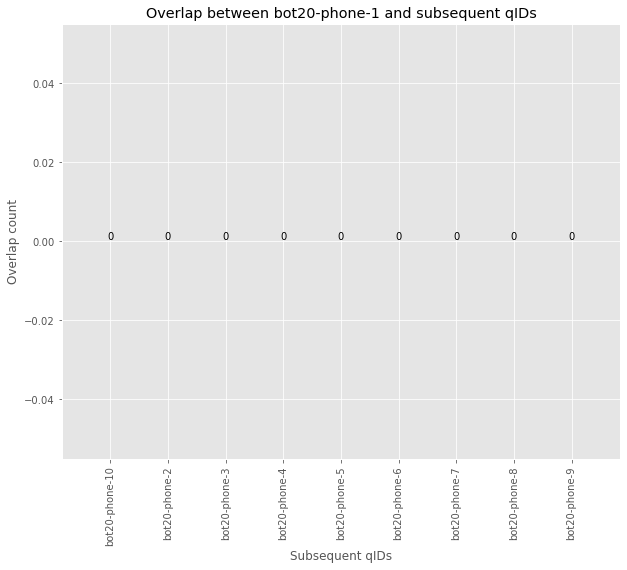

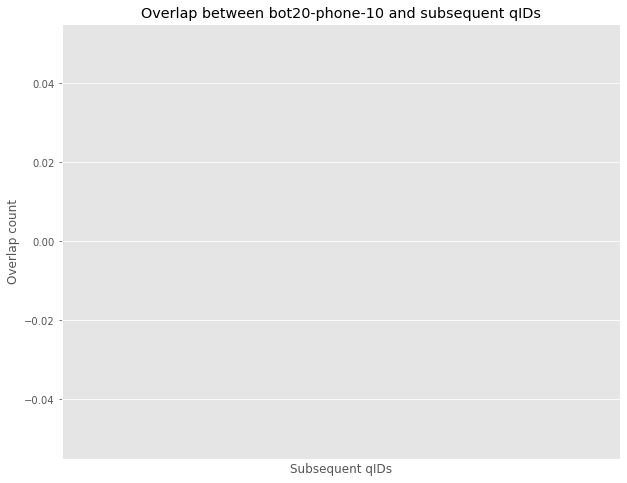

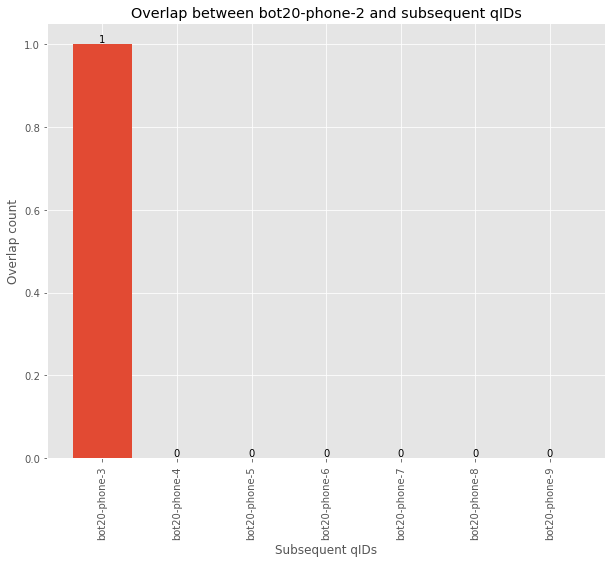

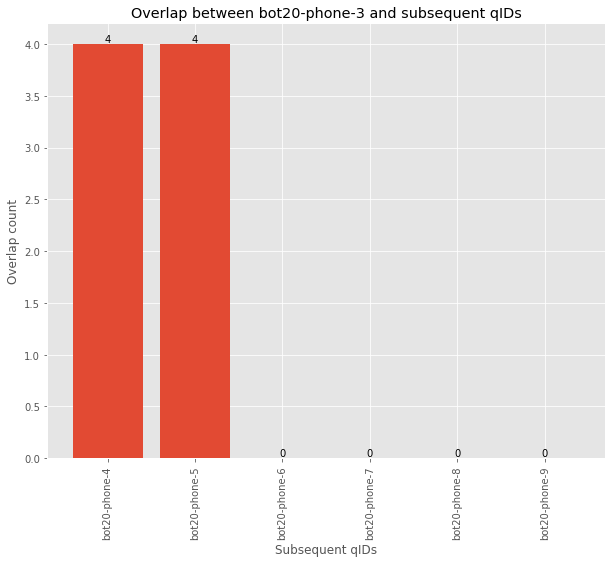

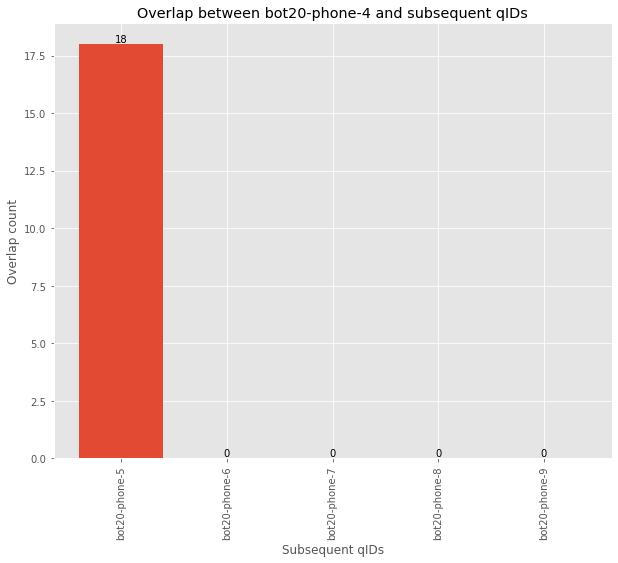

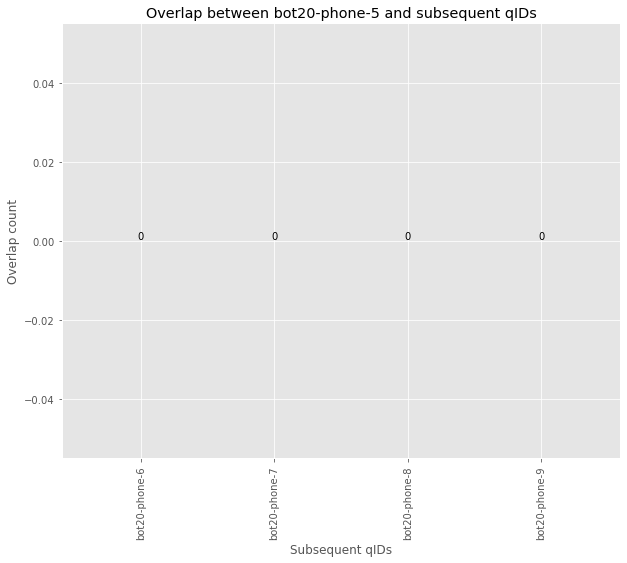

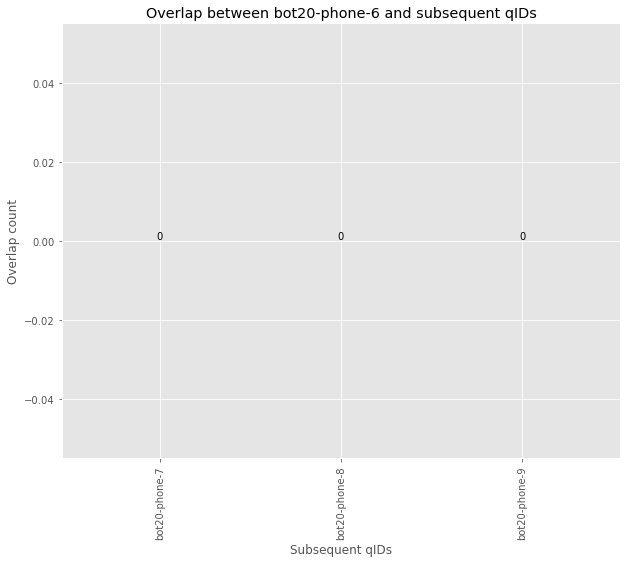

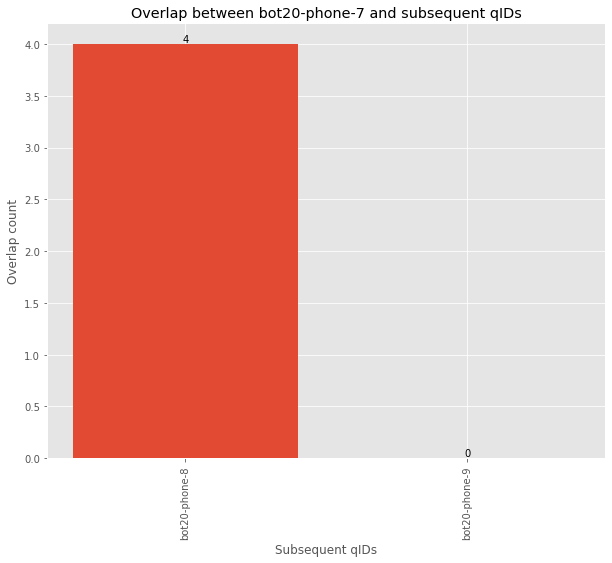

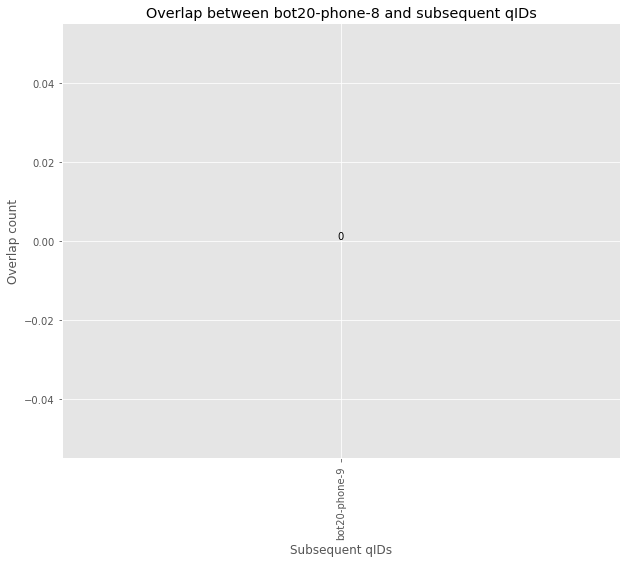

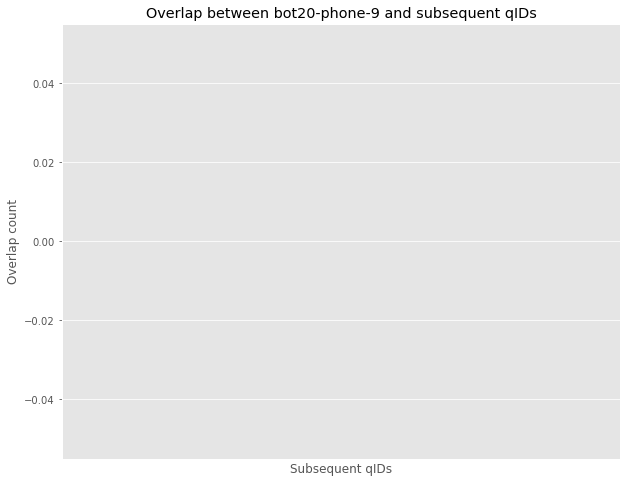

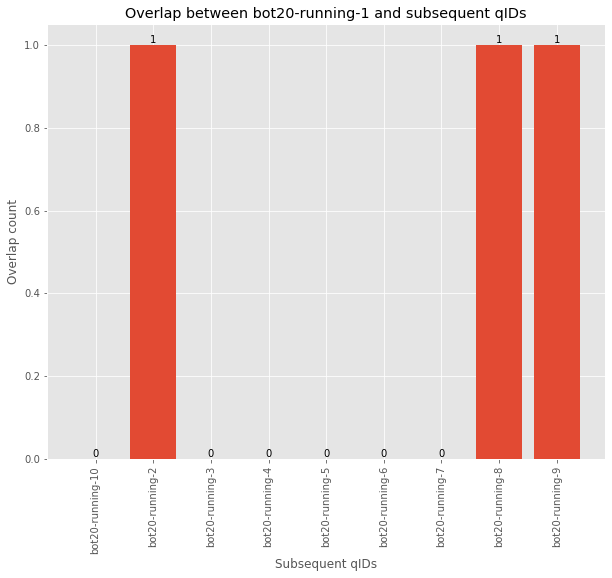

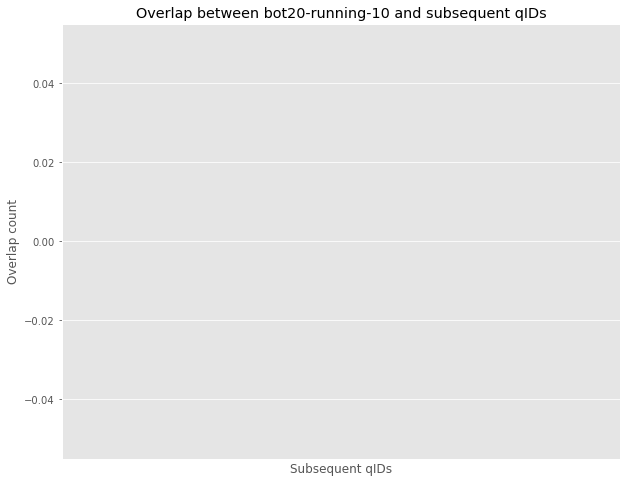

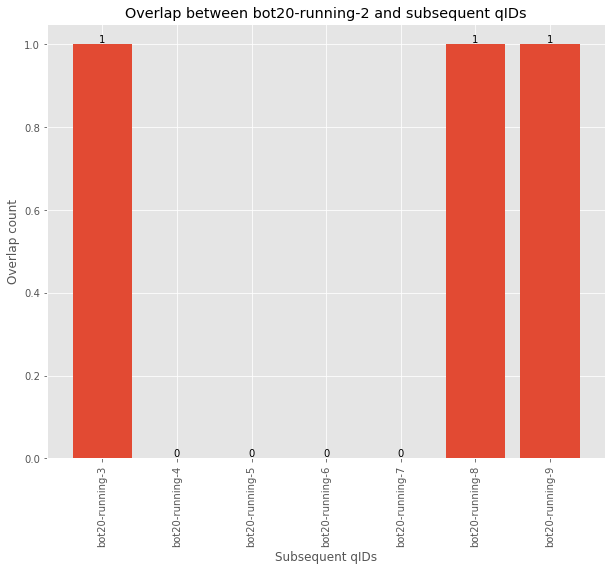

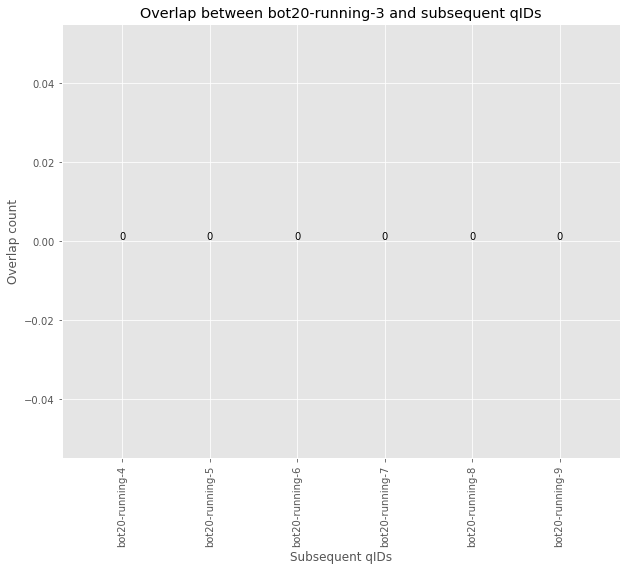

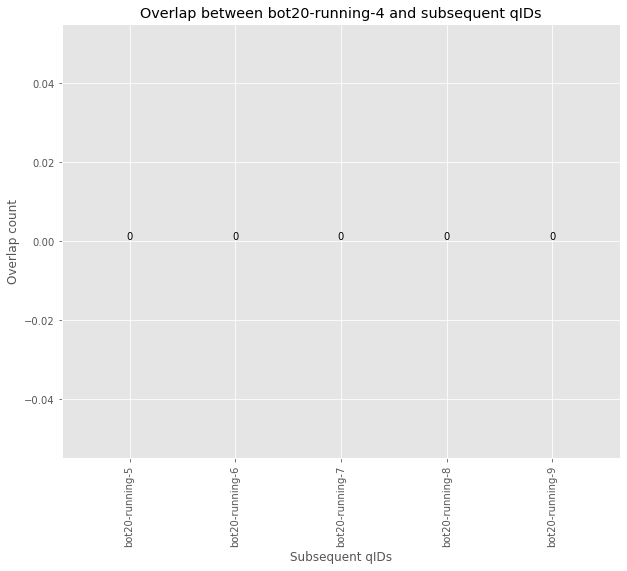

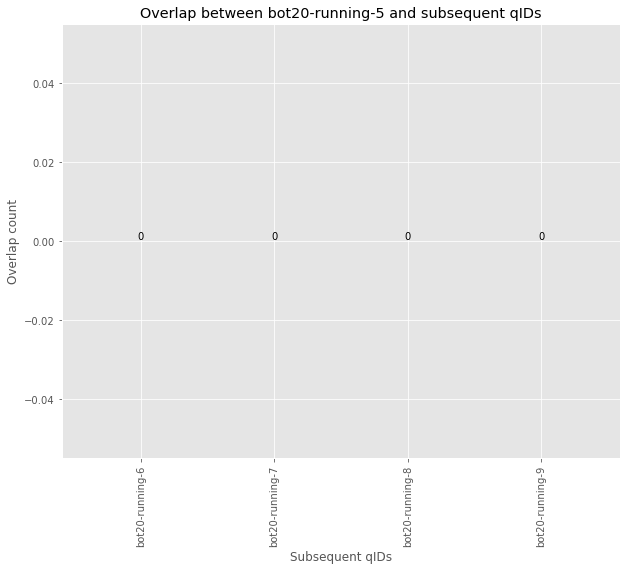

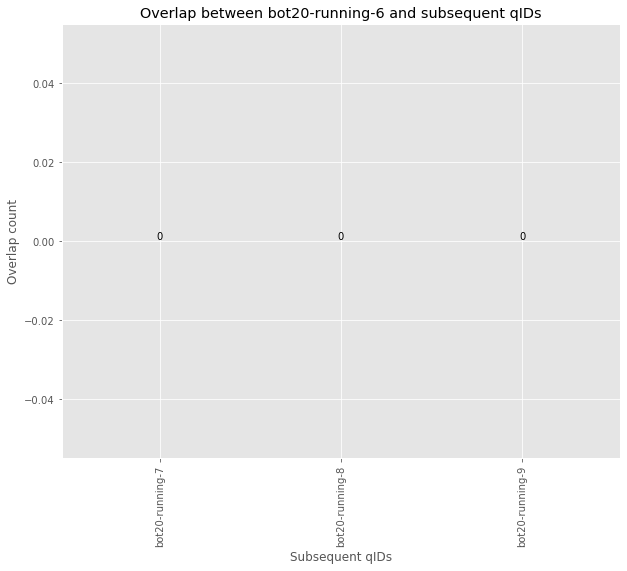

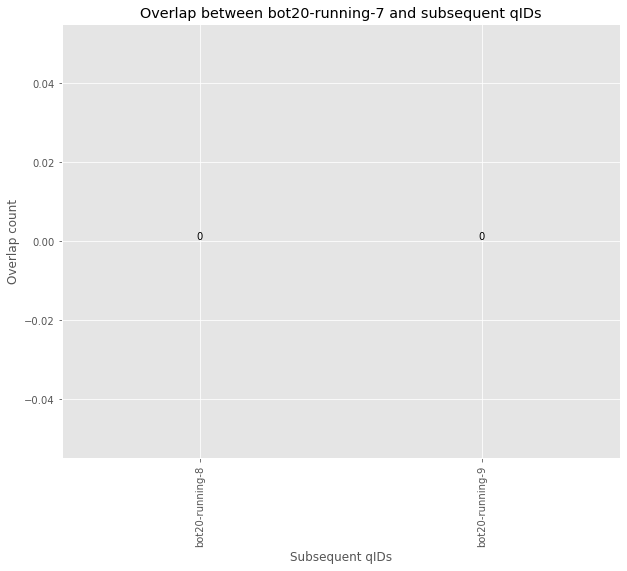

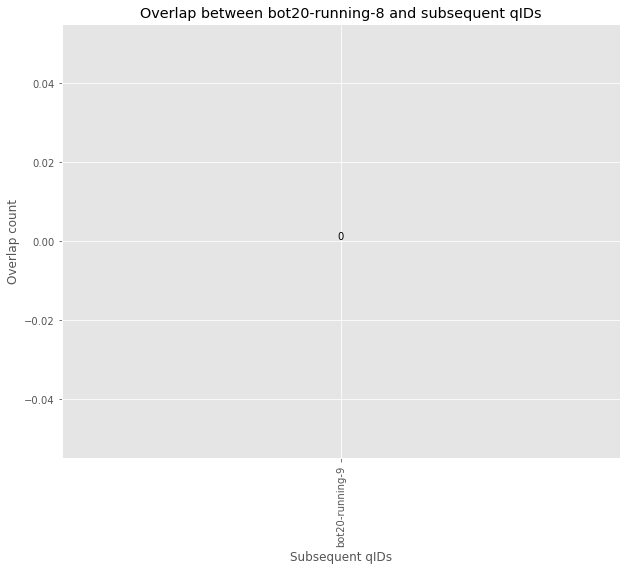

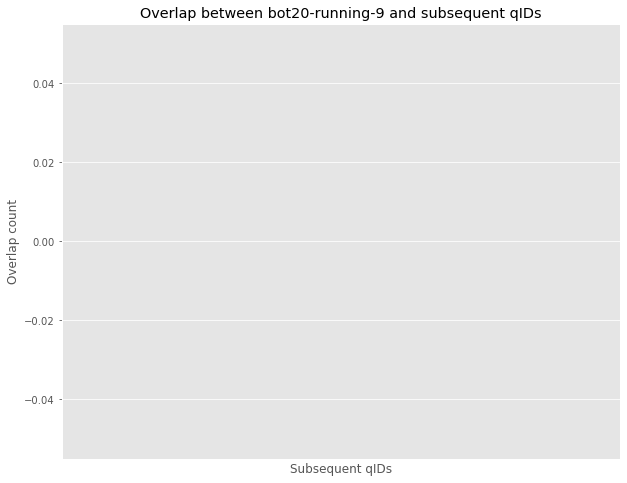

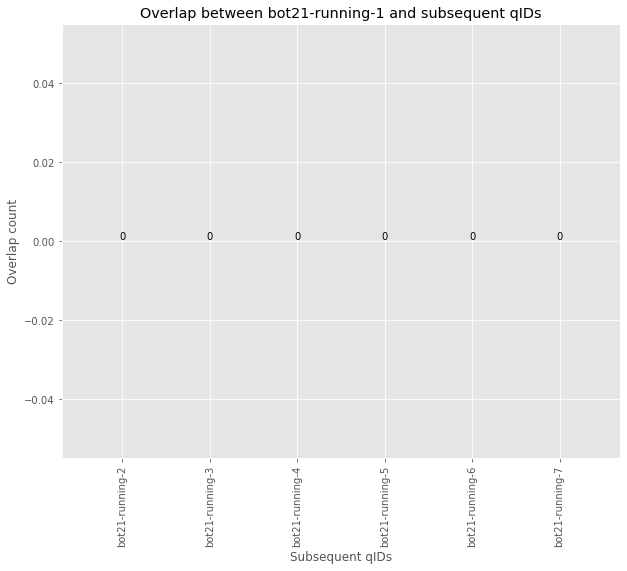

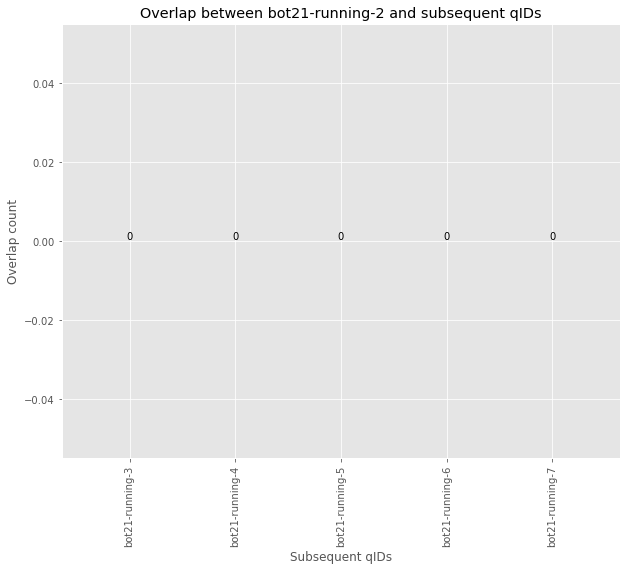

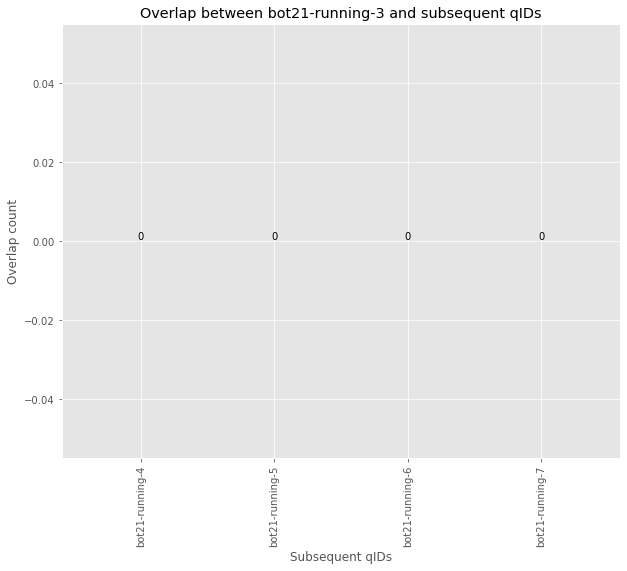

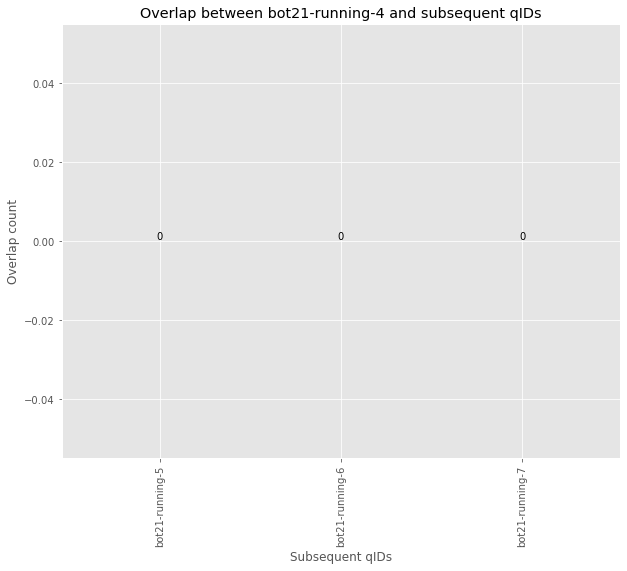

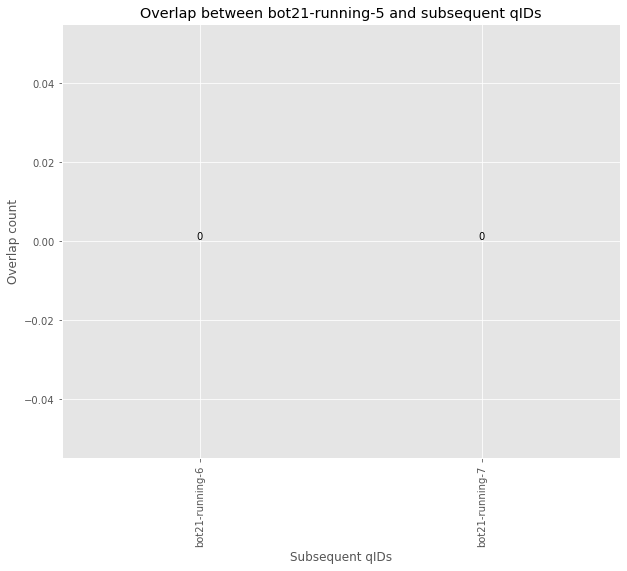

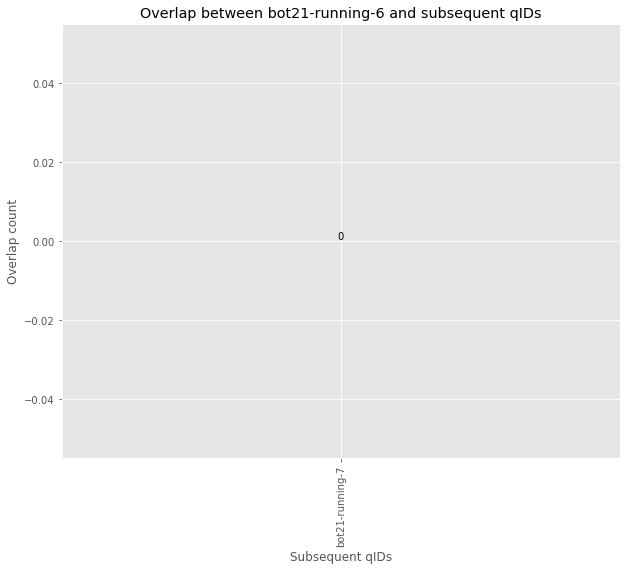

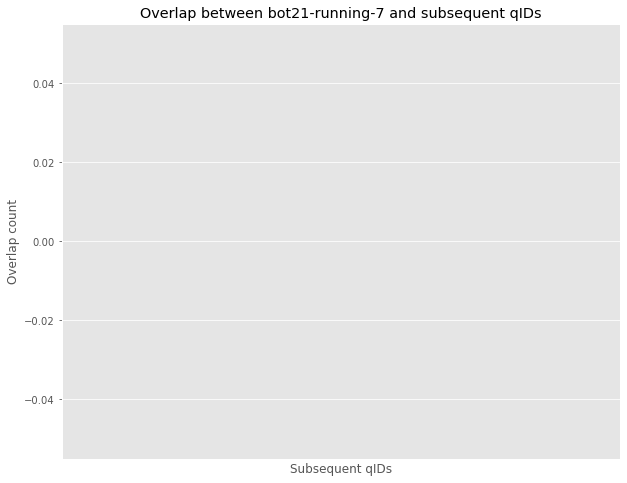

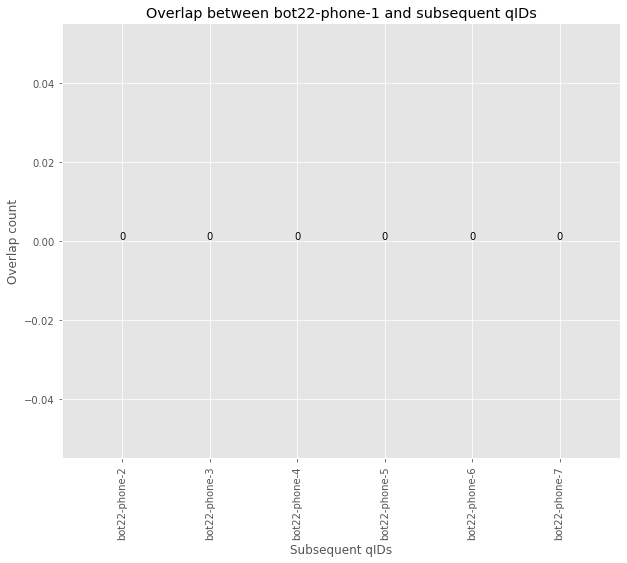

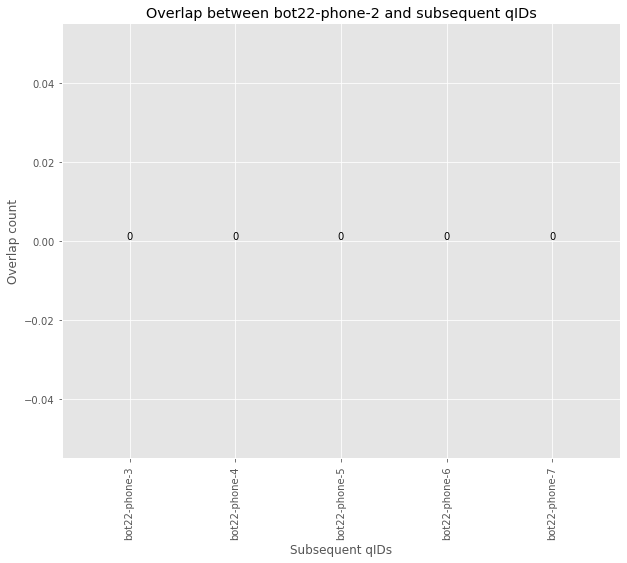

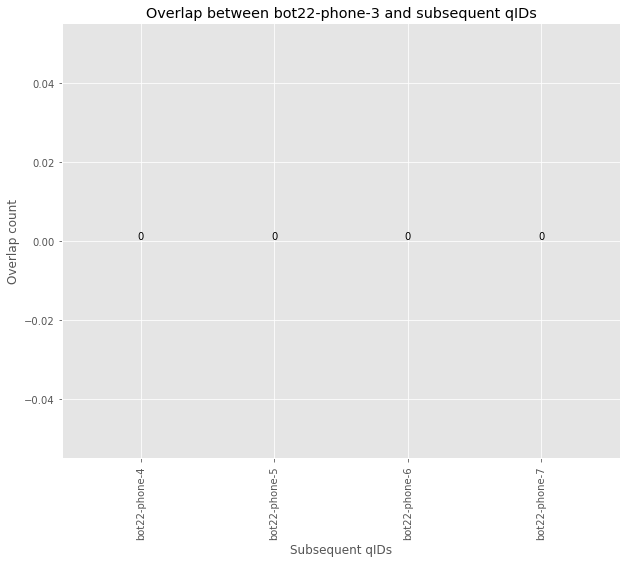

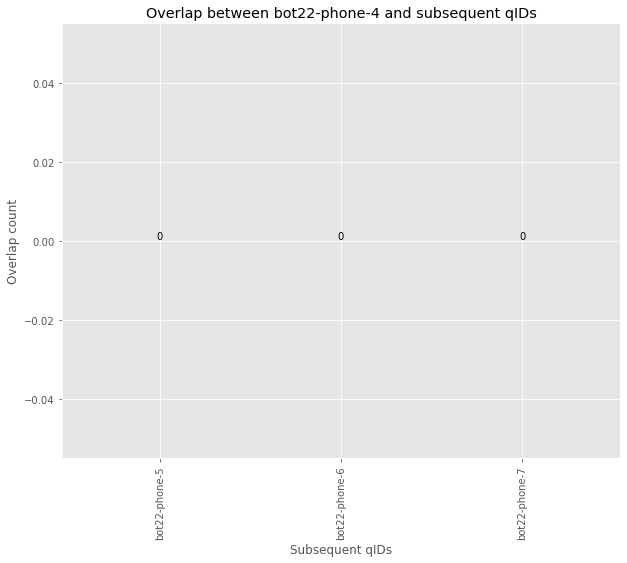

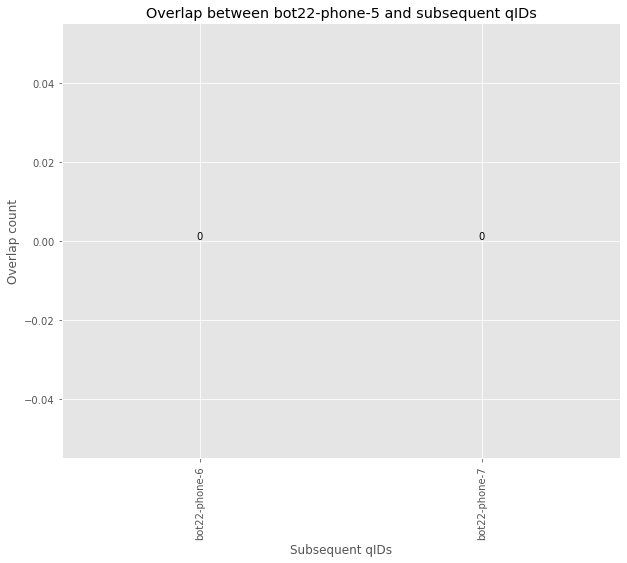

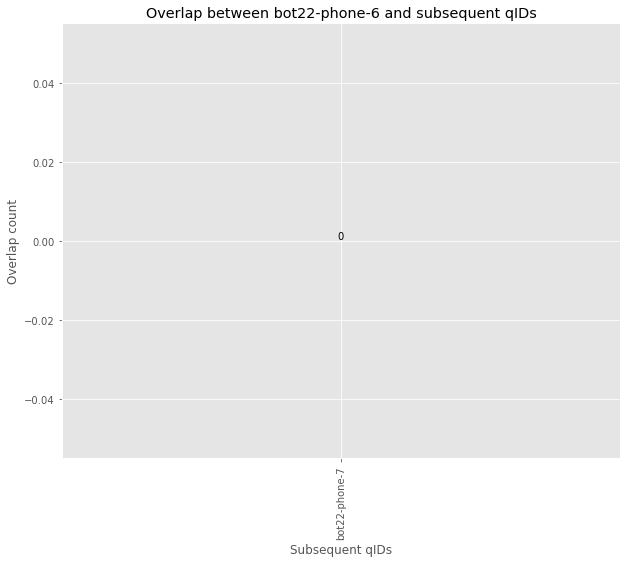

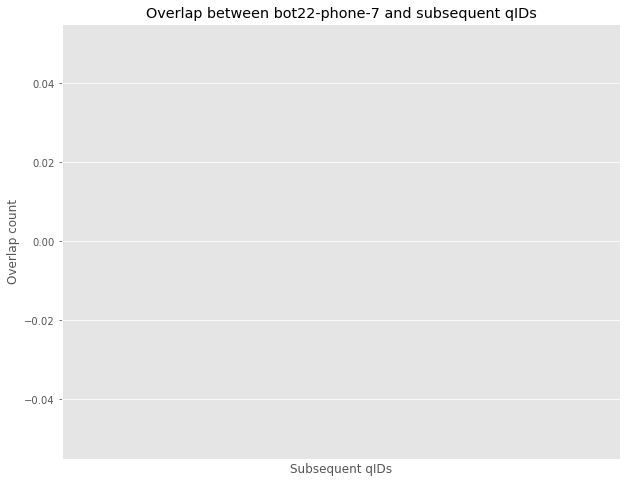

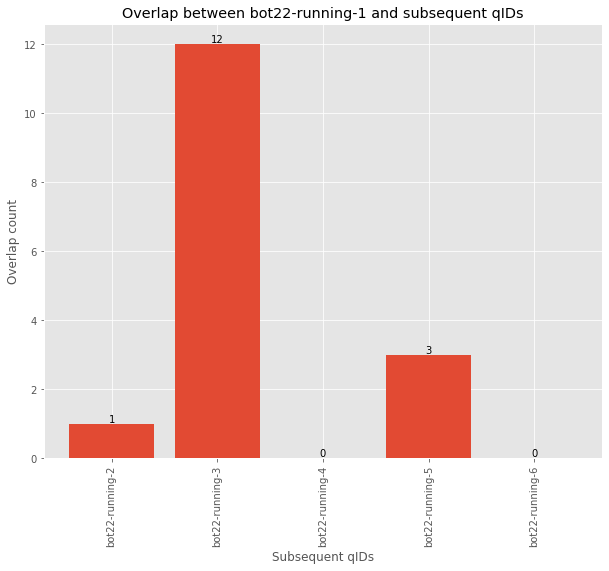

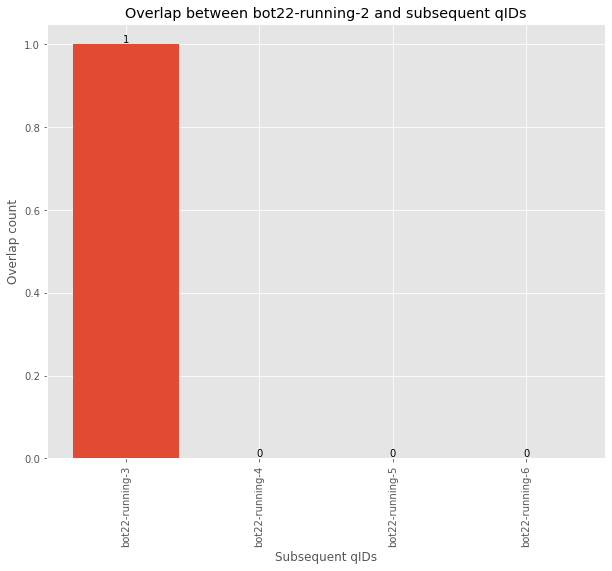

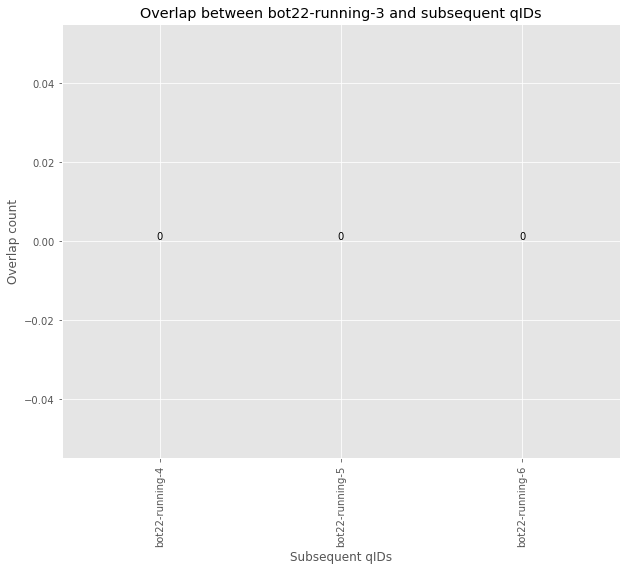

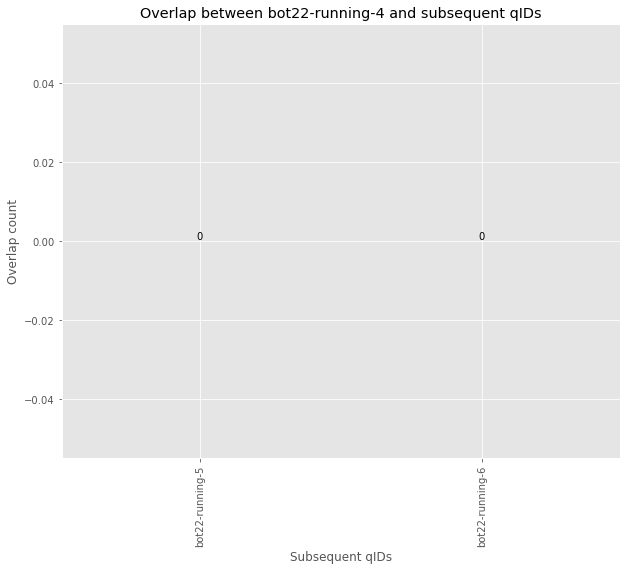

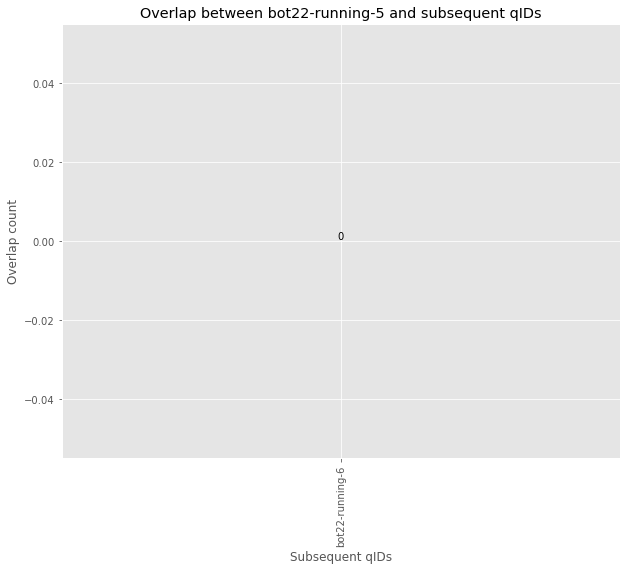

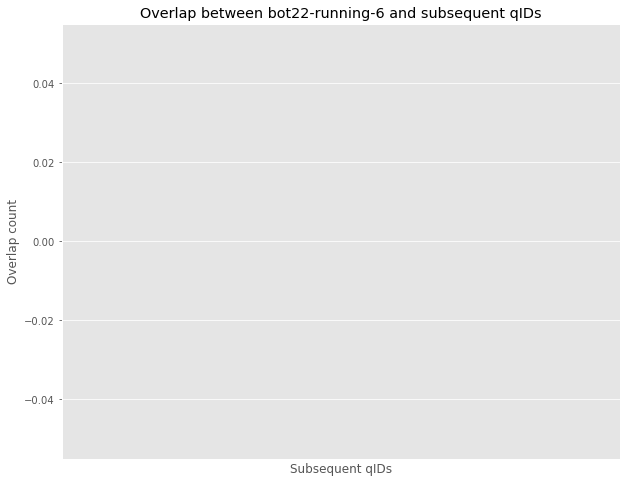

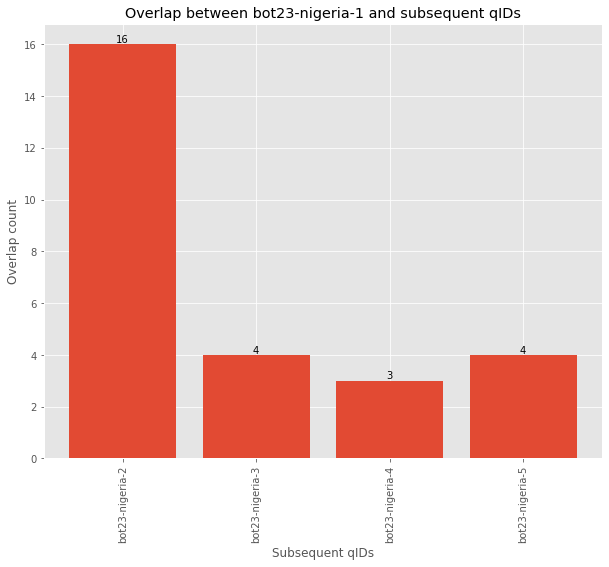

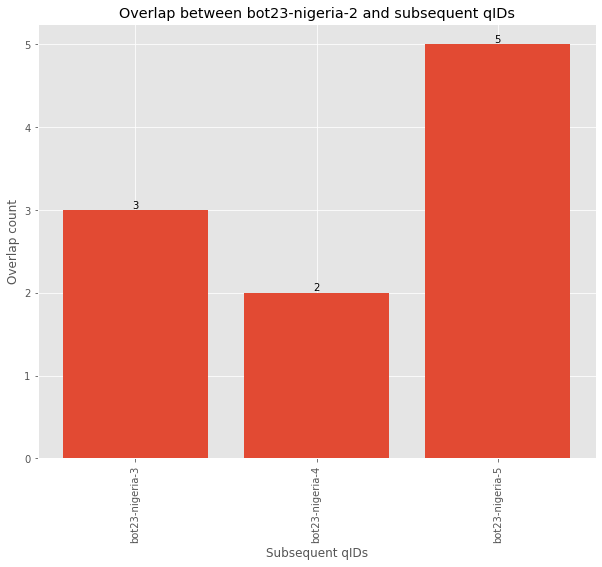

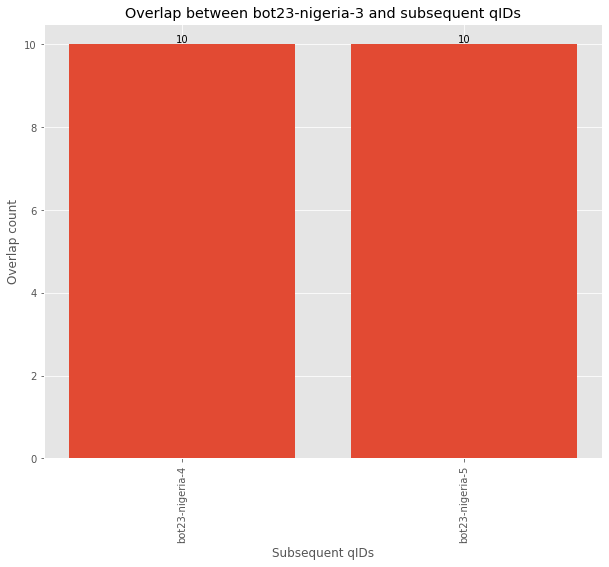

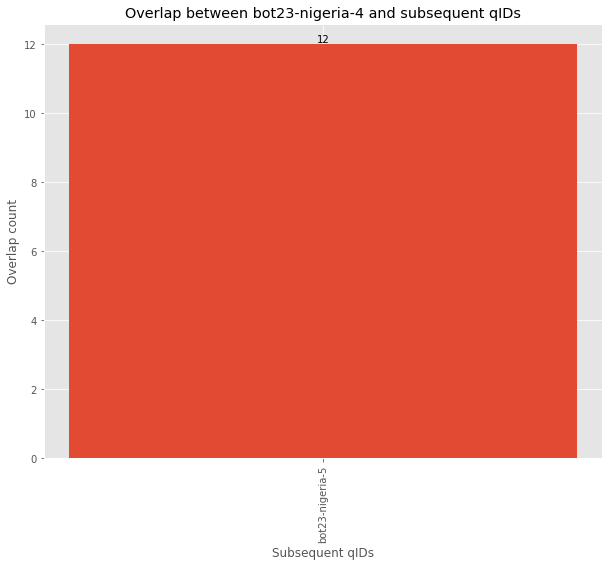

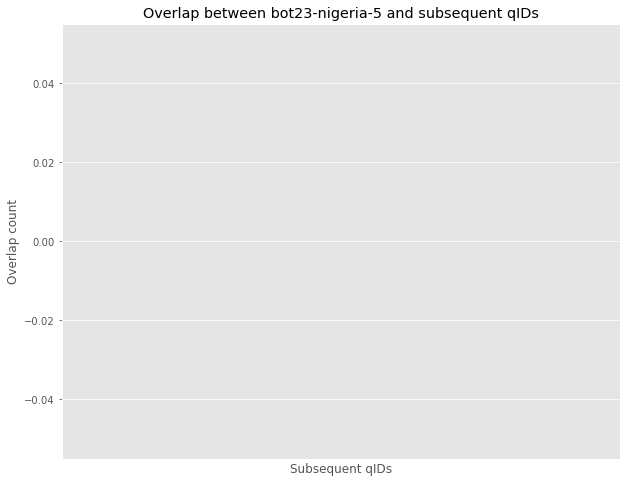

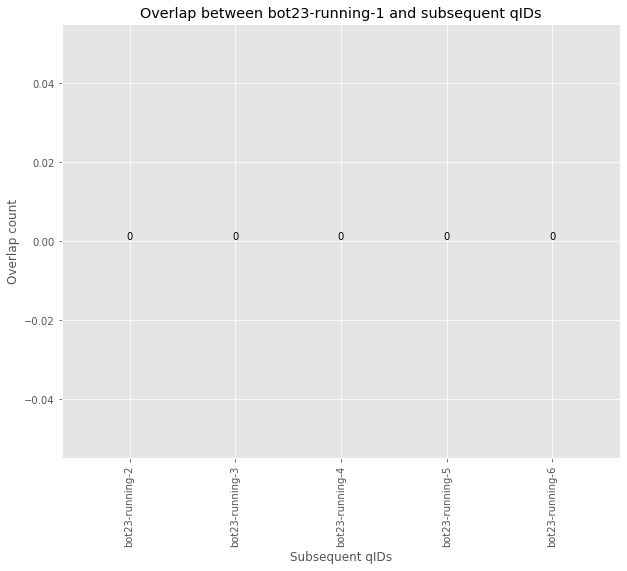

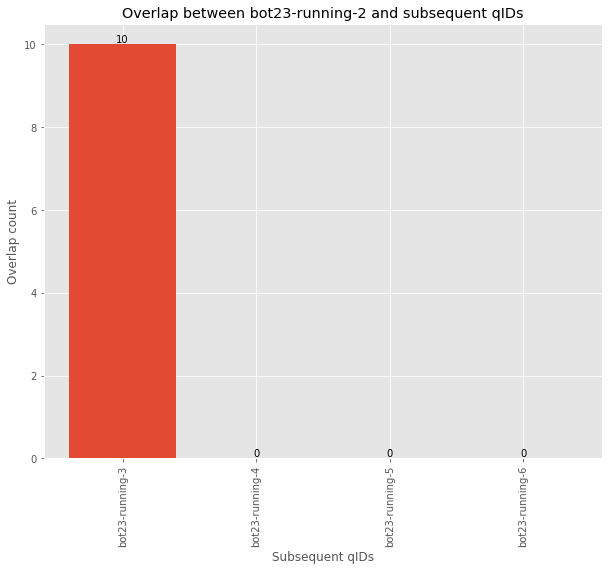

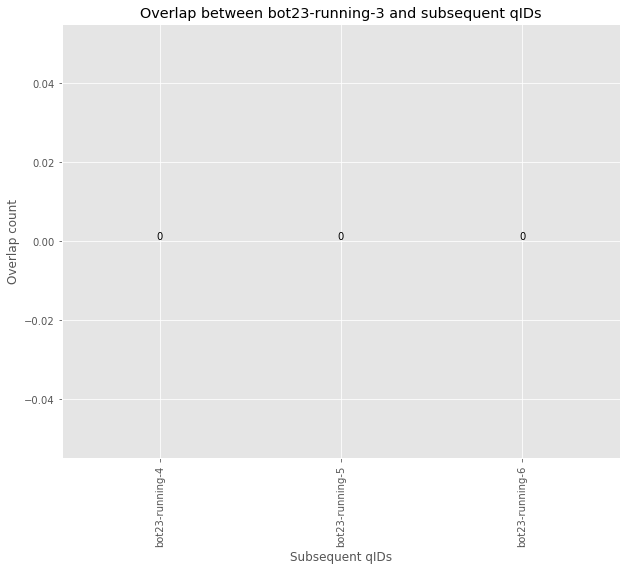

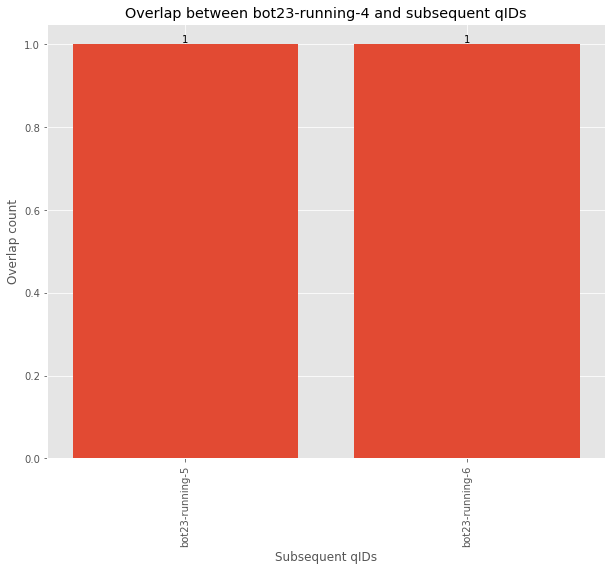

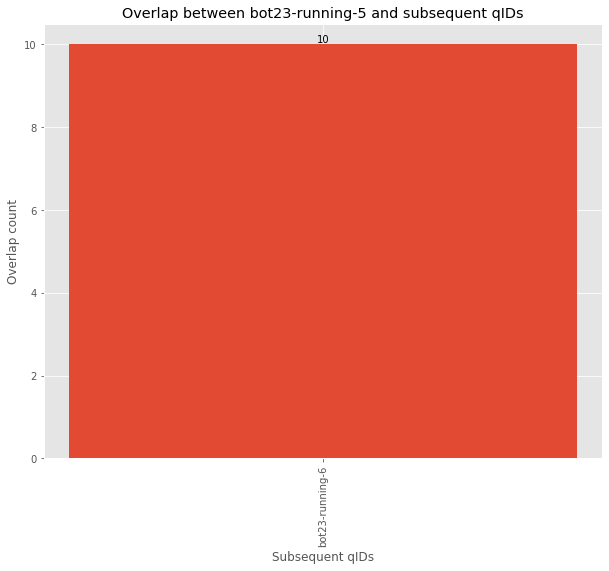

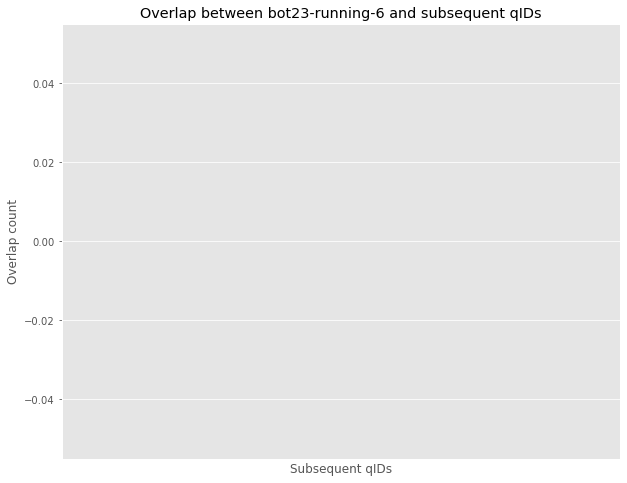

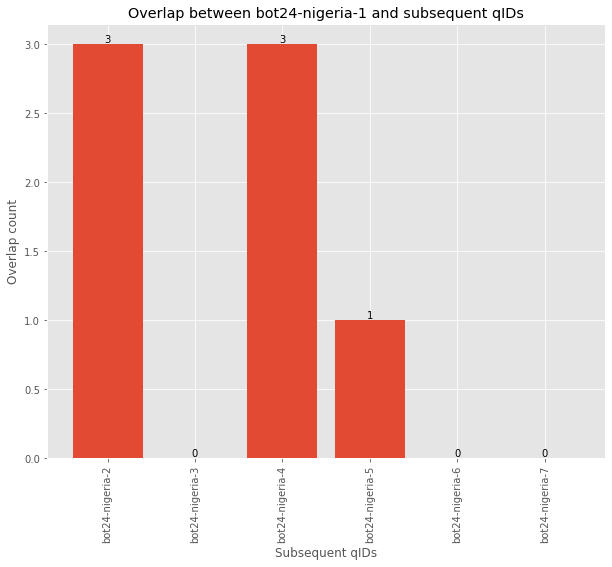

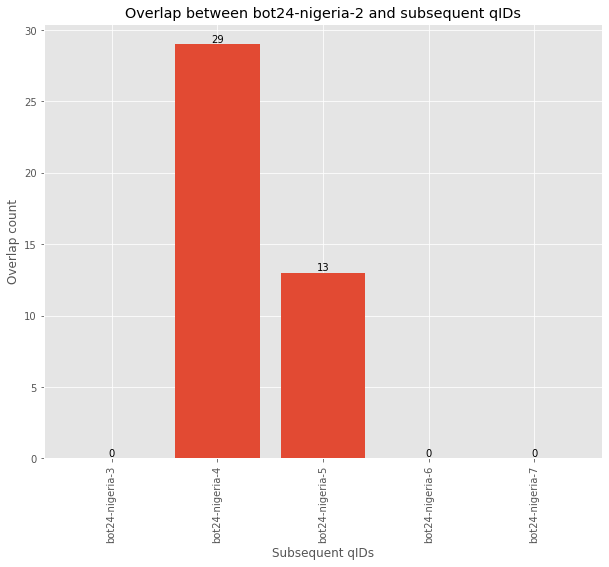

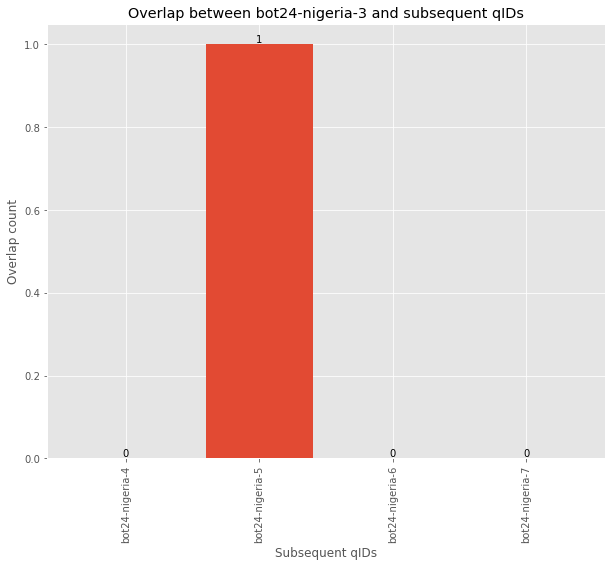

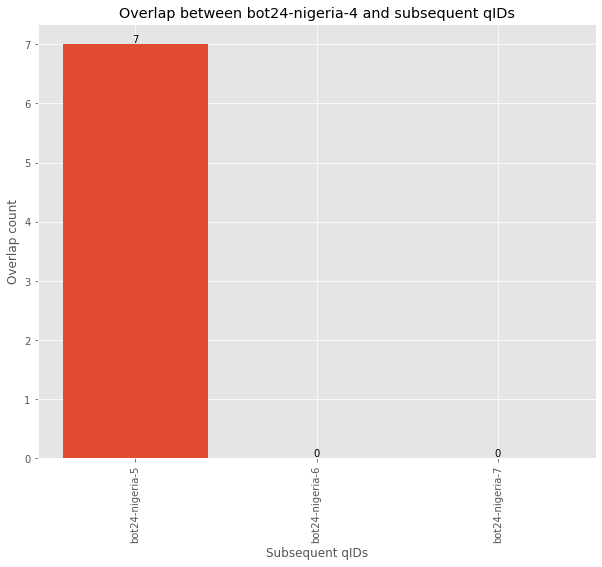

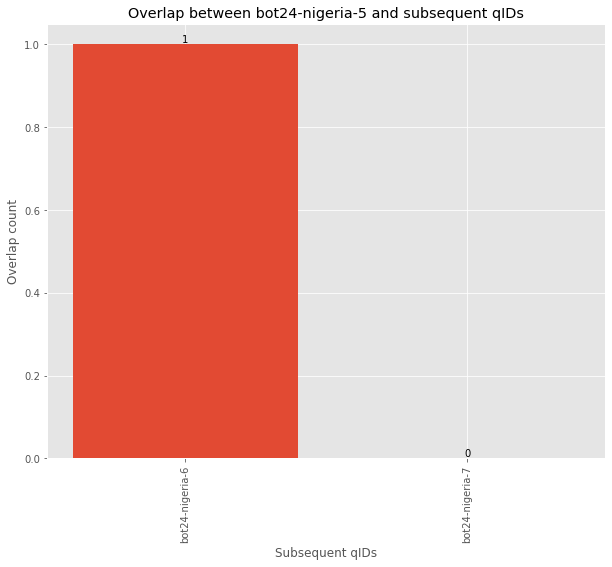

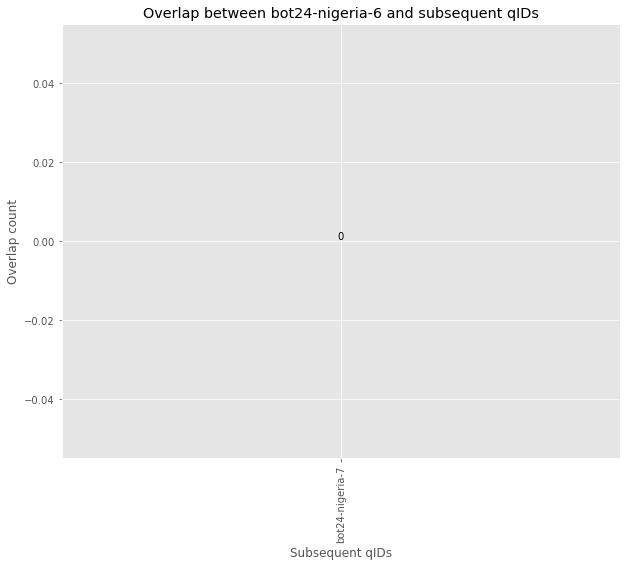

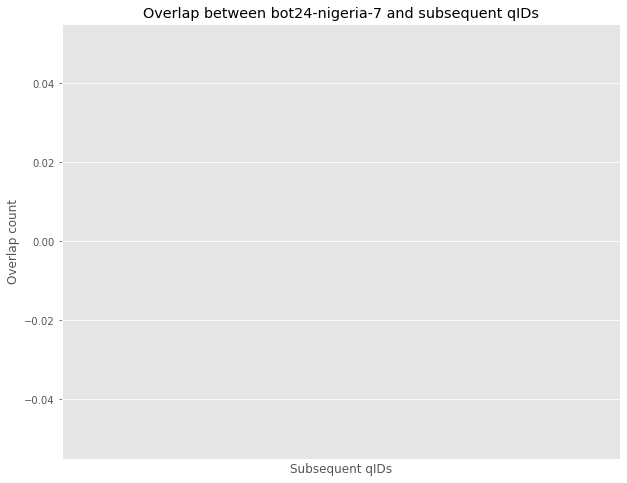

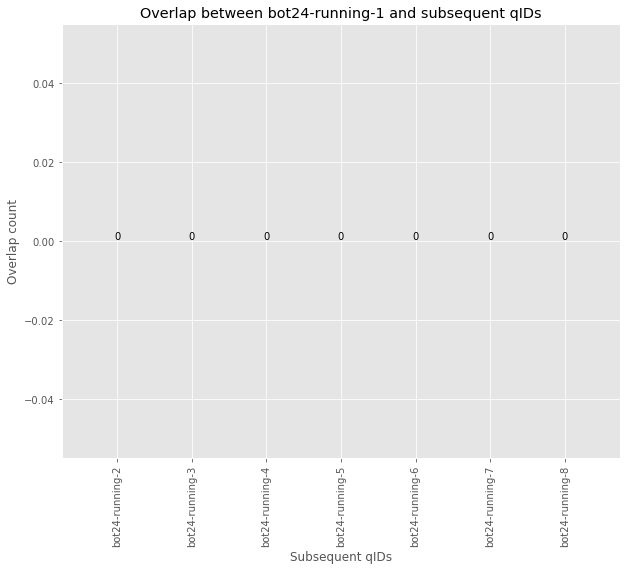

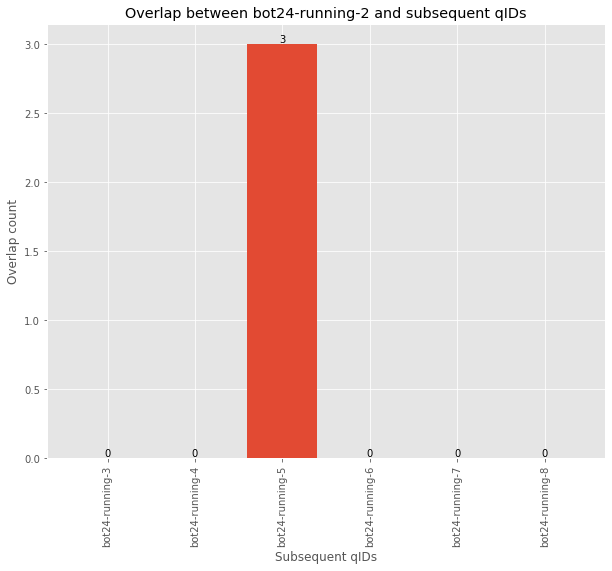

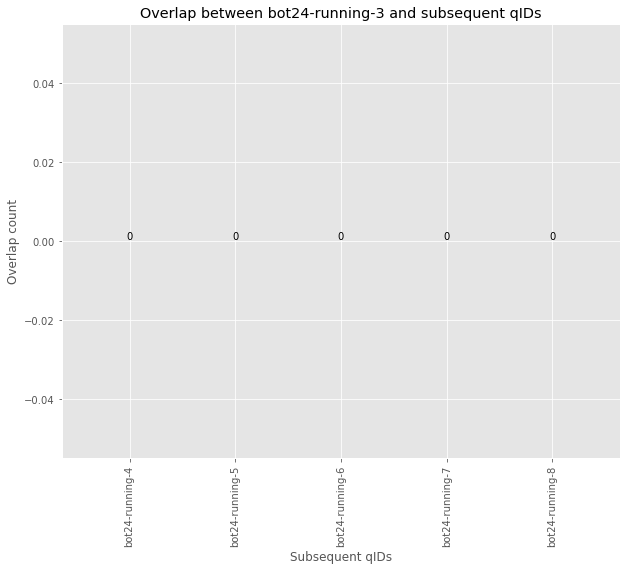

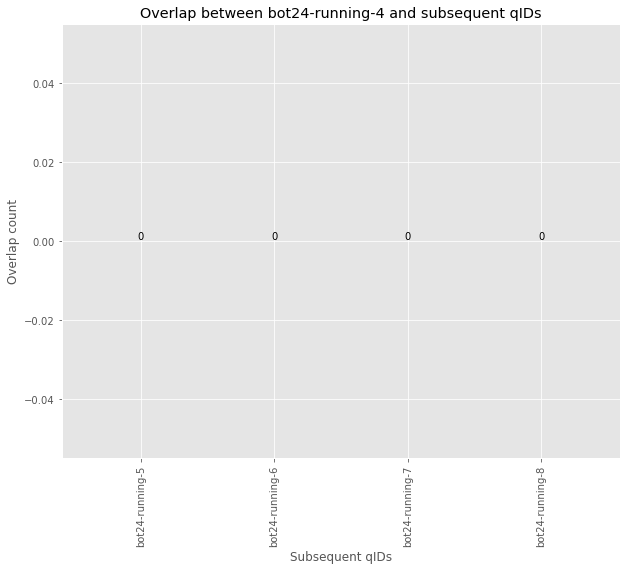

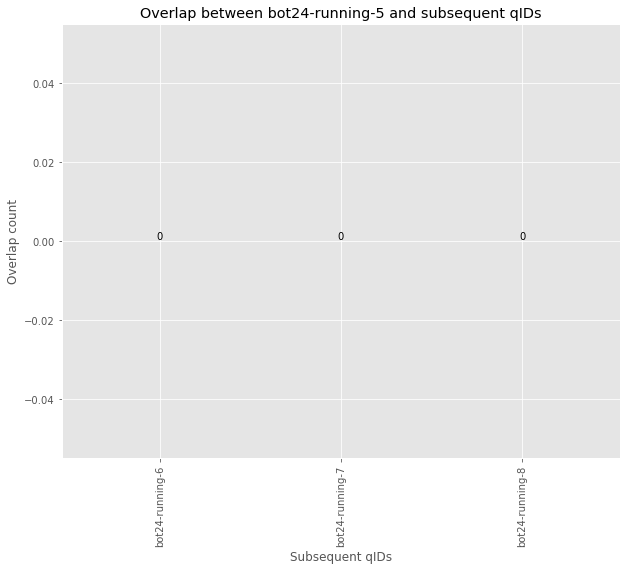

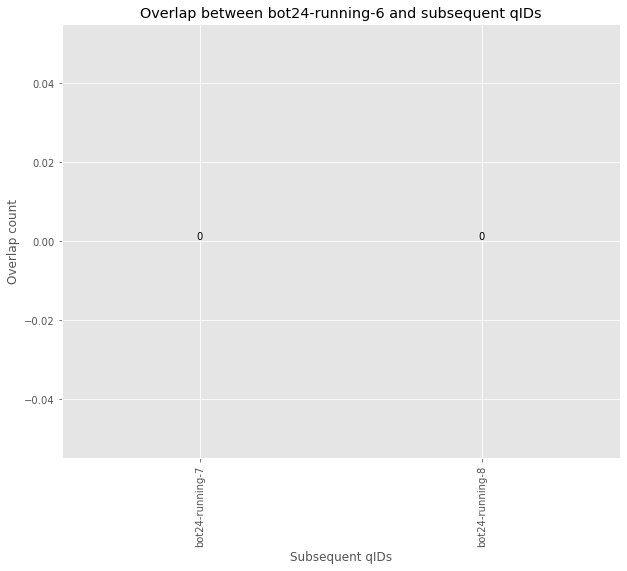

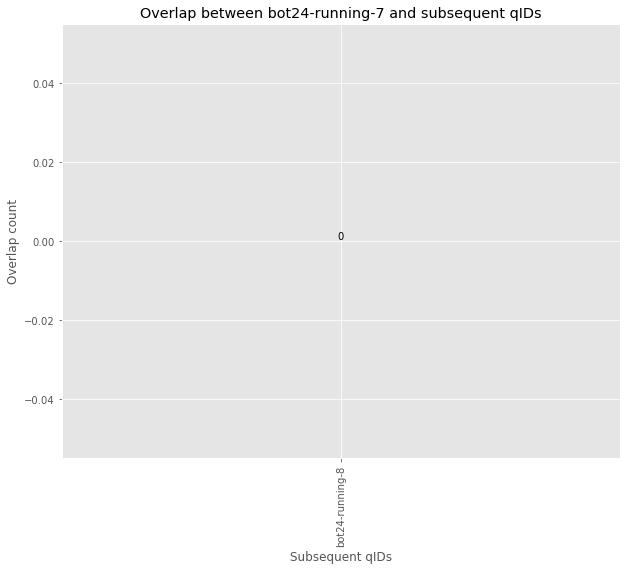

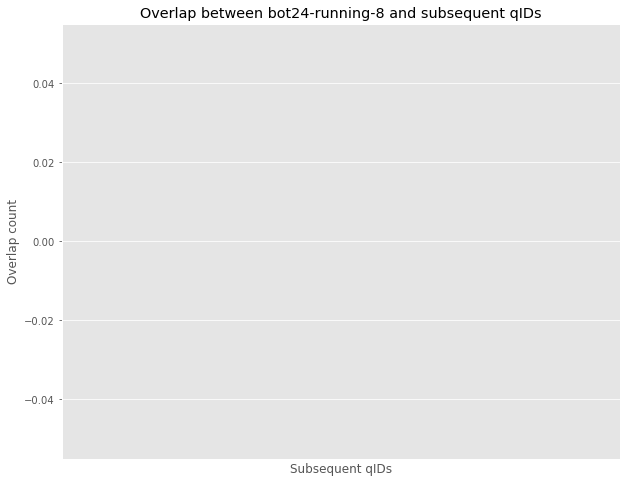

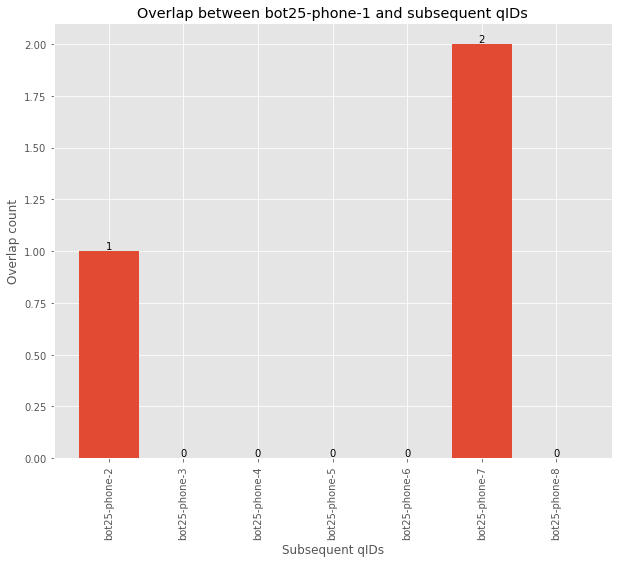

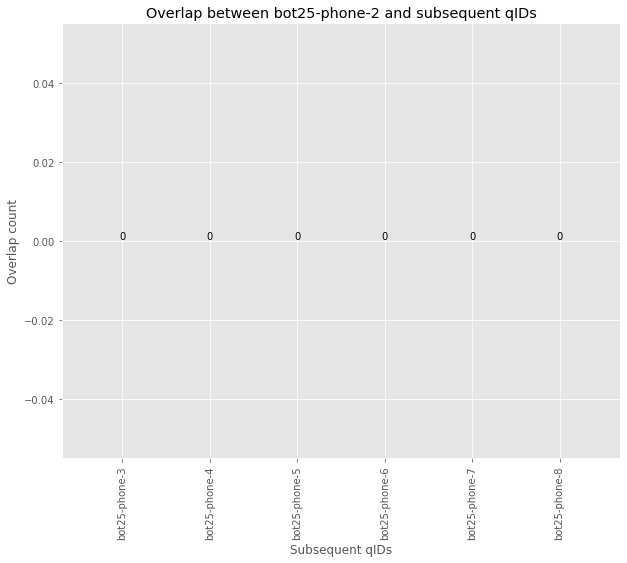

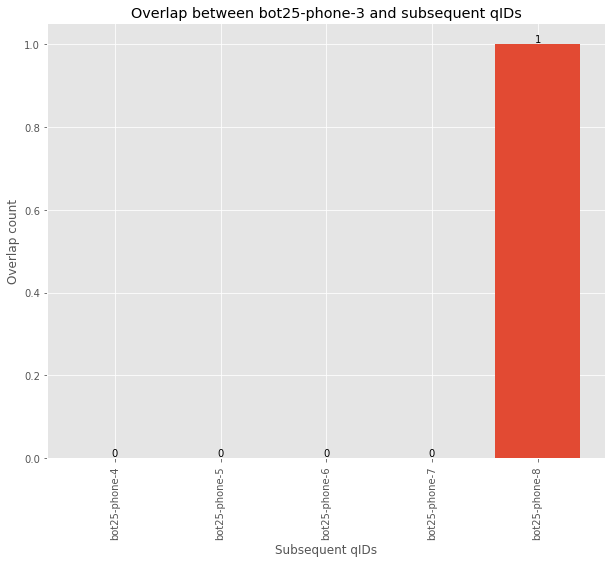

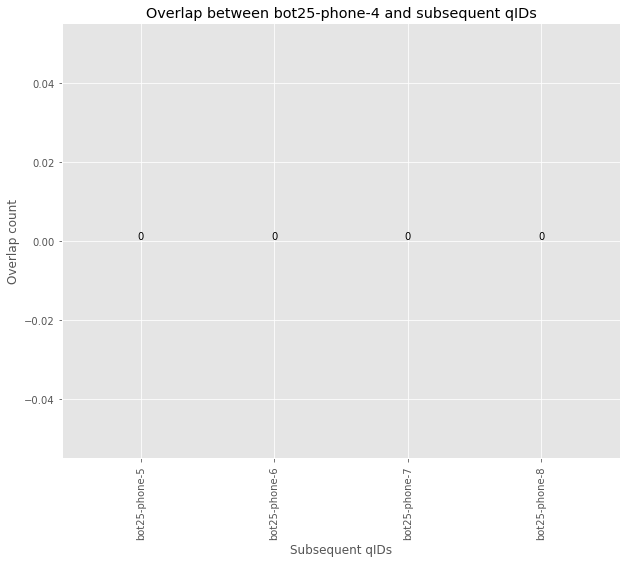

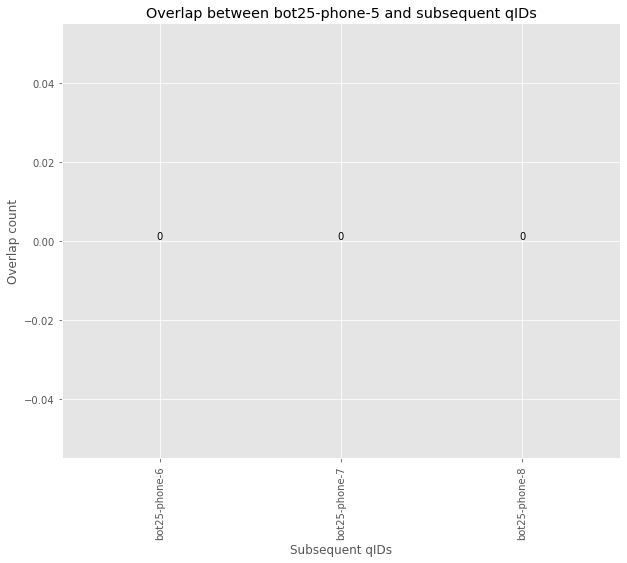

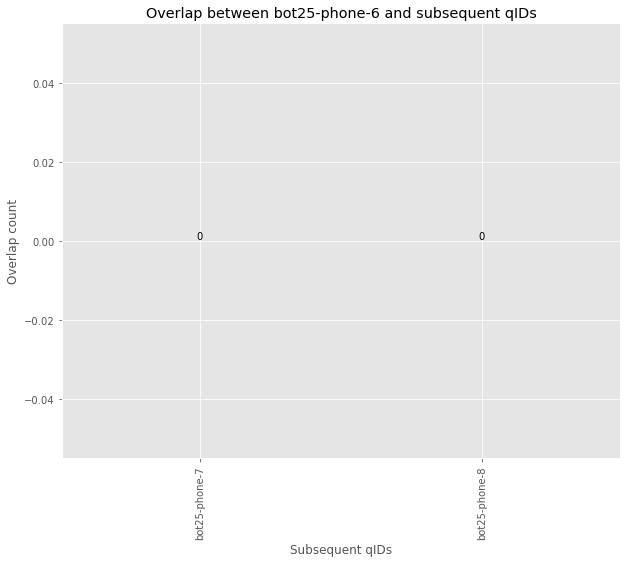

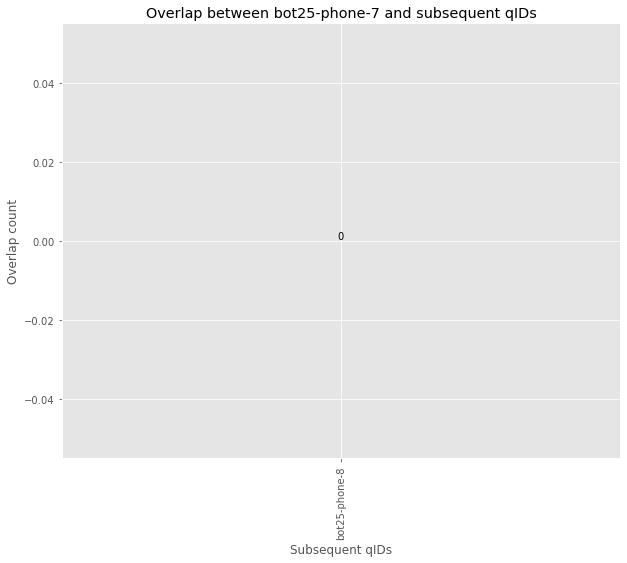

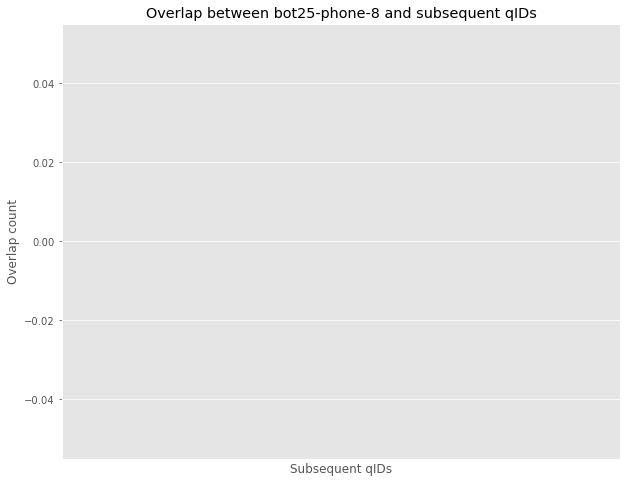

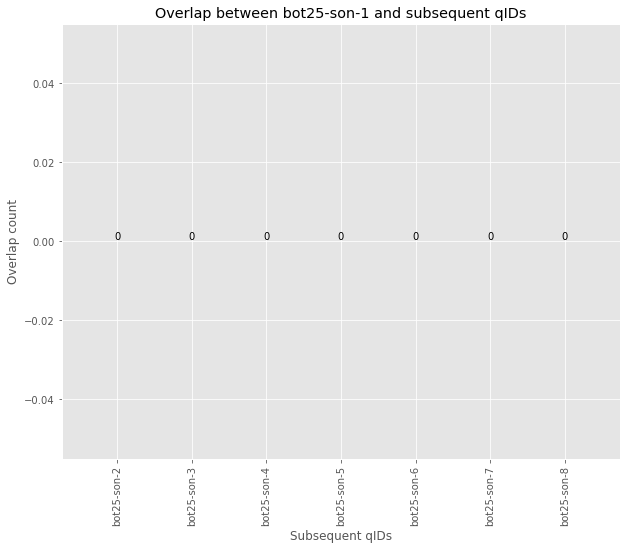

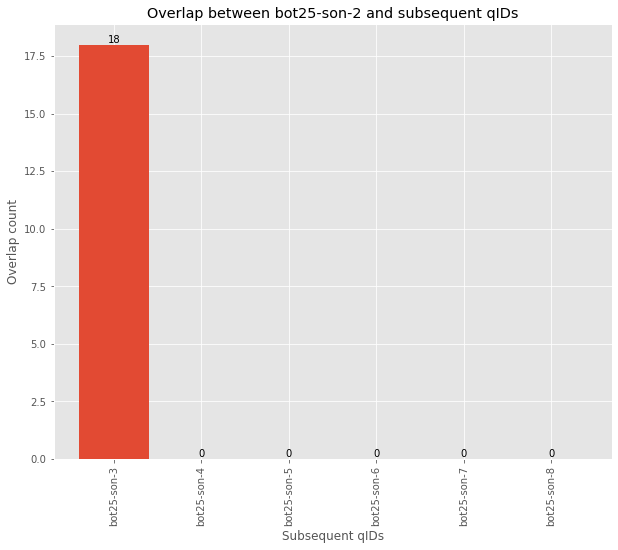

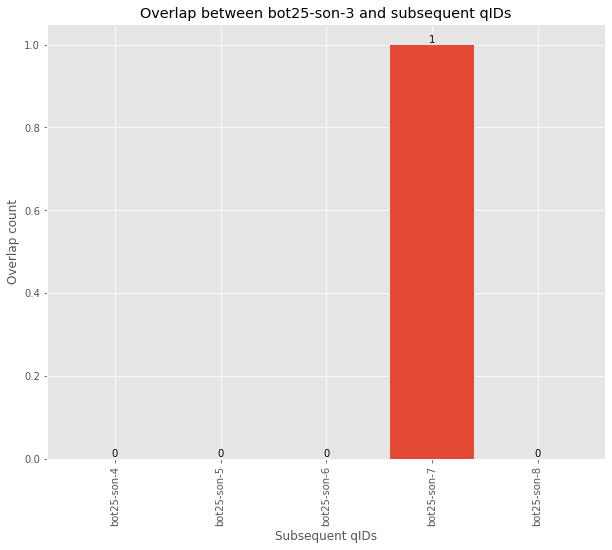

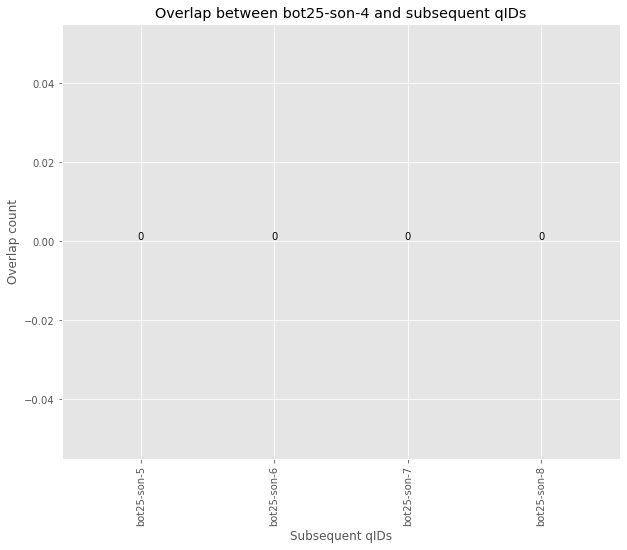

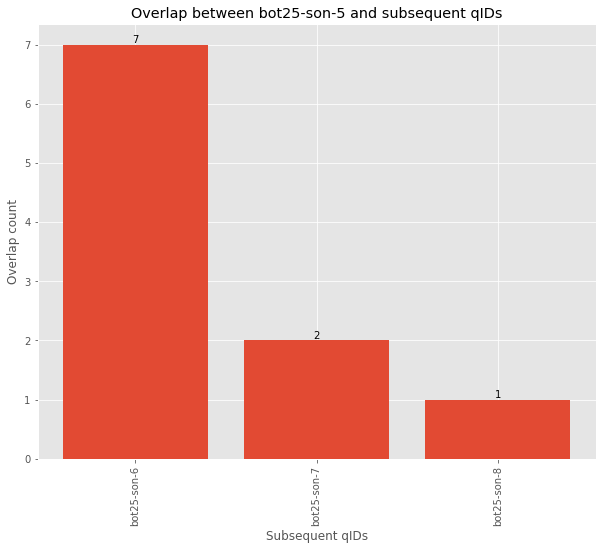

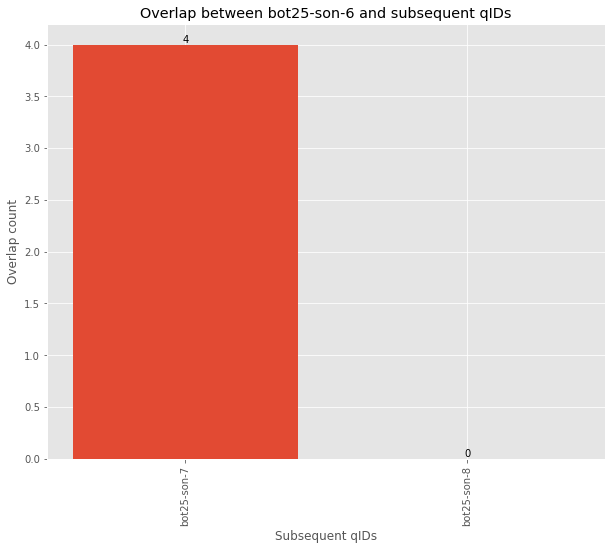

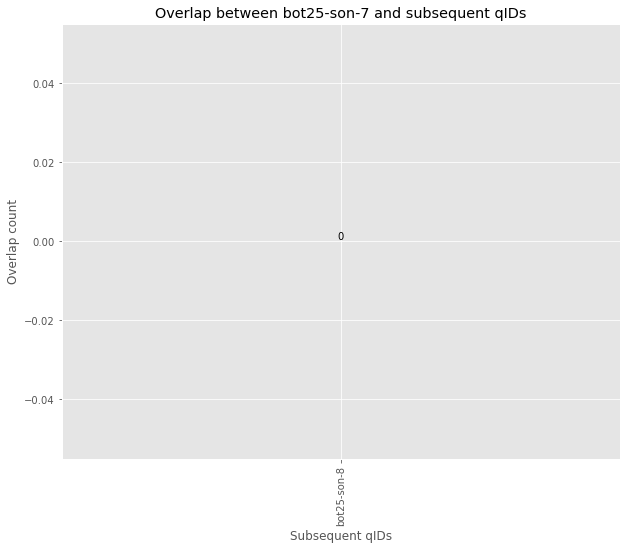

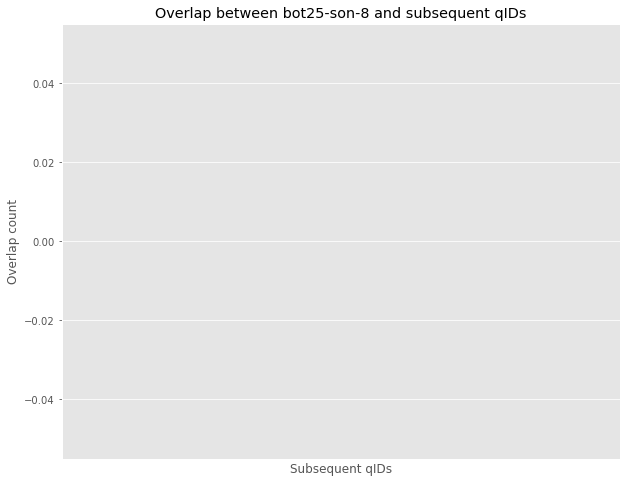

In [279]:
## plotting the previous result.

import matplotlib.pyplot as plt
import numpy as np

# loop through unique qIDs
for i, qid1 in enumerate(doc_lists_df['qID'].unique()):
    # create empty lists to store x, y, and label values for current qID
    x_labels = []
    y_vals = []

    # loop through subsequent qIDs with the same prefix
    for qid2 in doc_lists_df['qID'].unique()[i+1:]:
        if qid2.startswith(qid1[:-1]):
            # get document lists for qID1 and qID2
            doc_list1 = list(set(doc_lists_df.loc[doc_lists_df['qID']==qid1, 'docList'].iloc[0][:100])) ### choose here the number of doc
            doc_list2 = list(set(doc_lists_df.loc[doc_lists_df['qID']==qid2, 'docList'].iloc[0][:100])) ### choose here the number of doc
            # count overlapping documents
            overlap_count = len(set(doc_list1).intersection(set(doc_list2)))
            
            # append values to lists
            x_labels.append(qid2)
            y_vals.append(overlap_count)

    # create bar chart for current qID
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(np.arange(len(y_vals)), y_vals)

    # add labels to x-axis ticks
    ax.set_xticks(np.arange(len(y_vals)))
    ax.set_xticklabels(x_labels, rotation=90)

    # add bar values
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, height, ha='center', va='bottom')

    # add axes labels and title
    ax.set_xlabel('Subsequent qIDs')
    ax.set_ylabel('Overlap count')
    ax.set_title(f'Overlap between {qid1} and subsequent qIDs')
    
    plt.show()



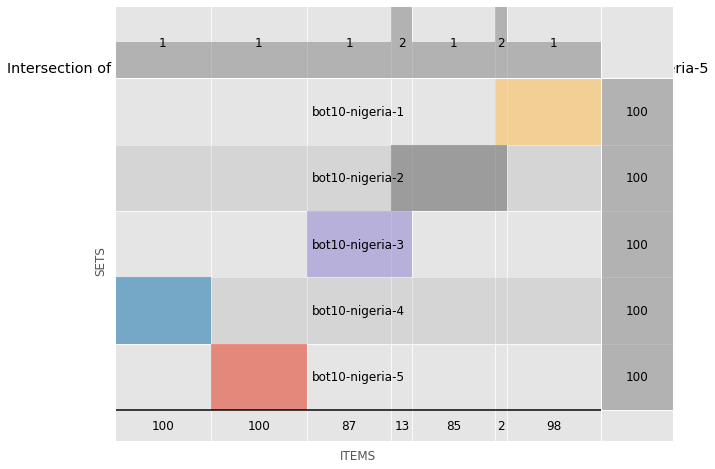

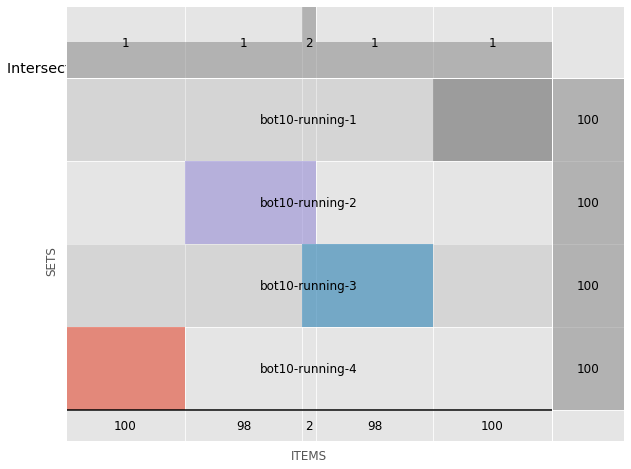

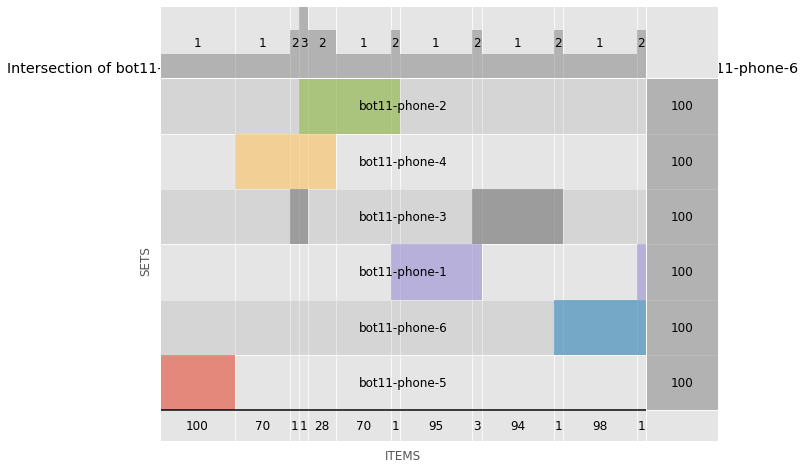

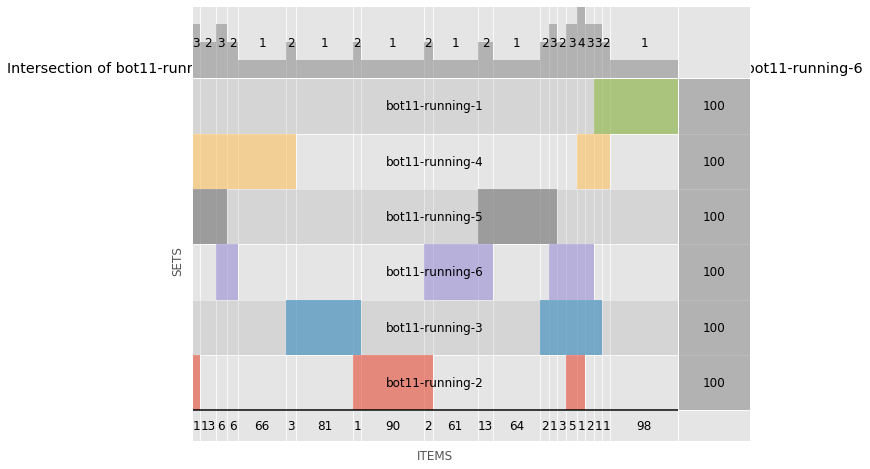

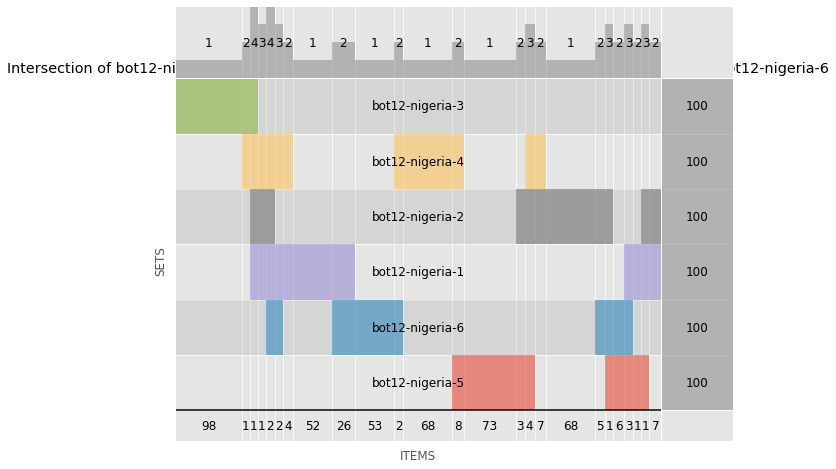

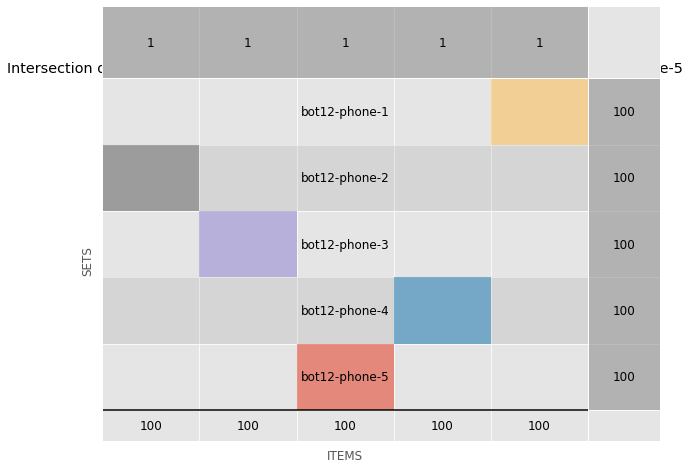

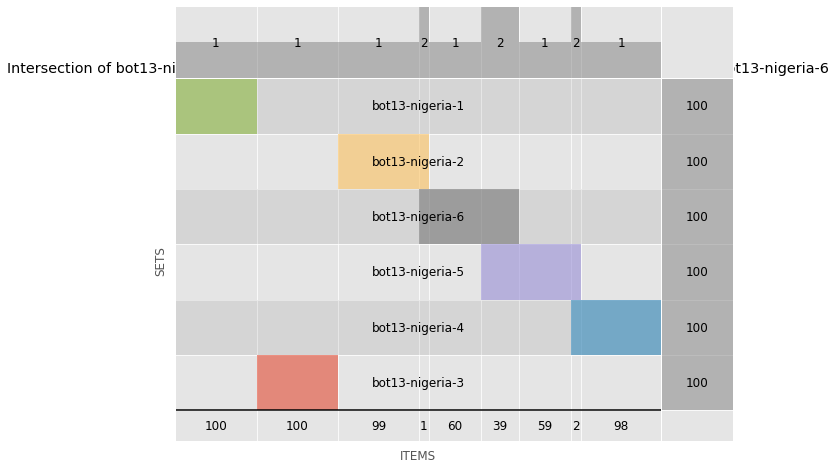

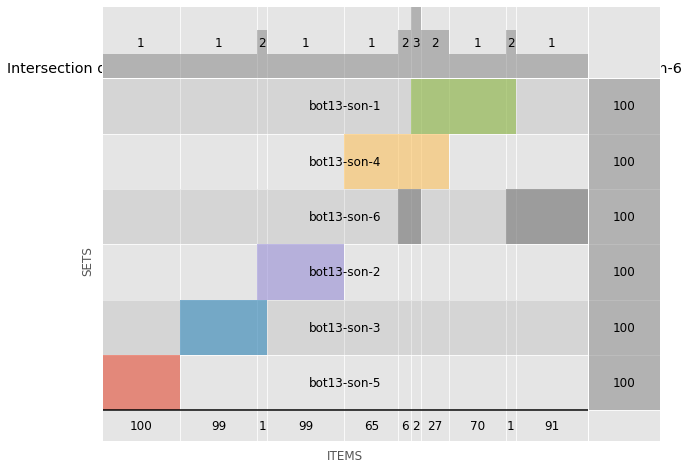

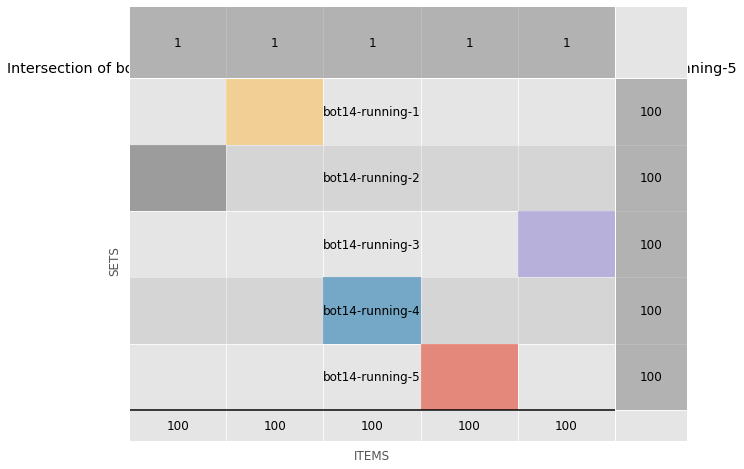

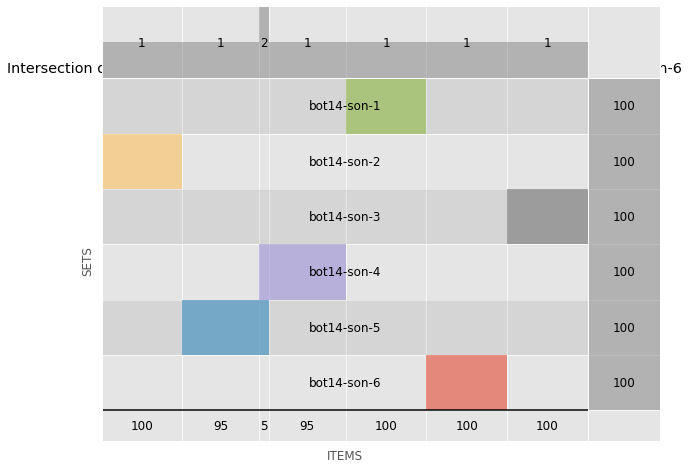

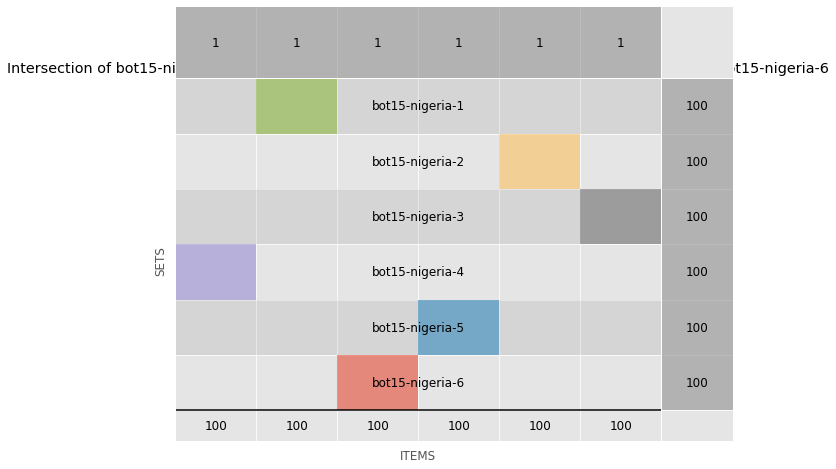

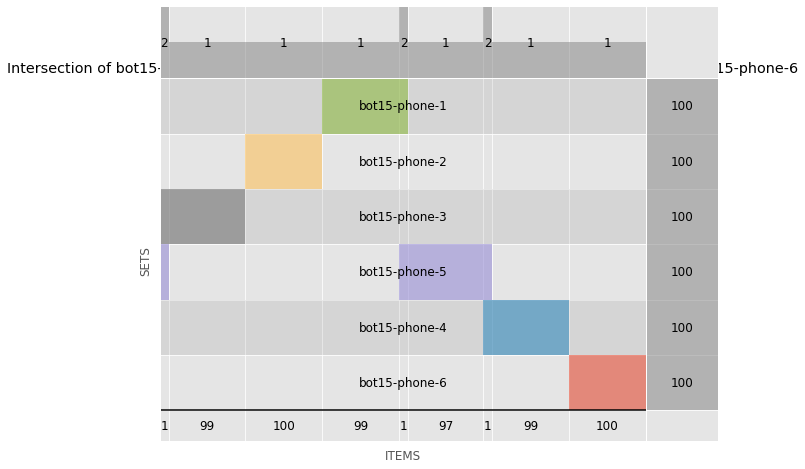

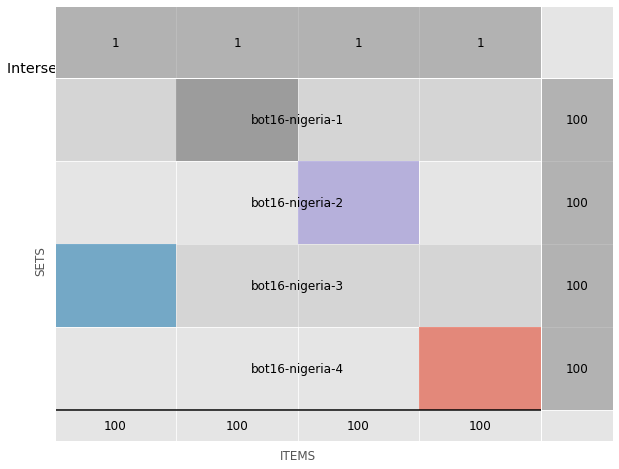

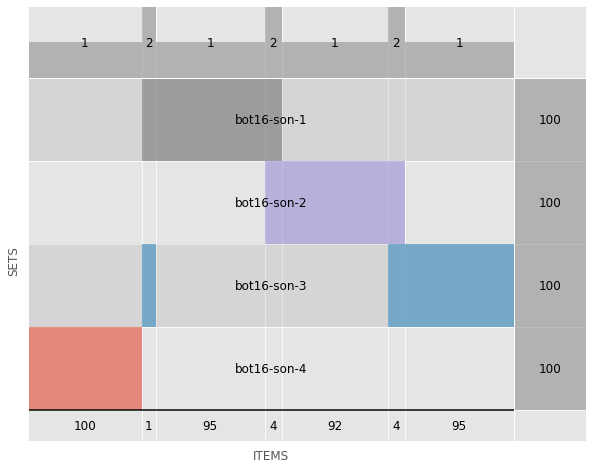

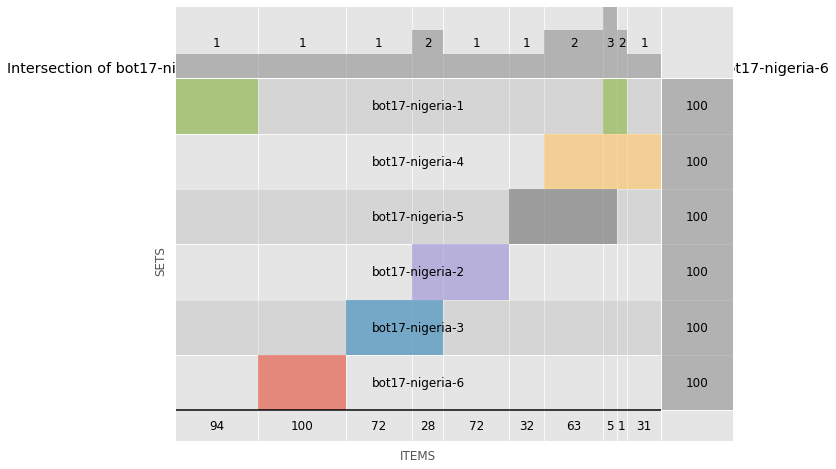

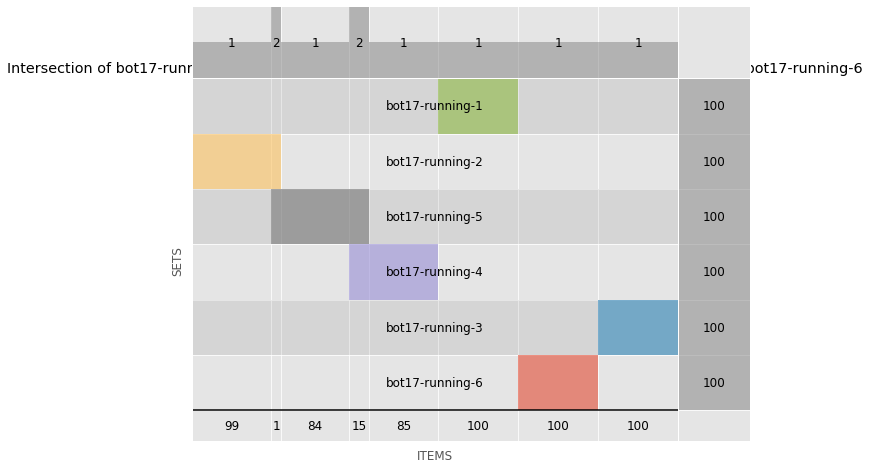

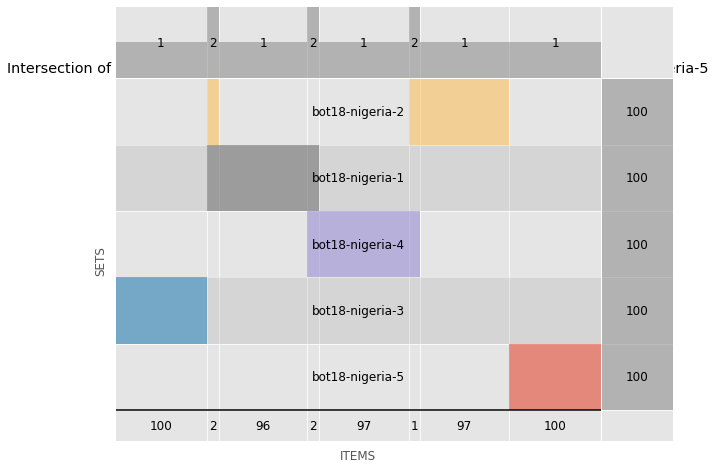

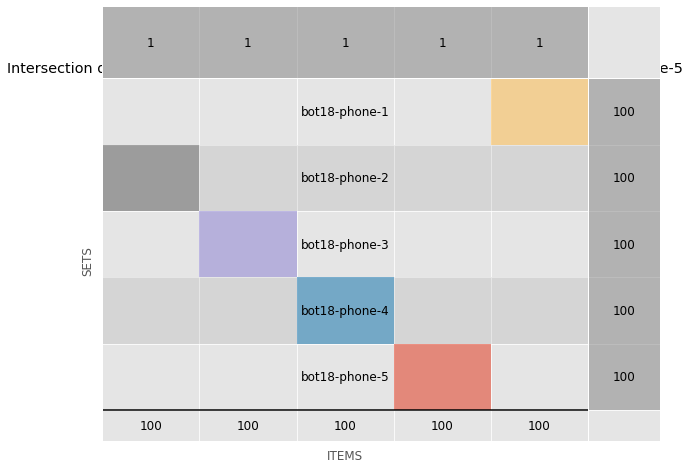

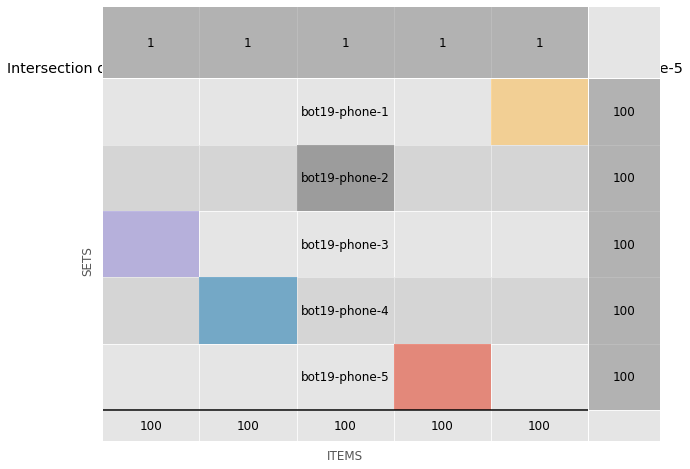

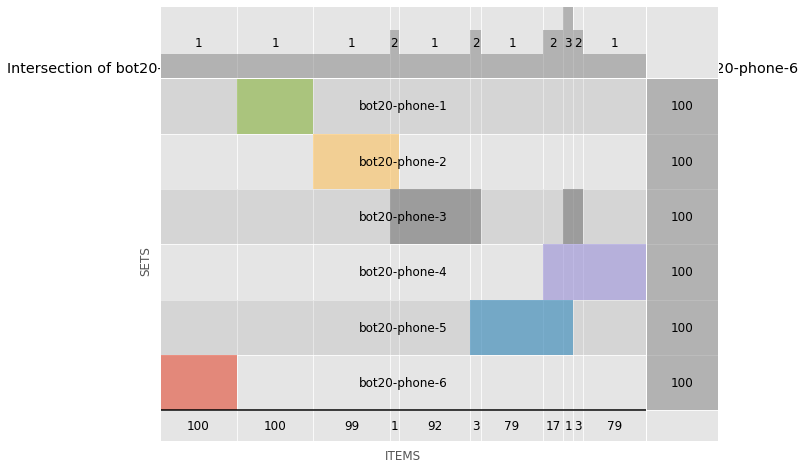

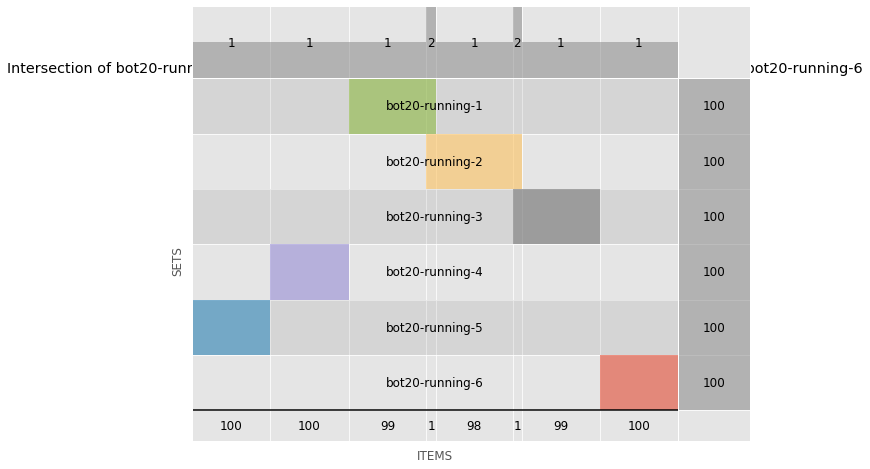

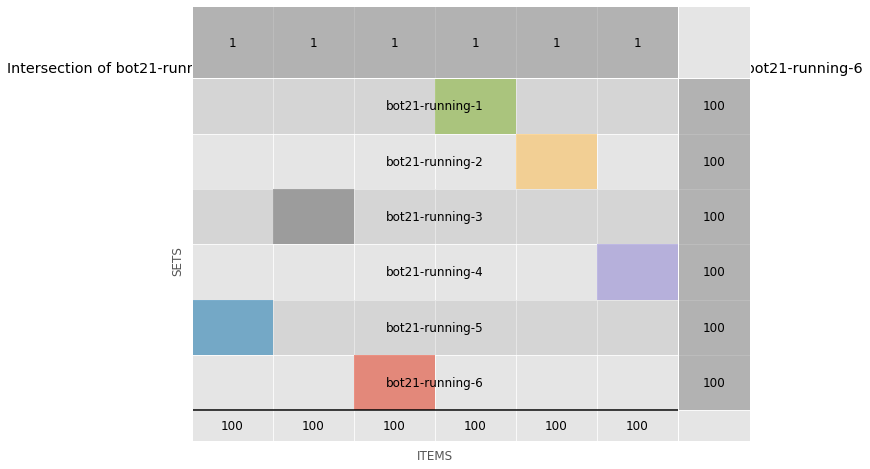

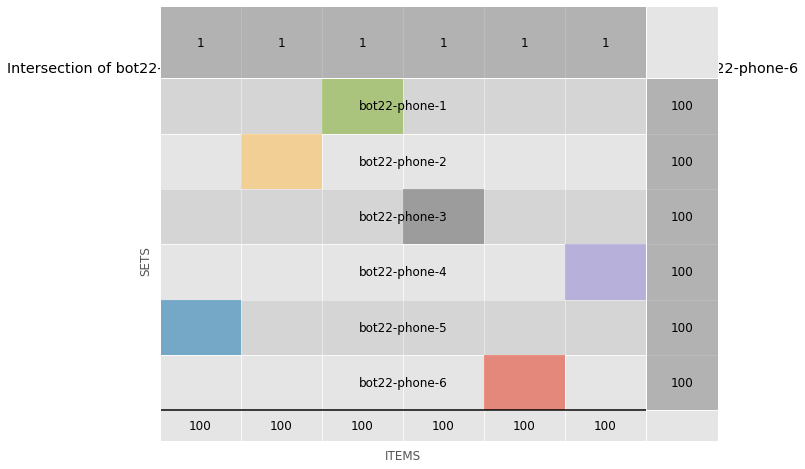

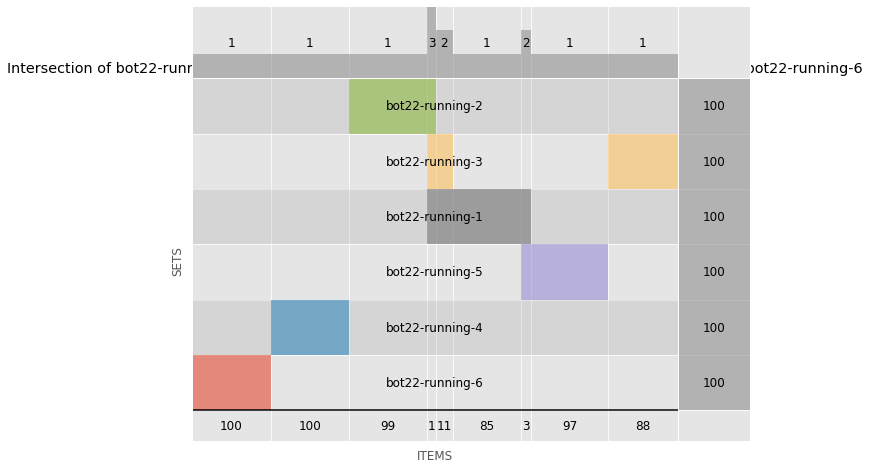

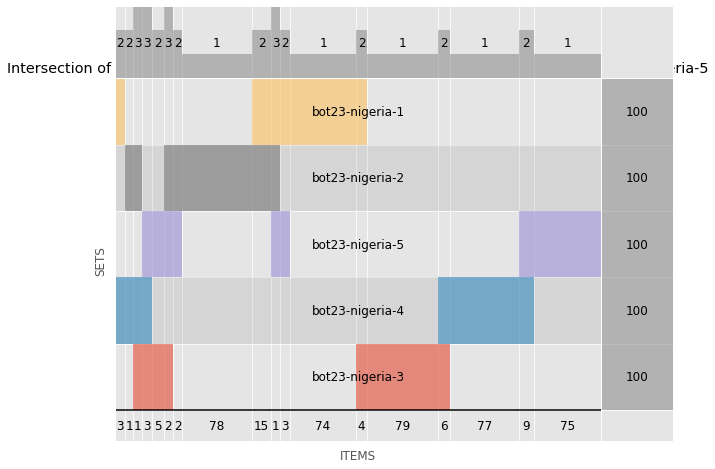

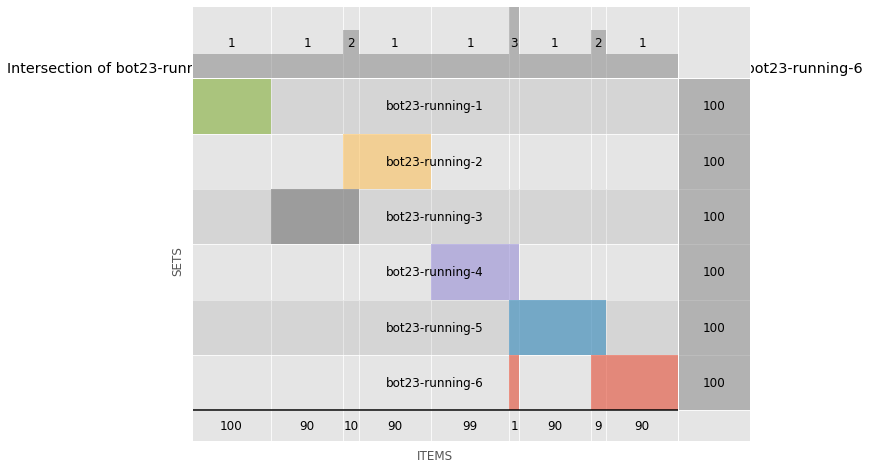

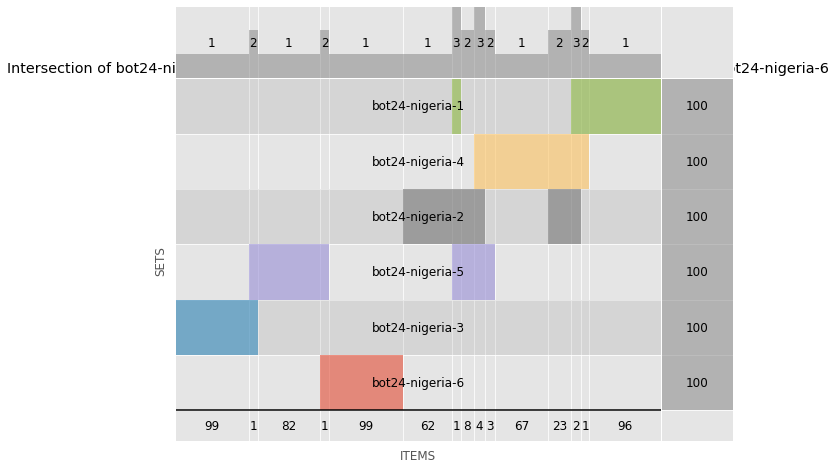

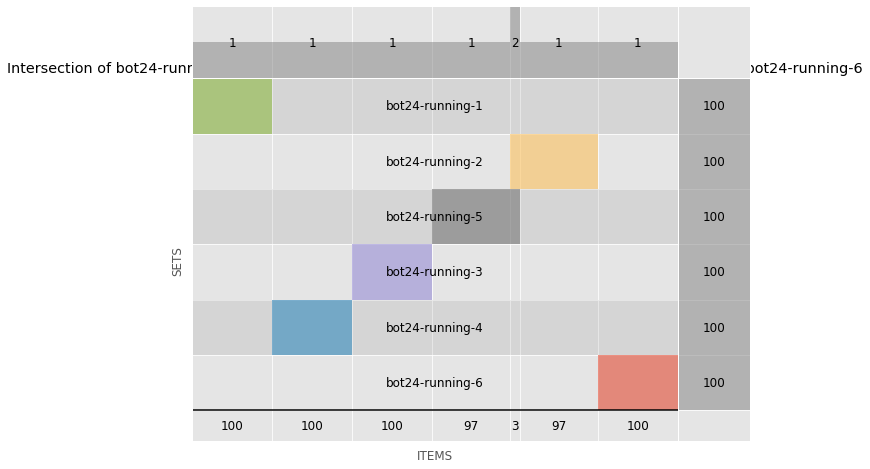

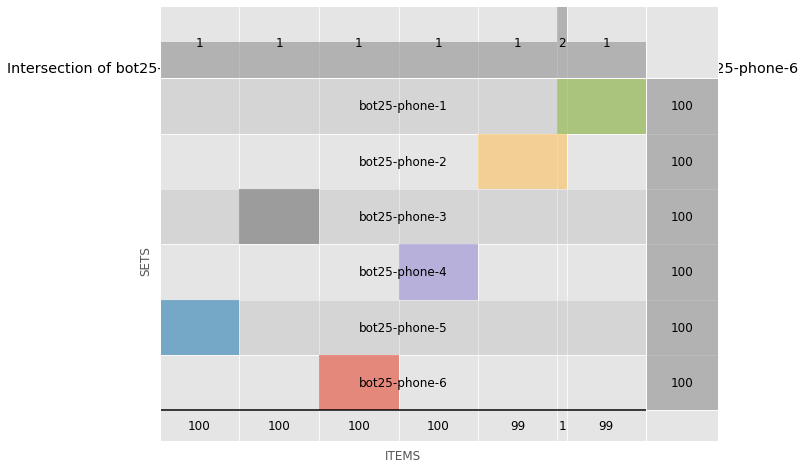

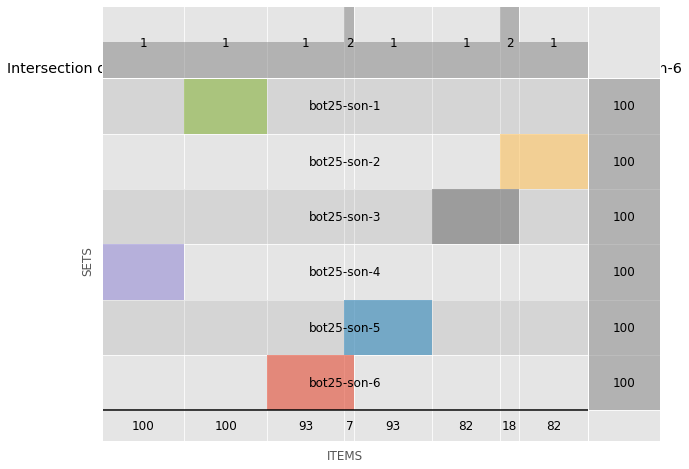

In [299]:
### with supervenn we can see an overview of the overlapp between all turns of a topic for each user. 
# https://github.com/gecko984/supervenn

from supervenn import supervenn
from matplotlib import pyplot as plt

# Iterate through the qID column and find identical qID until the second last character
# I can change until wich turn I want to consider (1,7)
# I can also choose how many documents per list I want to consider 

qID_groups = {}
for qID in doc_lists_df['qID']:
    last_char = qID[-1]
    if last_char.isdigit() and int(last_char) in range(1, 7):           #### to choose until which turn 
        qID_prefix = qID[:-2]
        if qID_prefix not in qID_groups:
            qID_groups[qID_prefix] = []
        qID_groups[qID_prefix].append(qID)

# Create supervenn diagrams for each group of identical qID
for qID_prefix, qID_group in qID_groups.items():
    supervenn_data = []
    labels = []
    for qID in qID_group:
        doc_list = set(doc_lists_df[doc_lists_df['qID'] == qID]['docList'].iloc[0][:100]) ##### to choose how much document to consider per list
        supervenn_data.append(doc_list)
        labels.append(qID)

    fig, ax = plt.subplots(figsize=(10, 8))
    supervenn(supervenn_data, labels, side_plots=True, widths_minmax_ratio=0.12, sets_ordering='minimize gaps', ax=ax)
    plt.title(f'Intersection of {", ".join(qID_group)}')
    plt.show()


# How to read this plot:
# the upper line in grey show how many intersection with other set there are
# the right grey column show I many documents have each set analysed
# the bottom line  show the sizes (cardinalities) of all intersections  (who how much documents are in this specific intersection)
# The sizes of sets and their intersections are up to proportion, but the order of elements is not preserved


# Analysis considering the same turn of query among all the users that write about a certain topic (example: analisis of nigeria-1 among all the users)

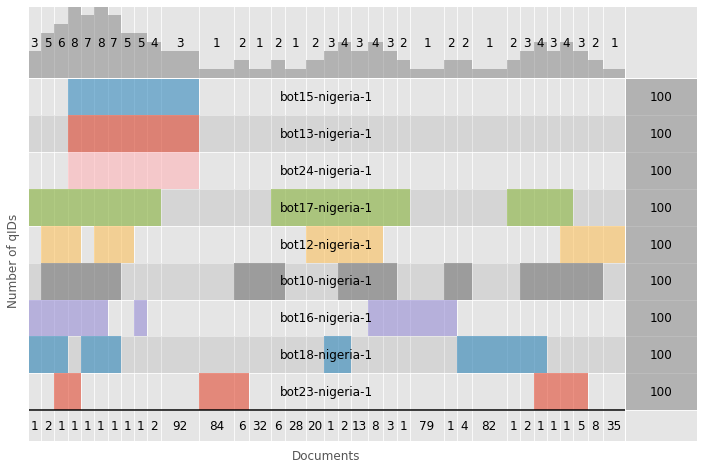

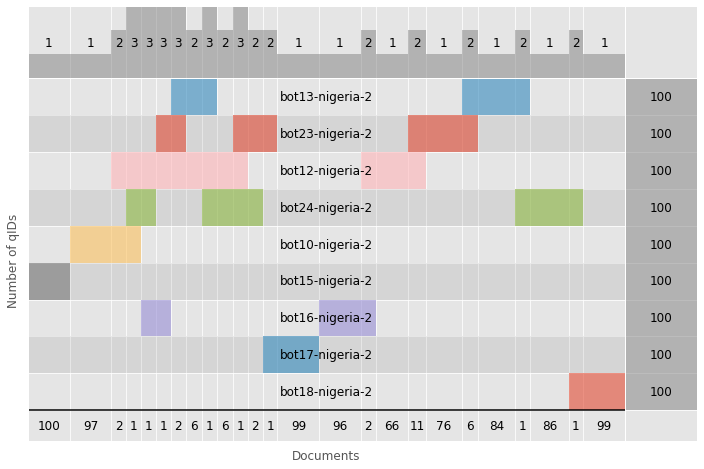

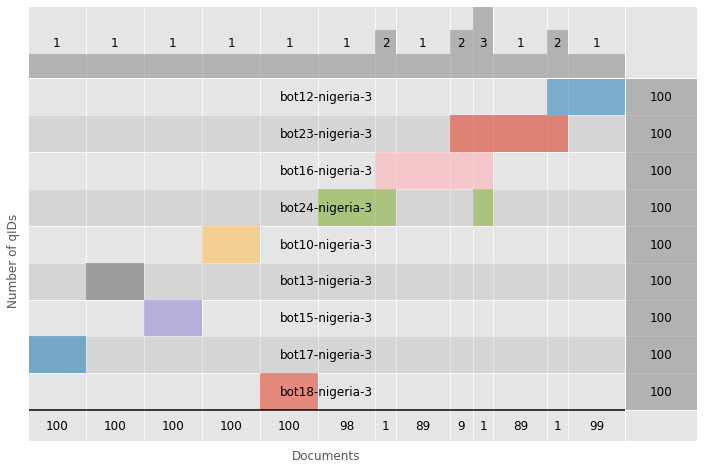

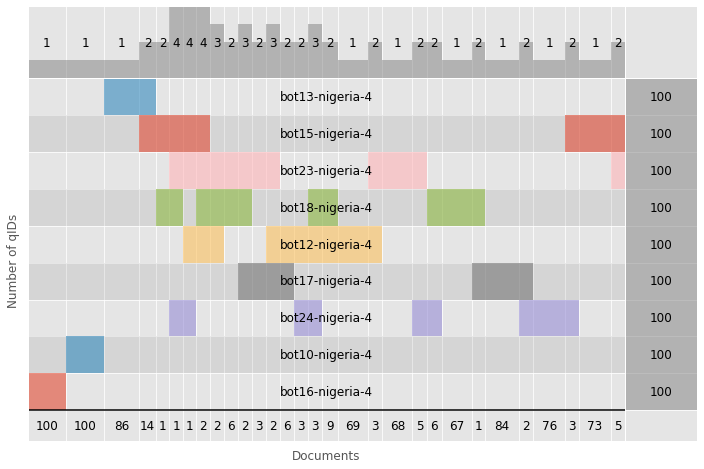

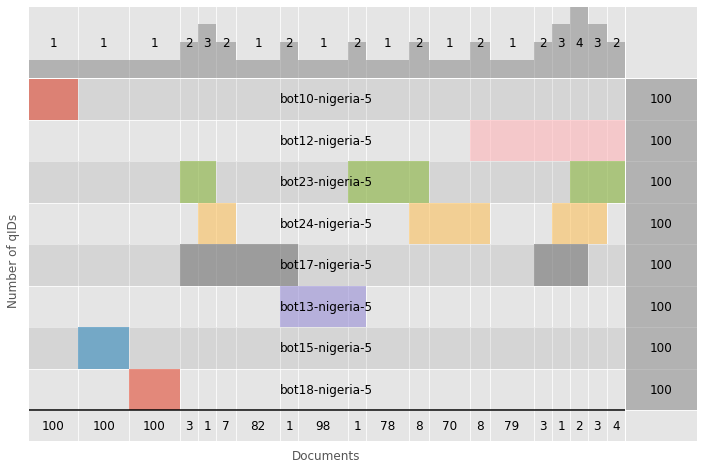

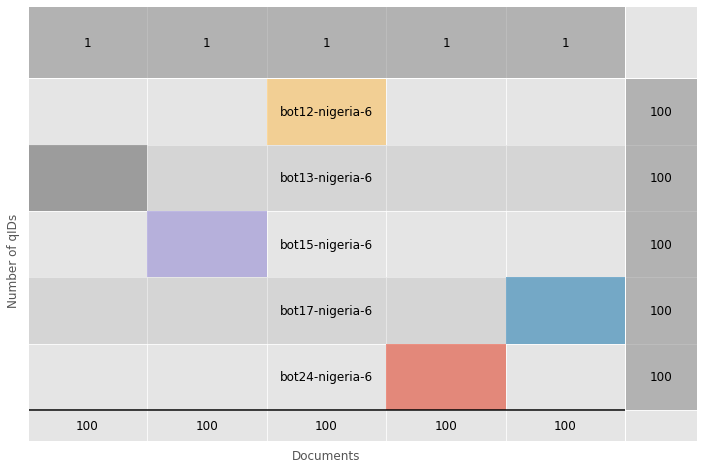

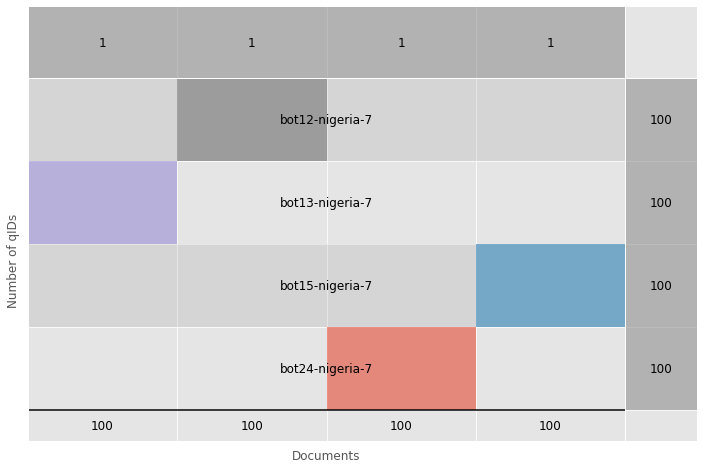

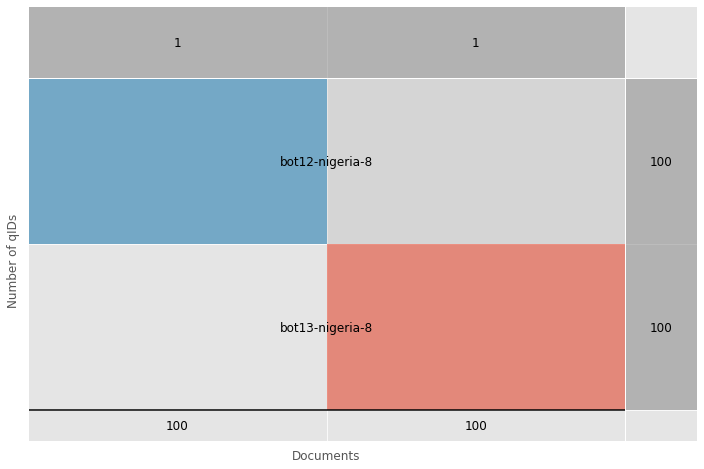

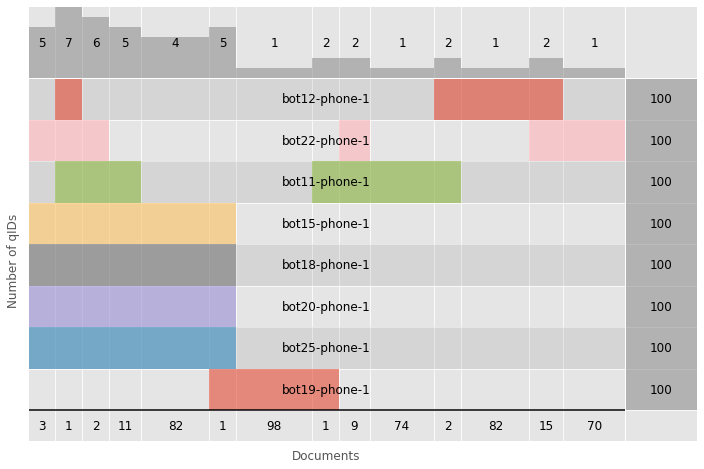

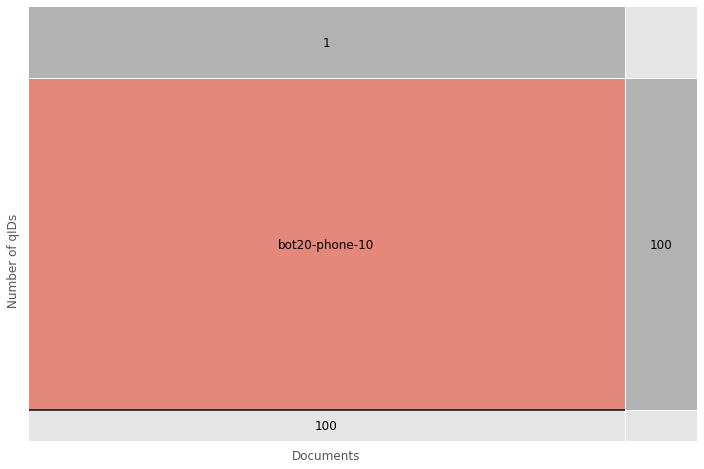

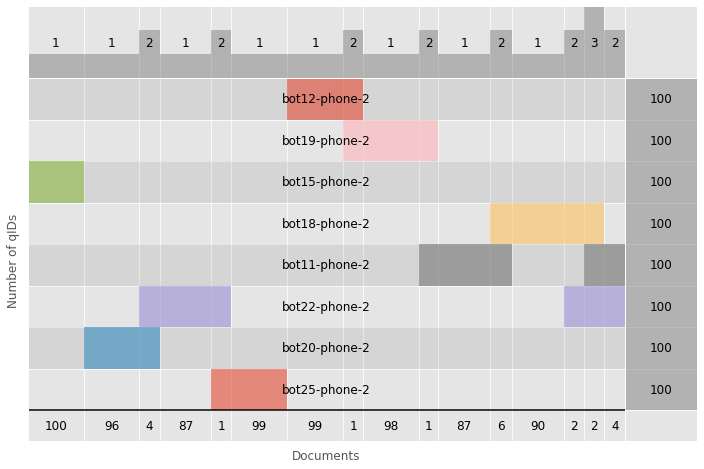

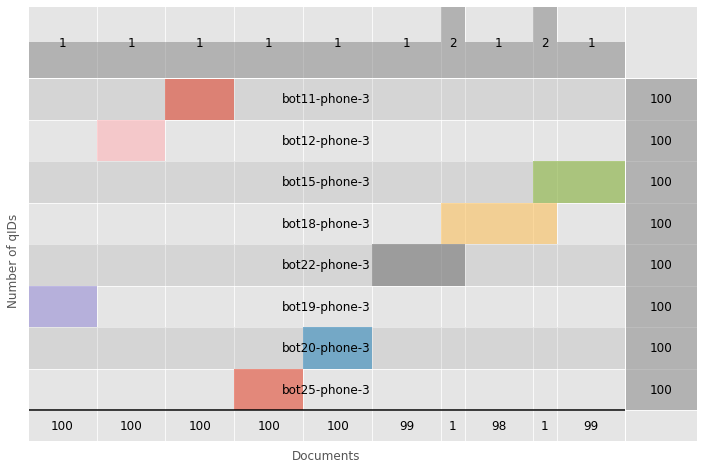

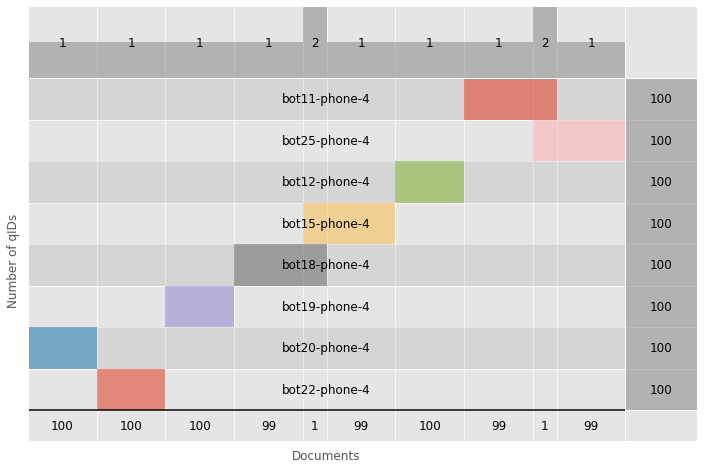

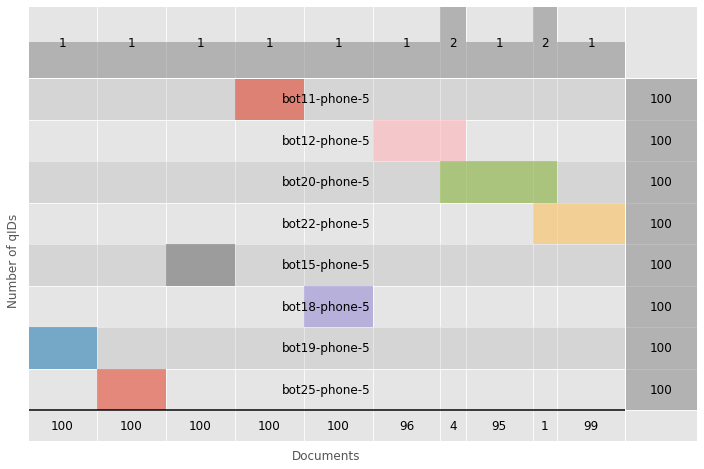

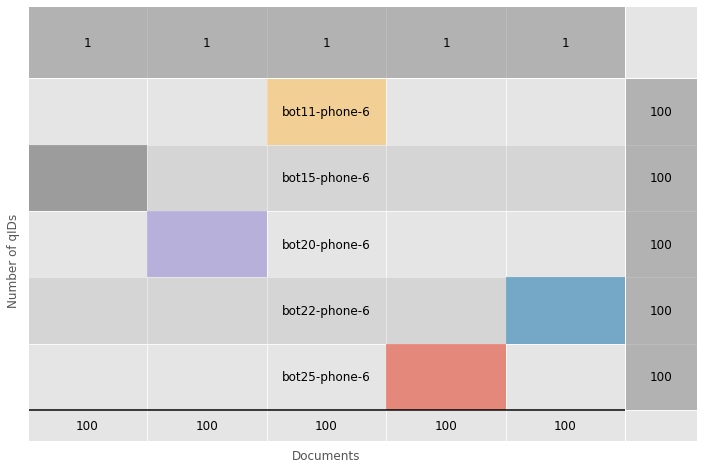

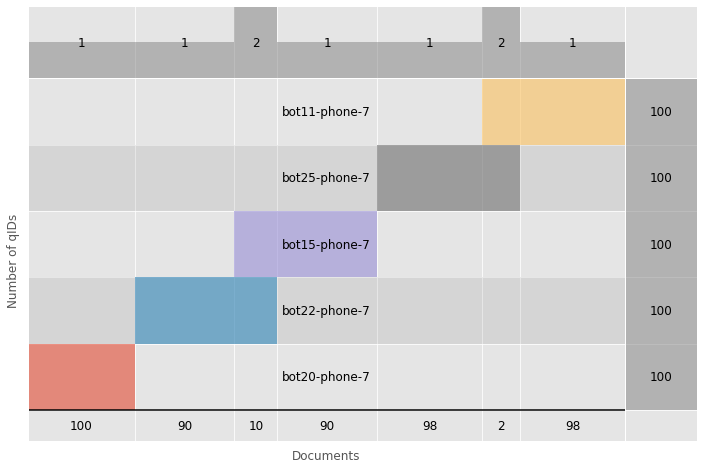

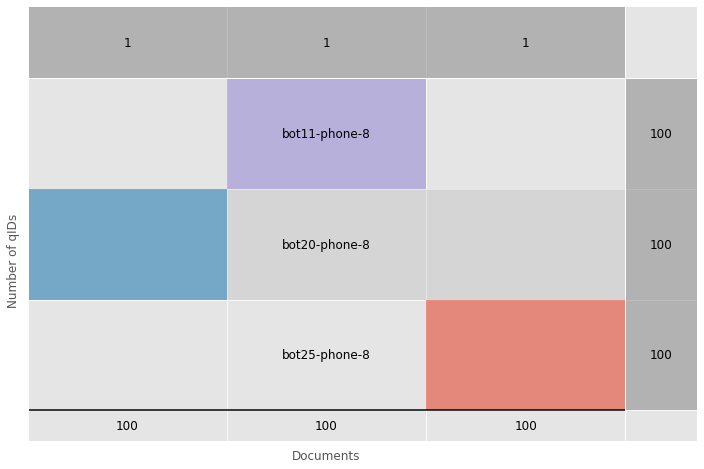

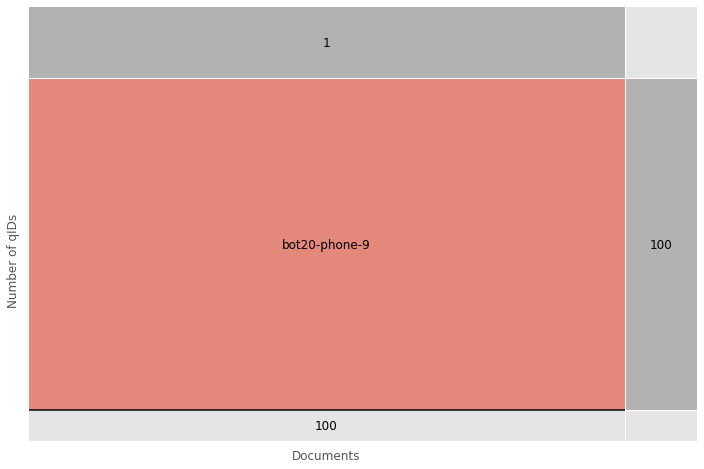

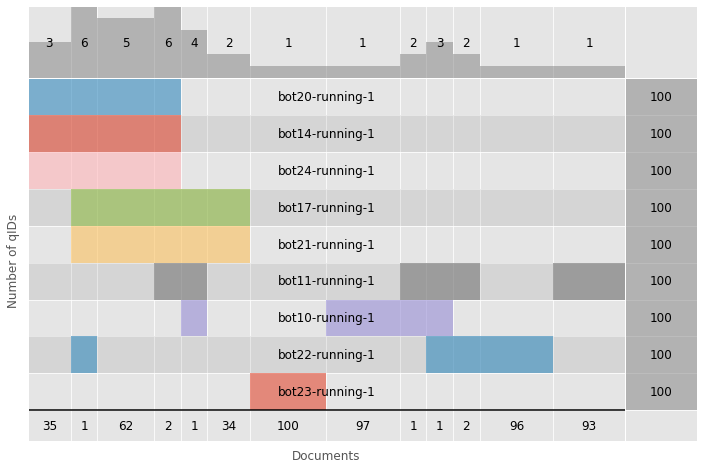

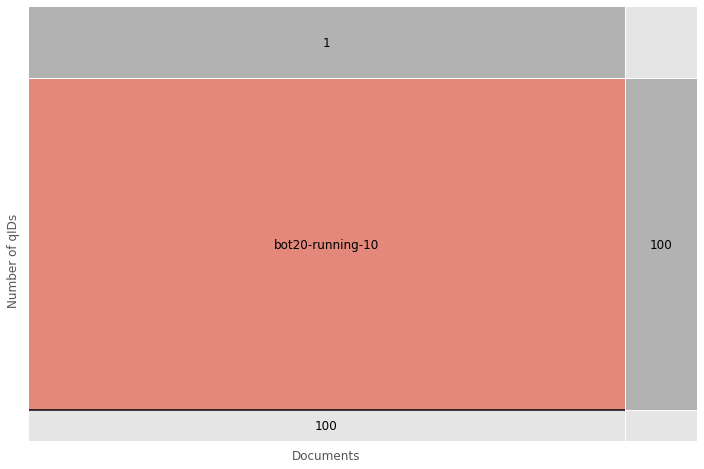

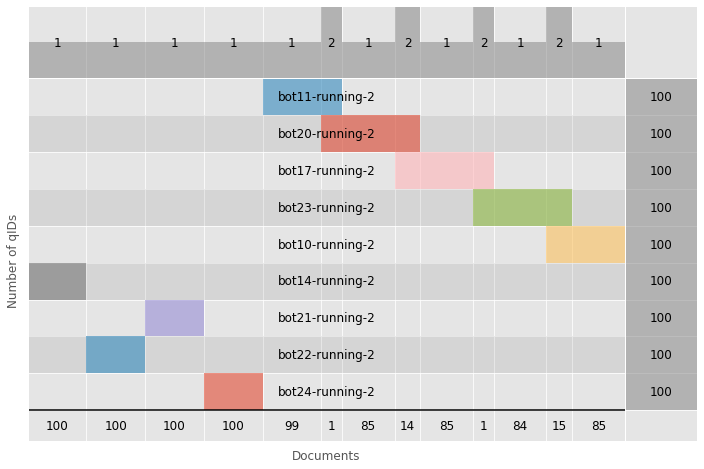

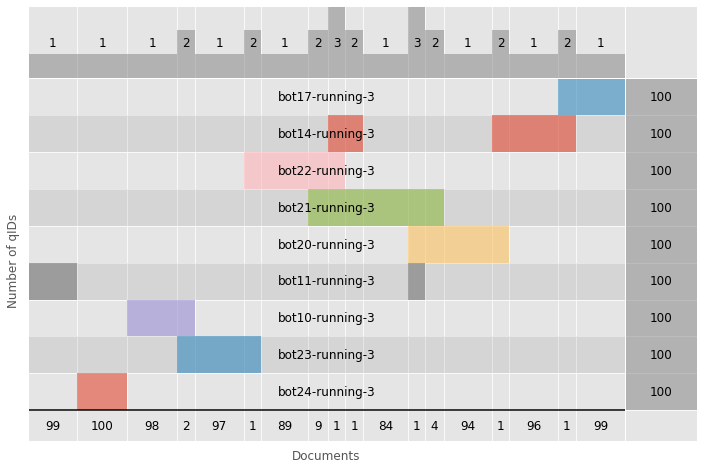

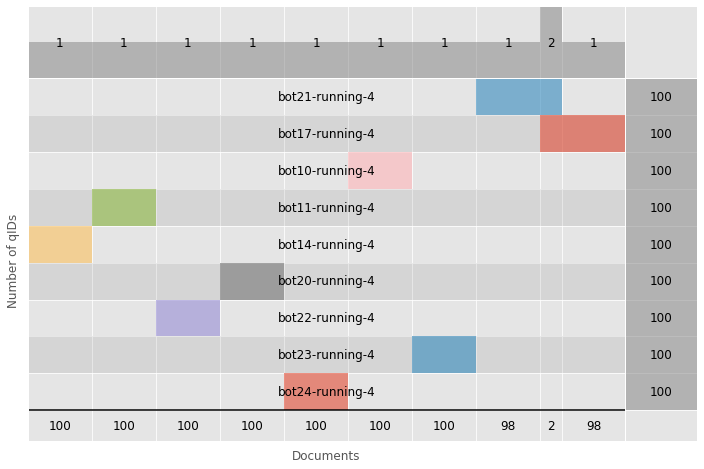

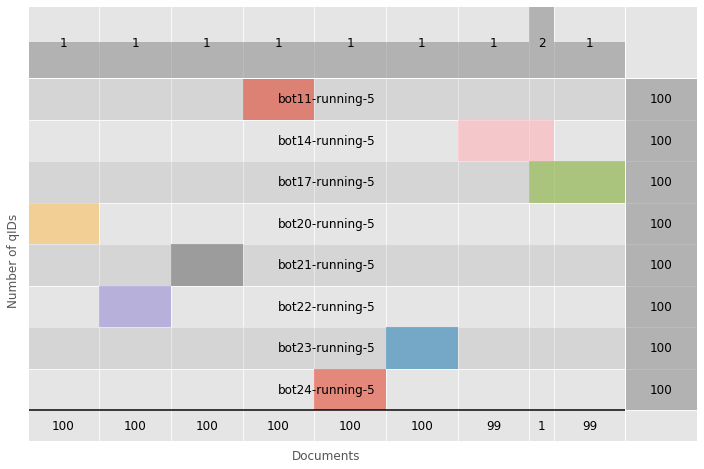

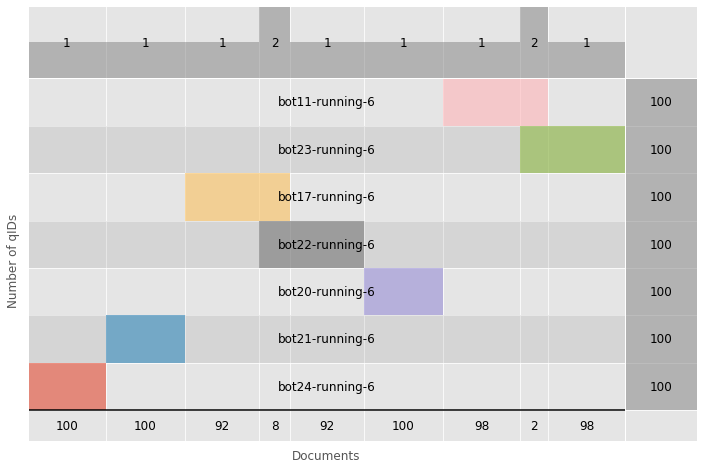

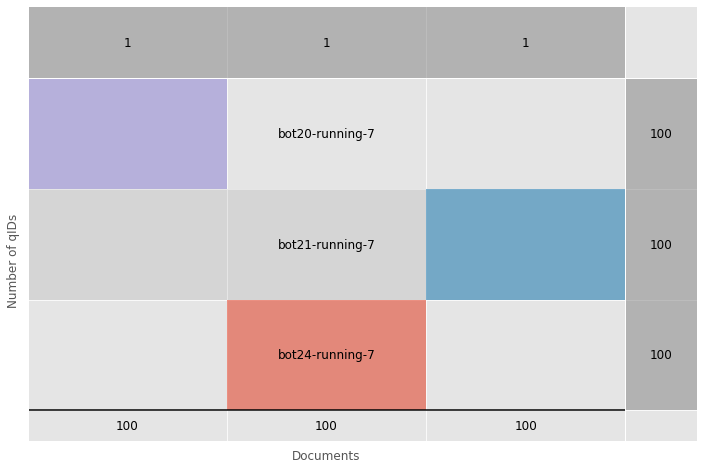

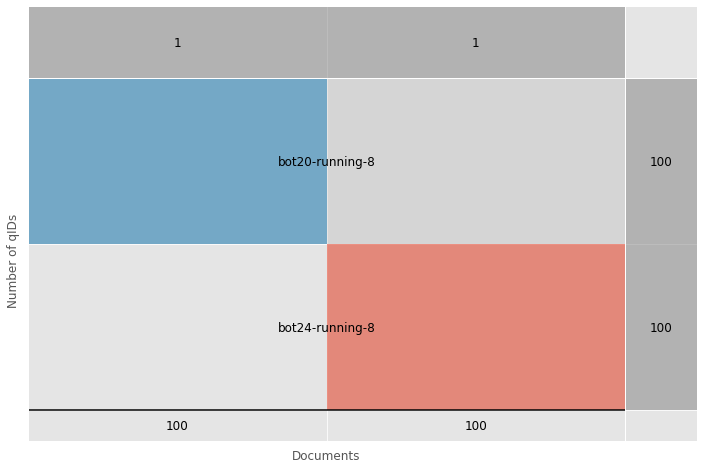

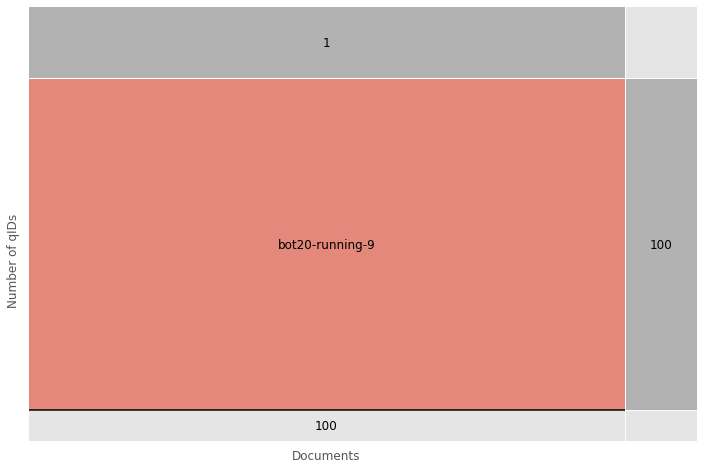

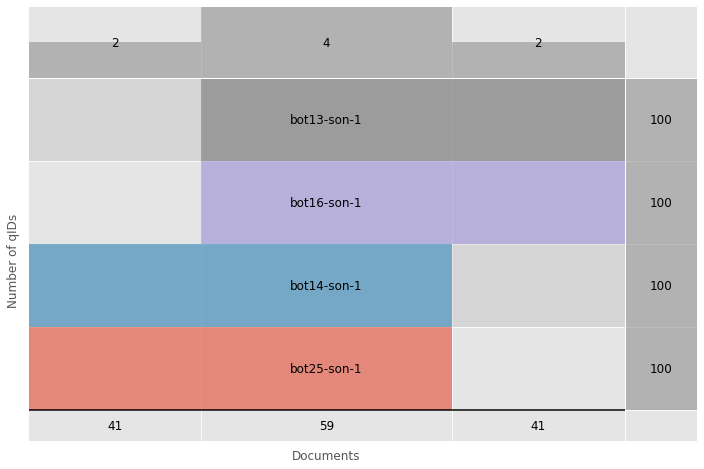

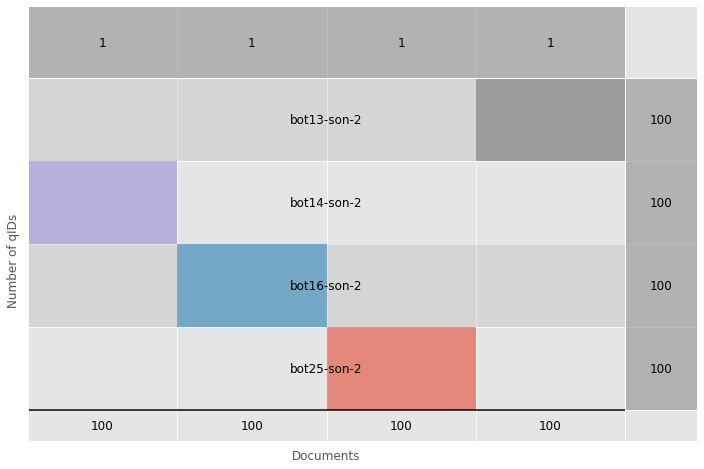

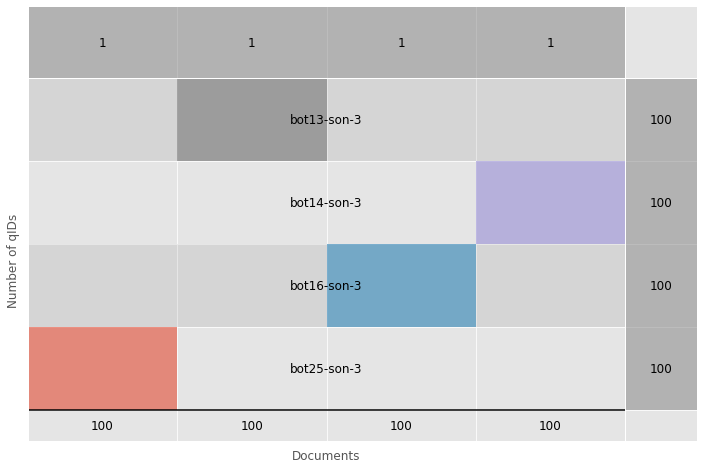

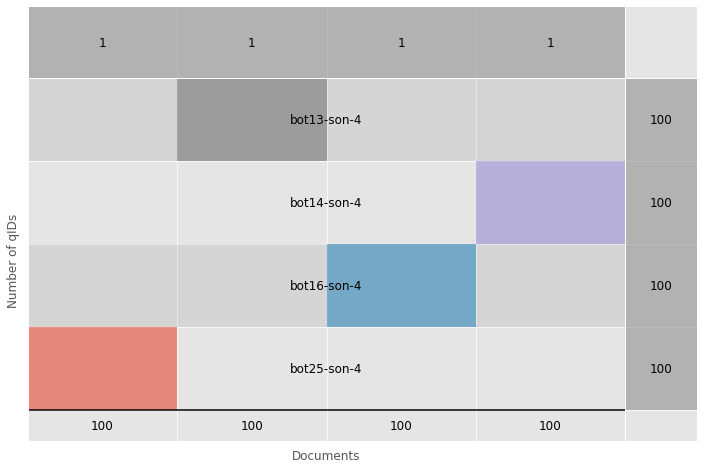

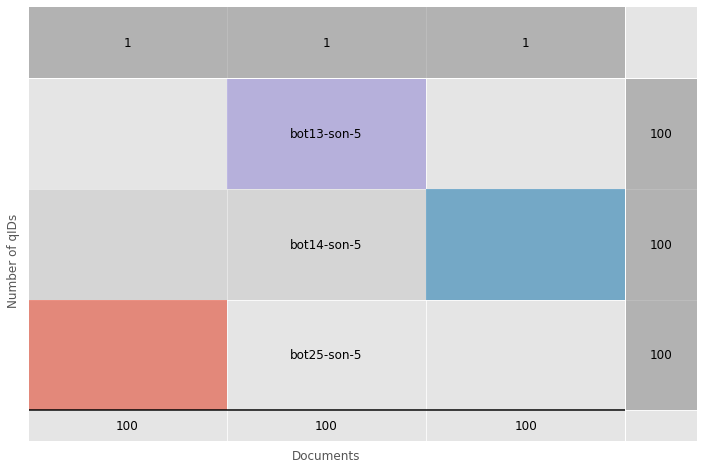

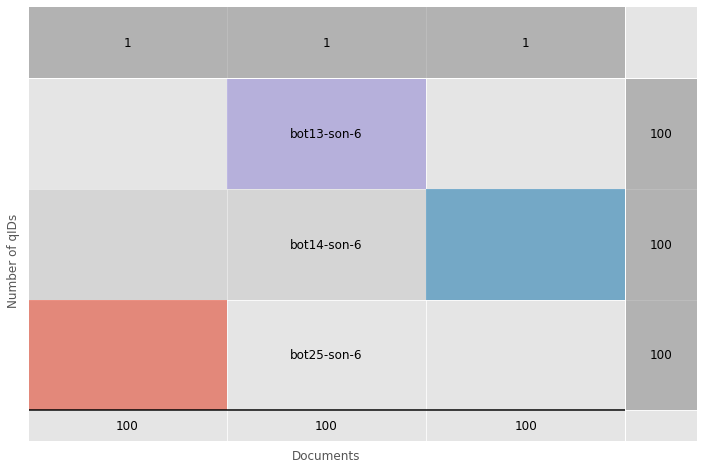

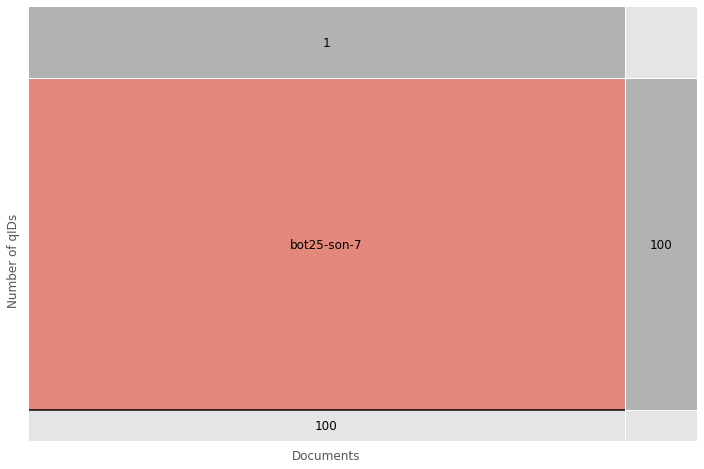

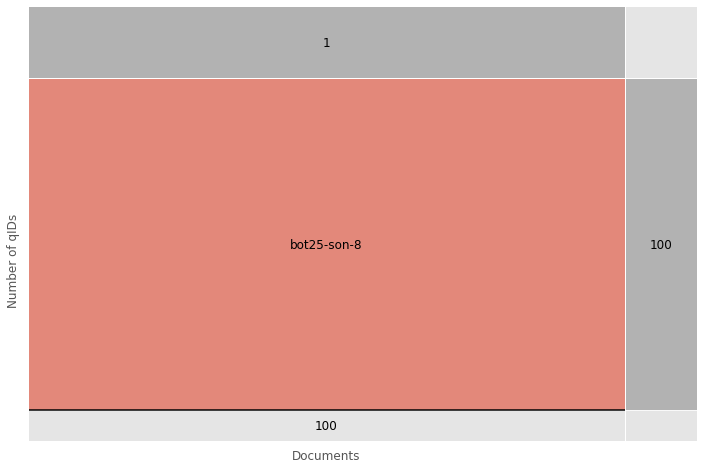

In [297]:
import pandas as pd
from supervenn import supervenn
from matplotlib import pyplot as plt


# Group the dataframe by the qID characters from the 7th position onwards
grouped = doc_lists_df.groupby(doc_lists_df["qID"].str[6:])

# Loop through each group and generate a supervenn diagram for that group
for name, group in grouped:
    # Create a list of sets and labels for this group
    doc_sets = [set(docs[:100]) for docs in group["docList"].tolist()]  ### choose here the number of doc
    labels = [qid for qid in group["qID"].tolist()]

    # Generate the supervenn diagram and plot it
    fig, ax = plt.subplots()
    supervenn(doc_sets, labels, side_plots=True, widths_minmax_ratio=0.35, sets_ordering='minimize gaps' ,ax=ax)
    plt.title(f"Overlap between {len(doc_sets)} qIDs starting with '{name}'")
    plt.xlabel("Documents")
    plt.ylabel("Number of qIDs")
    plt.show()

    
# How to read this plot:
# the upper line in grey show how many intersection with other set there are
# the right grey column show I many documents have each set analysed
# the bottom line  show the sizes (cardinalities) of all intersections  (who how much documents are in this specific intersection)
# The sizes of sets and their intersections are up to proportion, but the order of elements is not preserved

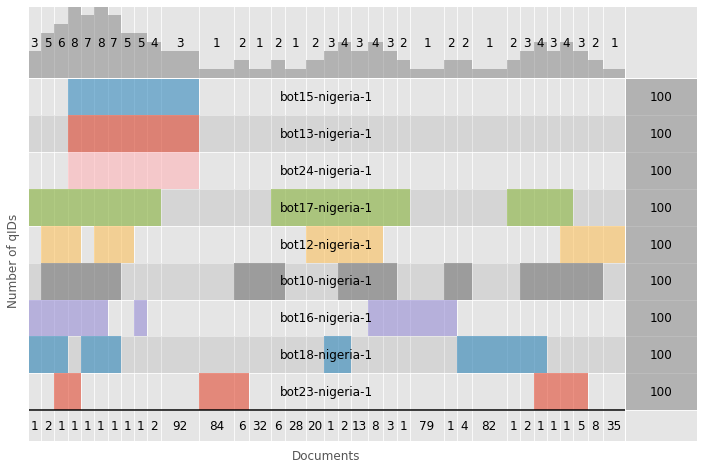

Common documents: set()
Indices for bot10-nigeria-1: set()
Indices for bot12-nigeria-1: set()
Indices for bot13-nigeria-1: set()
Indices for bot15-nigeria-1: set()
Indices for bot16-nigeria-1: set()
Indices for bot17-nigeria-1: set()
Indices for bot18-nigeria-1: set()
Indices for bot23-nigeria-1: set()
Indices for bot24-nigeria-1: set()


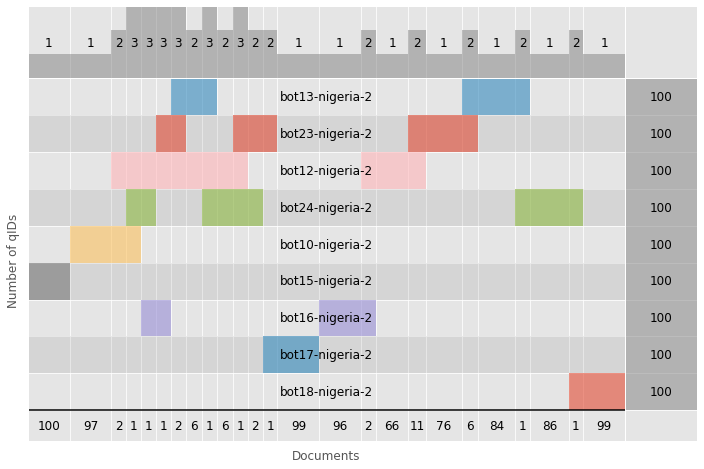

Common documents: set()
Indices for bot10-nigeria-2: set()
Indices for bot12-nigeria-2: set()
Indices for bot13-nigeria-2: set()
Indices for bot15-nigeria-2: set()
Indices for bot16-nigeria-2: set()
Indices for bot17-nigeria-2: set()
Indices for bot18-nigeria-2: set()
Indices for bot23-nigeria-2: set()
Indices for bot24-nigeria-2: set()


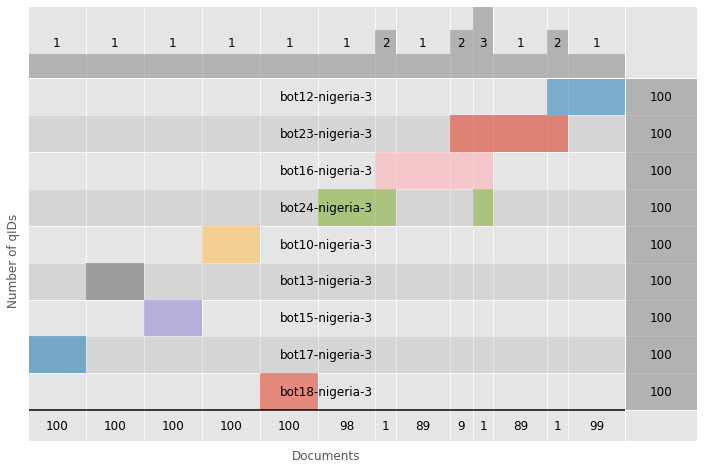

Common documents: set()
Indices for bot10-nigeria-3: set()
Indices for bot12-nigeria-3: set()
Indices for bot13-nigeria-3: set()
Indices for bot15-nigeria-3: set()
Indices for bot16-nigeria-3: set()
Indices for bot17-nigeria-3: set()
Indices for bot18-nigeria-3: set()
Indices for bot23-nigeria-3: set()
Indices for bot24-nigeria-3: set()


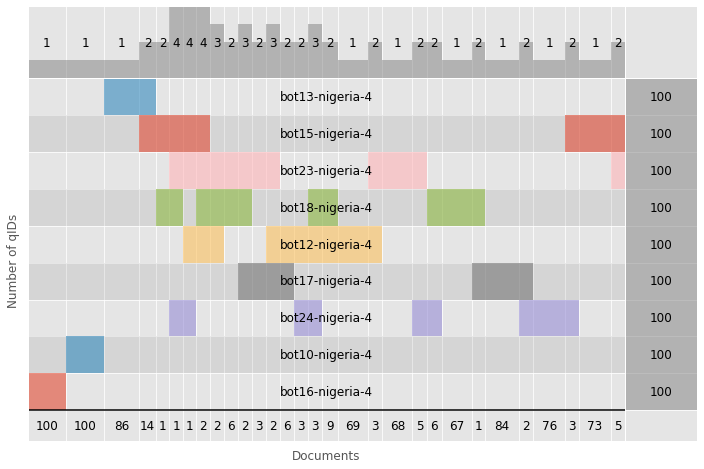

Common documents: set()
Indices for bot10-nigeria-4: set()
Indices for bot12-nigeria-4: set()
Indices for bot13-nigeria-4: set()
Indices for bot15-nigeria-4: set()
Indices for bot16-nigeria-4: set()
Indices for bot17-nigeria-4: set()
Indices for bot18-nigeria-4: set()
Indices for bot23-nigeria-4: set()
Indices for bot24-nigeria-4: set()


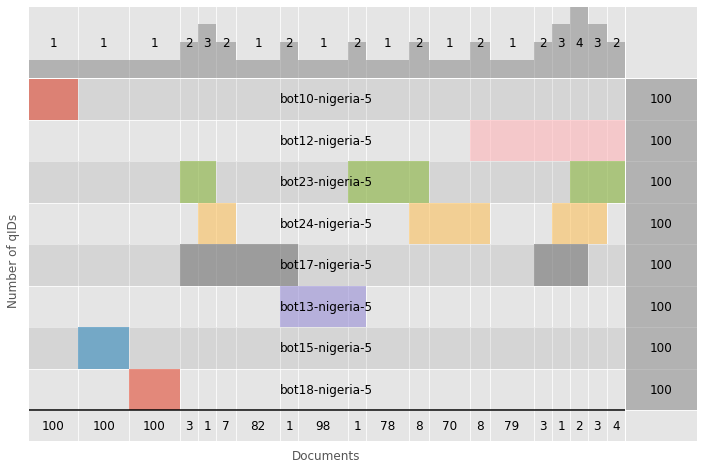

Common documents: set()
Indices for bot10-nigeria-5: set()
Indices for bot12-nigeria-5: set()
Indices for bot13-nigeria-5: set()
Indices for bot15-nigeria-5: set()
Indices for bot17-nigeria-5: set()
Indices for bot18-nigeria-5: set()
Indices for bot23-nigeria-5: set()
Indices for bot24-nigeria-5: set()


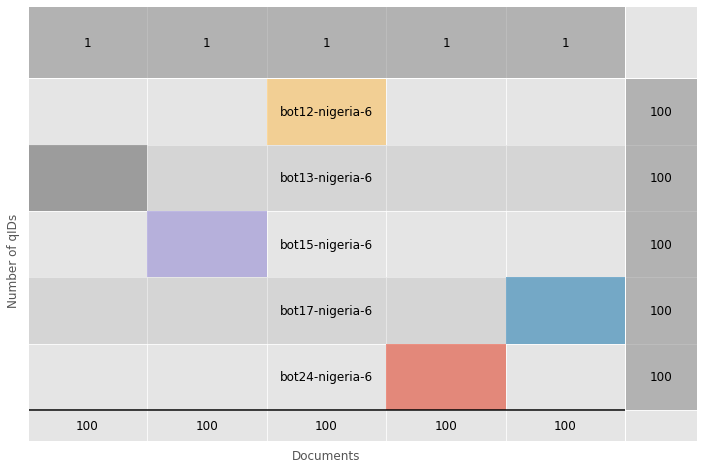

Common documents: set()
Indices for bot12-nigeria-6: set()
Indices for bot13-nigeria-6: set()
Indices for bot15-nigeria-6: set()
Indices for bot17-nigeria-6: set()
Indices for bot24-nigeria-6: set()


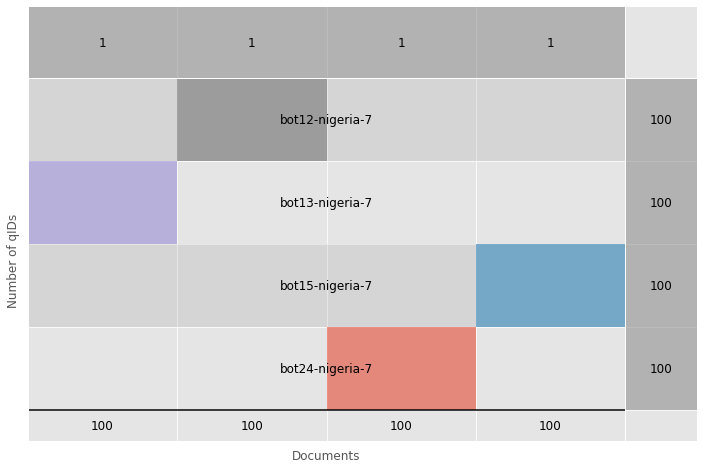

Common documents: set()
Indices for bot12-nigeria-7: set()
Indices for bot13-nigeria-7: set()
Indices for bot15-nigeria-7: set()
Indices for bot24-nigeria-7: set()


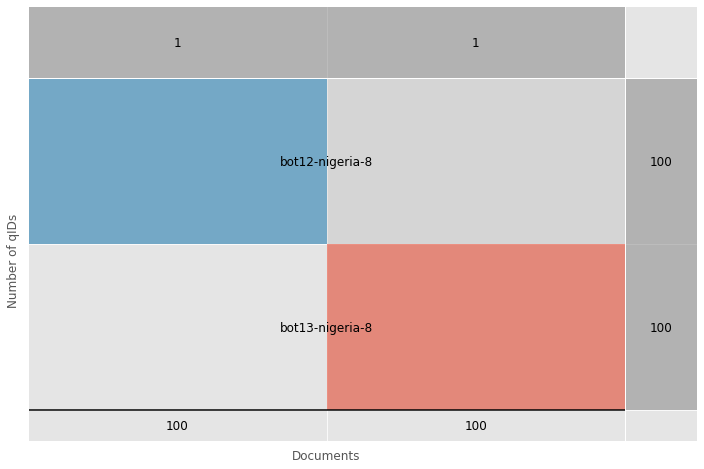

Common documents: set()
Indices for bot12-nigeria-8: set()
Indices for bot13-nigeria-8: set()


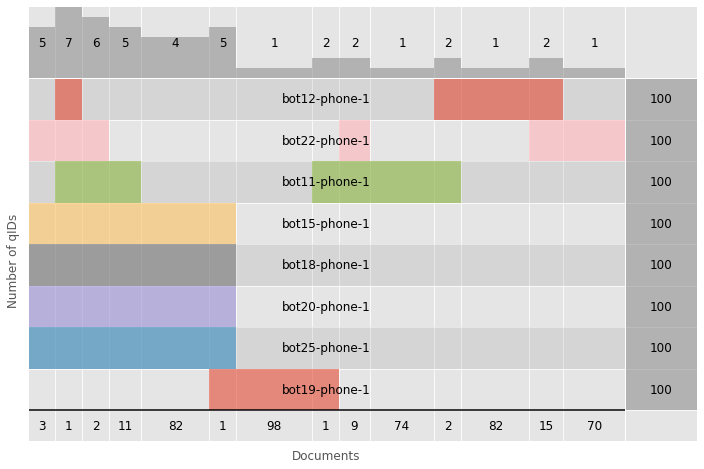

Common documents: set()
Indices for bot11-phone-1: set()
Indices for bot12-phone-1: set()
Indices for bot15-phone-1: set()
Indices for bot18-phone-1: set()
Indices for bot19-phone-1: set()
Indices for bot20-phone-1: set()
Indices for bot22-phone-1: set()
Indices for bot25-phone-1: set()


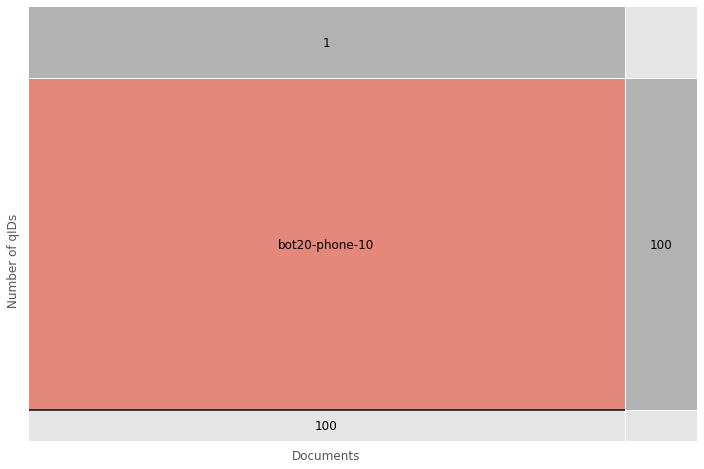

Common documents: {'MARCO_12_1136849134', 'MARCO_59_381265610', 'MARCO_20_700184929', 'MARCO_36_891140639', 'MARCO_31_27345689', 'MARCO_46_8661450', 'MARCO_52_1186797761', 'MARCO_43_841425995', 'MARCO_12_1137504323', 'MARCO_56_817668217', 'MARCO_59_410914593', 'MARCO_13_1760350003', 'MARCO_56_817836999', 'MARCO_43_1549086512', 'MARCO_45_300345561', 'MARCO_48_507480441', 'MARCO_56_307842698', 'MARCO_00_383943932', 'MARCO_39_415976468', 'MARCO_12_1488321513', 'MARCO_25_127047119', 'MARCO_55_838269059', 'MARCO_47_610308194', 'MARCO_22_1283090461', 'MARCO_20_696250341', 'MARCO_22_1284424102', 'MARCO_32_1527108984', 'MARCO_49_1228175555', 'MARCO_20_957014991', 'MARCO_13_1185966670', 'MARCO_36_939912639', 'MARCO_39_420466603', 'MARCO_43_759780335', 'MARCO_55_154046770', 'MARCO_28_179421625', 'MARCO_49_1230345239', 'MARCO_36_849192361', 'MARCO_45_1690338347', 'MARCO_49_804060861', 'MARCO_45_1688245401', 'MARCO_15_614245110', 'MARCO_55_836386866', 'MARCO_38_36224732', 'MARCO_44_805496208', 'MA

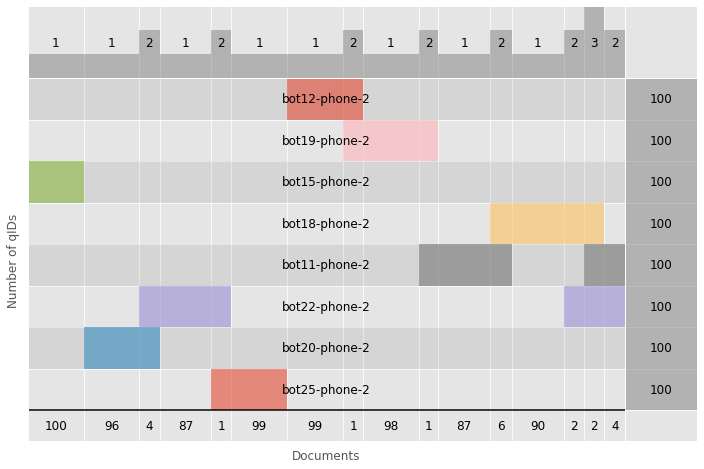

Common documents: set()
Indices for bot11-phone-2: set()
Indices for bot12-phone-2: set()
Indices for bot15-phone-2: set()
Indices for bot18-phone-2: set()
Indices for bot19-phone-2: set()
Indices for bot20-phone-2: set()
Indices for bot22-phone-2: set()
Indices for bot25-phone-2: set()


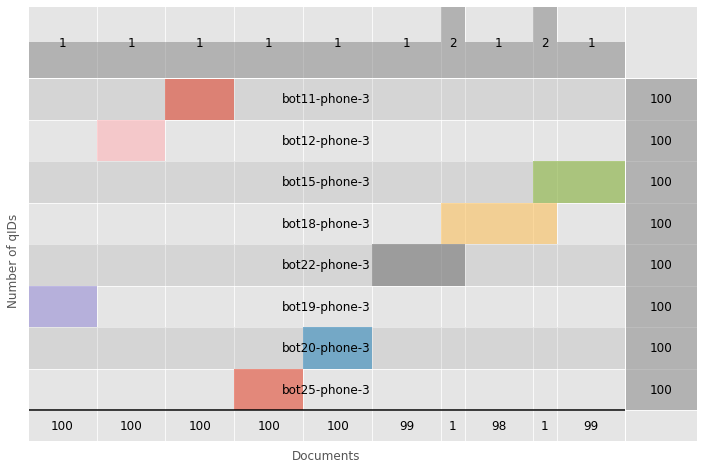

Common documents: set()
Indices for bot11-phone-3: set()
Indices for bot12-phone-3: set()
Indices for bot15-phone-3: set()
Indices for bot18-phone-3: set()
Indices for bot19-phone-3: set()
Indices for bot20-phone-3: set()
Indices for bot22-phone-3: set()
Indices for bot25-phone-3: set()


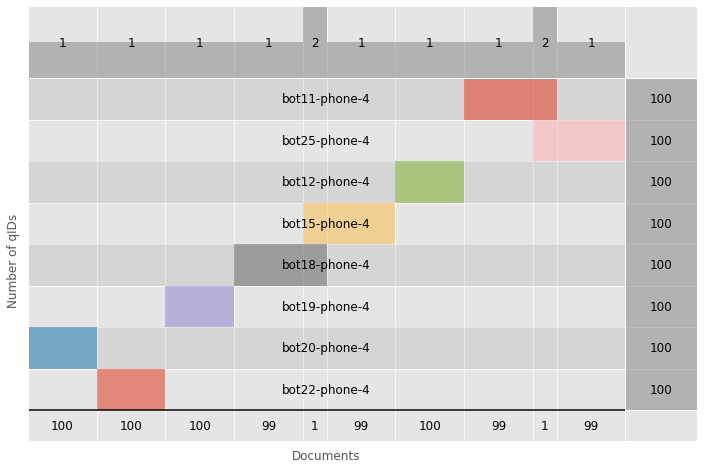

Common documents: set()
Indices for bot11-phone-4: set()
Indices for bot12-phone-4: set()
Indices for bot15-phone-4: set()
Indices for bot18-phone-4: set()
Indices for bot19-phone-4: set()
Indices for bot20-phone-4: set()
Indices for bot22-phone-4: set()
Indices for bot25-phone-4: set()


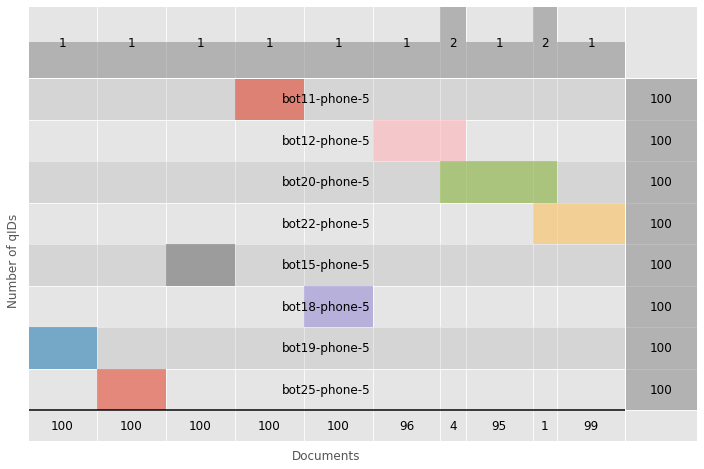

Common documents: set()
Indices for bot11-phone-5: set()
Indices for bot12-phone-5: set()
Indices for bot15-phone-5: set()
Indices for bot18-phone-5: set()
Indices for bot19-phone-5: set()
Indices for bot20-phone-5: set()
Indices for bot22-phone-5: set()
Indices for bot25-phone-5: set()


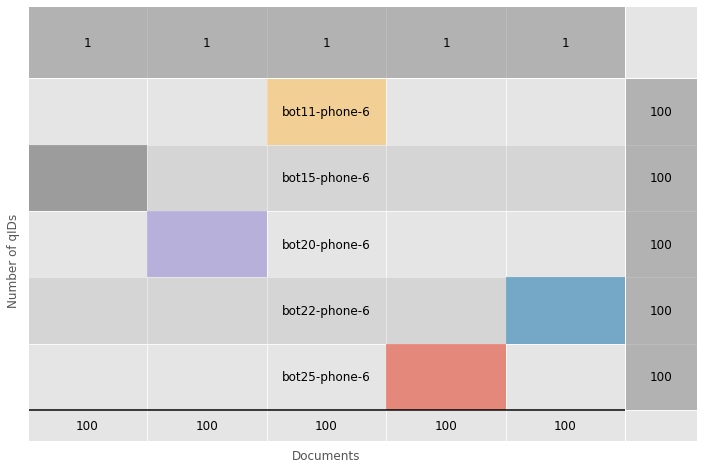

Common documents: set()
Indices for bot11-phone-6: set()
Indices for bot15-phone-6: set()
Indices for bot20-phone-6: set()
Indices for bot22-phone-6: set()
Indices for bot25-phone-6: set()


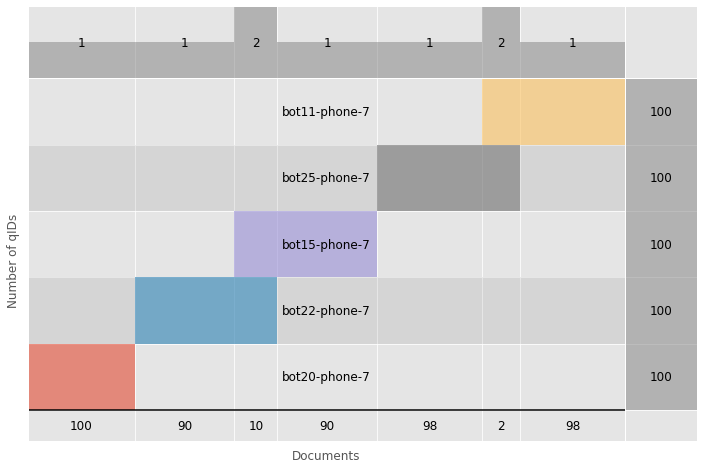

Common documents: set()
Indices for bot11-phone-7: set()
Indices for bot15-phone-7: set()
Indices for bot20-phone-7: set()
Indices for bot22-phone-7: set()
Indices for bot25-phone-7: set()


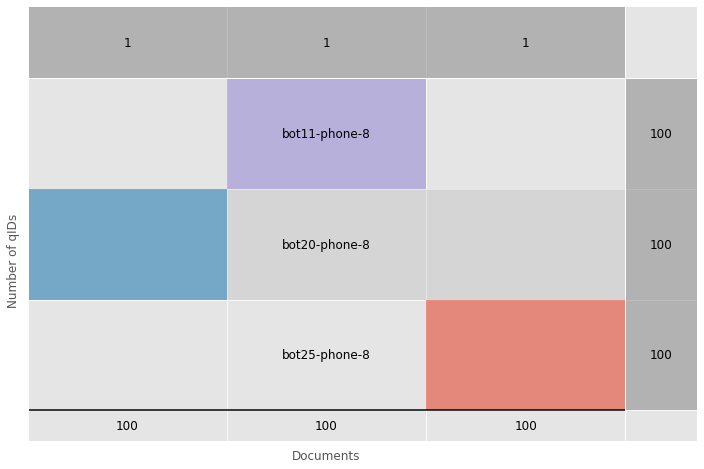

Common documents: set()
Indices for bot11-phone-8: set()
Indices for bot20-phone-8: set()
Indices for bot25-phone-8: set()


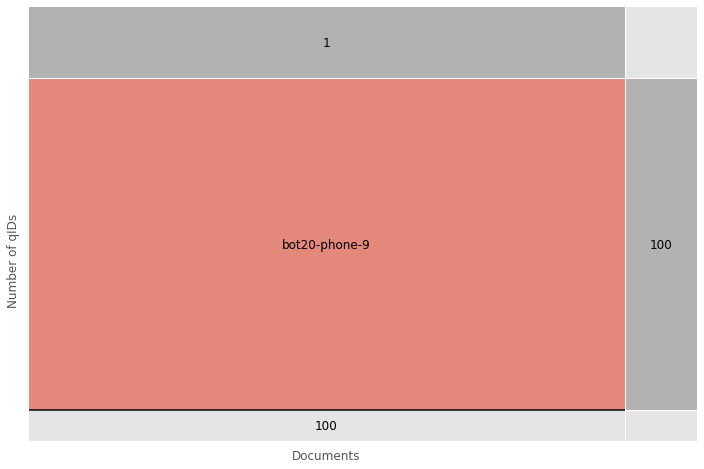

Common documents: {'MARCO_45_1353178840', 'MARCO_33_689791570', 'MARCO_12_575383847', 'MARCO_49_488970263', 'MARCO_53_1311504757', 'MARCO_49_497942795', 'MARCO_53_1452922985', 'MARCO_50_2273545566', 'MARCO_37_816221250', 'MARCO_12_575560389', 'MARCO_48_1592934975', 'MARCO_39_1061457173', 'MARCO_21_1138862858', 'MARCO_12_575425314', 'MARCO_15_1866504160', 'MARCO_49_488726854', 'MARCO_29_347200865', 'MARCO_56_15747164', 'MARCO_41_354051694', 'MARCO_37_599690932', 'MARCO_29_1668039698', 'MARCO_12_575380049', 'MARCO_50_812502872', 'MARCO_00_490594840', 'MARCO_53_1348557311', 'MARCO_31_1408573003', 'MARCO_49_491986816', 'MARCO_48_1283672472', 'MARCO_37_1629595289', 'MARCO_49_661076631', 'MARCO_12_575493012', 'MARCO_43_218206733', 'MARCO_20_452529222', 'MARCO_19_1662634876', 'MARCO_12_575534125', 'MARCO_49_660918757', 'MARCO_13_48405325', 'MARCO_28_1676865946', 'MARCO_47_246597375', 'MARCO_15_309589538', 'MARCO_39_221582035', 'MARCO_52_674791684', 'MARCO_55_988822005', 'MARCO_34_379320560', 

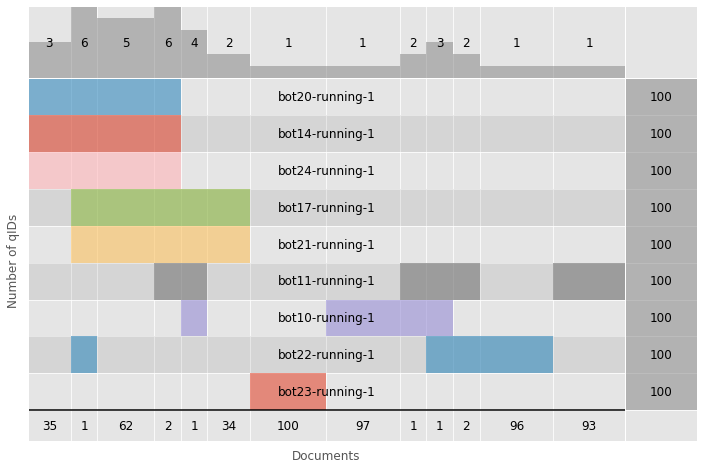

Common documents: set()
Indices for bot10-running-1: set()
Indices for bot11-running-1: set()
Indices for bot14-running-1: set()
Indices for bot17-running-1: set()
Indices for bot20-running-1: set()
Indices for bot21-running-1: set()
Indices for bot22-running-1: set()
Indices for bot23-running-1: set()
Indices for bot24-running-1: set()


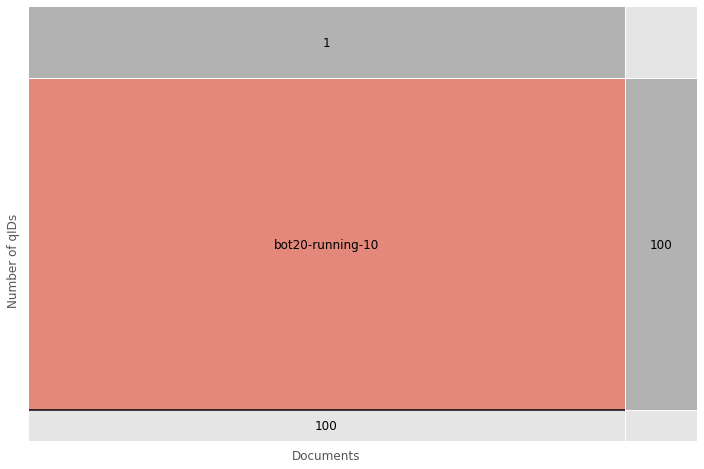

Common documents: {'MARCO_40_1124826299', 'MARCO_31_1573368819', 'MARCO_23_1647271869', 'MARCO_40_1125300583', 'MARCO_58_1627193503', 'MARCO_57_1566062383', 'MARCO_19_1514637543', 'MARCO_24_632466587', 'MARCO_54_334230278', 'MARCO_00_1331535183', 'MARCO_33_586032163', 'MARCO_06_513684390', 'MARCO_39_795580248', 'MARCO_00_652558394', 'MARCO_43_1667014138', 'MARCO_23_545275525', 'MARCO_29_1534274300', 'MARCO_39_785198881', 'MARCO_44_1478436293', 'MARCO_40_1125275698', 'MARCO_15_1459896300', 'MARCO_29_697799736', 'MARCO_40_1124787044', 'MARCO_04_1172683074', 'MARCO_45_879844703', 'MARCO_40_1125082123', 'MARCO_02_982443327', 'MARCO_46_1153214678', 'MARCO_28_1740911902', 'MARCO_06_513952820', 'MARCO_06_513756964', 'MARCO_29_1312243137', 'MARCO_35_1260170881', 'MARCO_40_1125254330', 'MARCO_07_274018775', 'MARCO_07_565321649', 'MARCO_08_92734691', 'MARCO_29_1326554585', 'MARCO_30_235331350', 'MARCO_02_1253457212', 'MARCO_43_1655811613', 'MARCO_40_1125102685', 'MARCO_30_599642299', 'MARCO_06_5

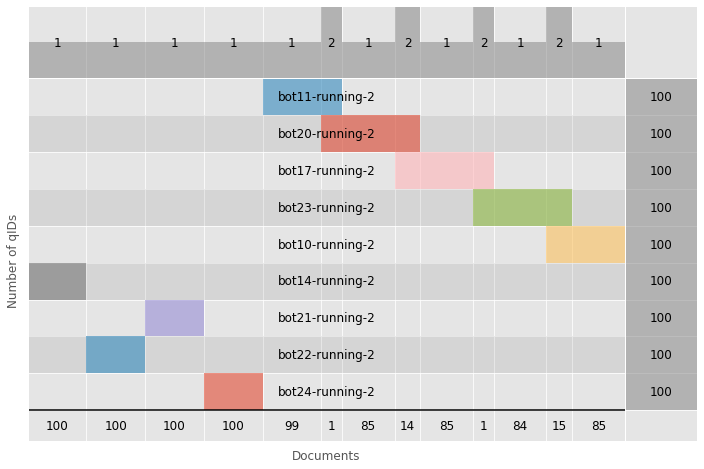

Common documents: set()
Indices for bot10-running-2: set()
Indices for bot11-running-2: set()
Indices for bot14-running-2: set()
Indices for bot17-running-2: set()
Indices for bot20-running-2: set()
Indices for bot21-running-2: set()
Indices for bot22-running-2: set()
Indices for bot23-running-2: set()
Indices for bot24-running-2: set()


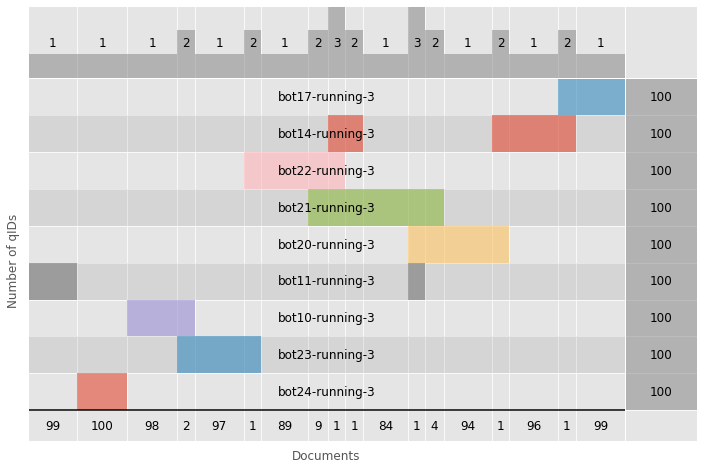

Common documents: set()
Indices for bot10-running-3: set()
Indices for bot11-running-3: set()
Indices for bot14-running-3: set()
Indices for bot17-running-3: set()
Indices for bot20-running-3: set()
Indices for bot21-running-3: set()
Indices for bot22-running-3: set()
Indices for bot23-running-3: set()
Indices for bot24-running-3: set()


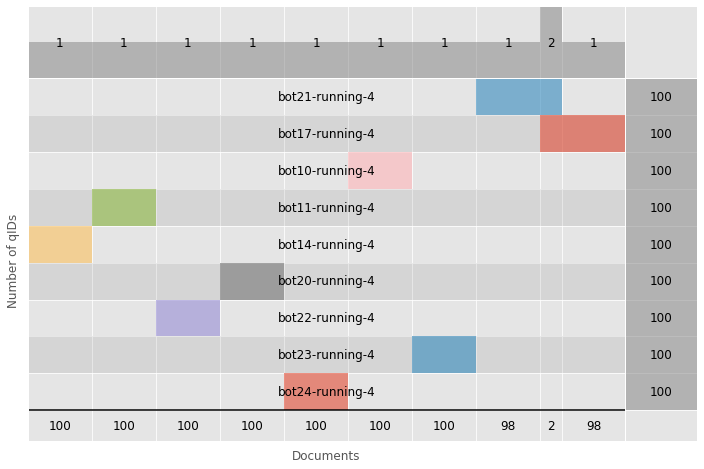

Common documents: set()
Indices for bot10-running-4: set()
Indices for bot11-running-4: set()
Indices for bot14-running-4: set()
Indices for bot17-running-4: set()
Indices for bot20-running-4: set()
Indices for bot21-running-4: set()
Indices for bot22-running-4: set()
Indices for bot23-running-4: set()
Indices for bot24-running-4: set()


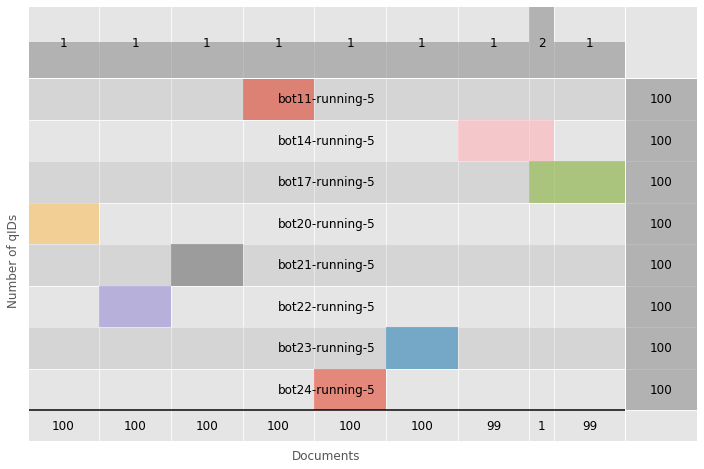

Common documents: set()
Indices for bot11-running-5: set()
Indices for bot14-running-5: set()
Indices for bot17-running-5: set()
Indices for bot20-running-5: set()
Indices for bot21-running-5: set()
Indices for bot22-running-5: set()
Indices for bot23-running-5: set()
Indices for bot24-running-5: set()


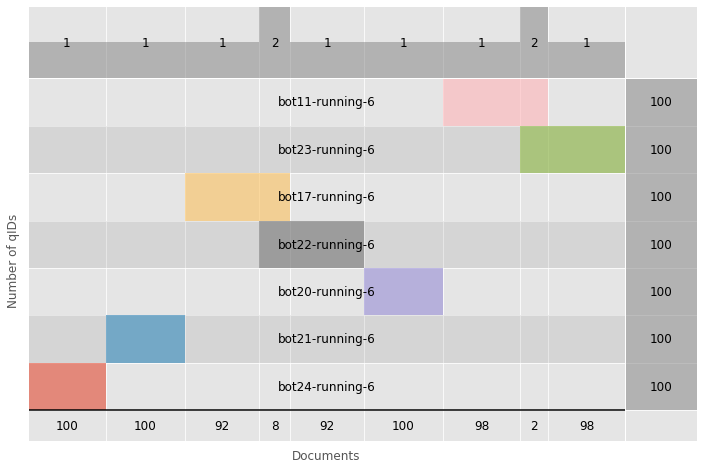

Common documents: set()
Indices for bot11-running-6: set()
Indices for bot17-running-6: set()
Indices for bot20-running-6: set()
Indices for bot21-running-6: set()
Indices for bot22-running-6: set()
Indices for bot23-running-6: set()
Indices for bot24-running-6: set()


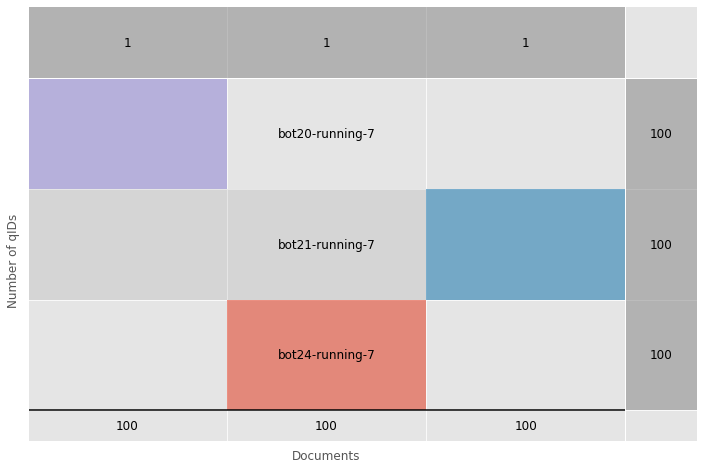

Common documents: set()
Indices for bot20-running-7: set()
Indices for bot21-running-7: set()
Indices for bot24-running-7: set()


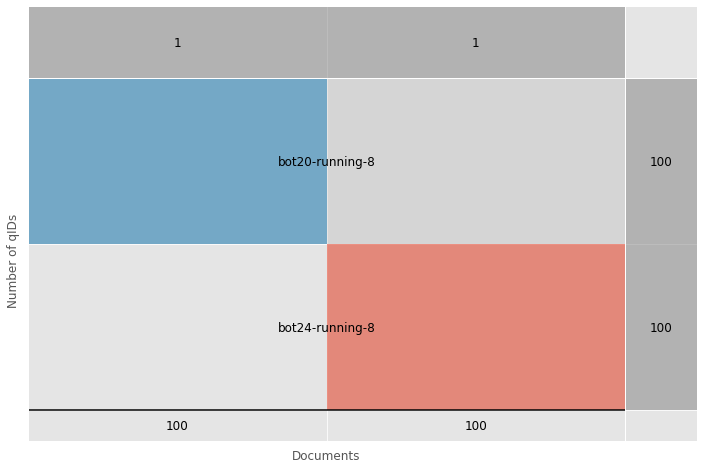

Common documents: set()
Indices for bot20-running-8: set()
Indices for bot24-running-8: set()


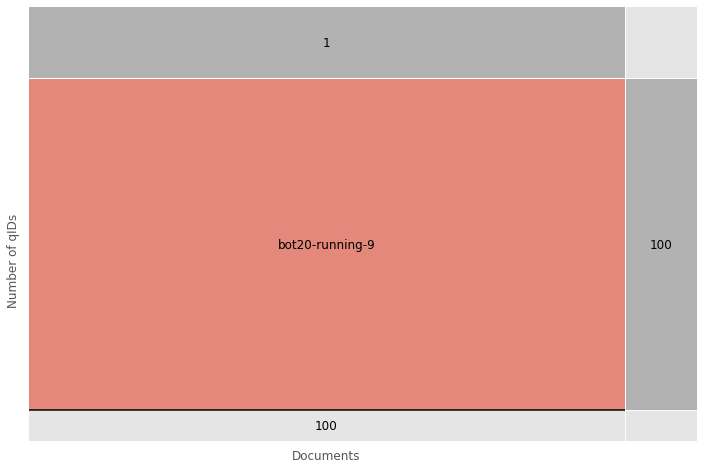

Common documents: {'MARCO_57_588107003', 'MARCO_19_1653148222', 'MARCO_53_169686836', 'MARCO_00_1632476821', 'MARCO_57_247255519', 'MARCO_01_2144428844', 'MARCO_25_327367865', 'MARCO_39_1365733902', 'MARCO_28_965641582', 'MARCO_34_1288016810', 'MARCO_28_584084333', 'MARCO_39_730939380', 'MARCO_52_579425838', 'MARCO_50_1208840265', 'MARCO_13_1356183230', 'MARCO_27_547936089', 'MARCO_09_966613847', 'MARCO_24_440198338', 'MARCO_33_1485170639', 'MARCO_26_292935784', 'MARCO_04_512165797', 'MARCO_21_880095551', 'MARCO_51_972083580', 'MARCO_46_611910591', 'MARCO_51_967447718', 'MARCO_02_1128028107', 'MARCO_14_1211720320', 'MARCO_43_1668225194', 'MARCO_53_1260196792', 'MARCO_45_57017671', 'WAPO_00b8e670-3f0d-11e3-b028-de922d7a3f47', 'MARCO_47_433882089', 'MARCO_23_922711793', 'MARCO_29_1141546957', 'MARCO_34_1306716772', 'MARCO_50_735427786', 'MARCO_23_917270220', 'MARCO_48_377317789', 'MARCO_50_2081041802', 'MARCO_33_1472815037', 'MARCO_24_430647704', 'MARCO_27_194417552', 'MARCO_39_173975104

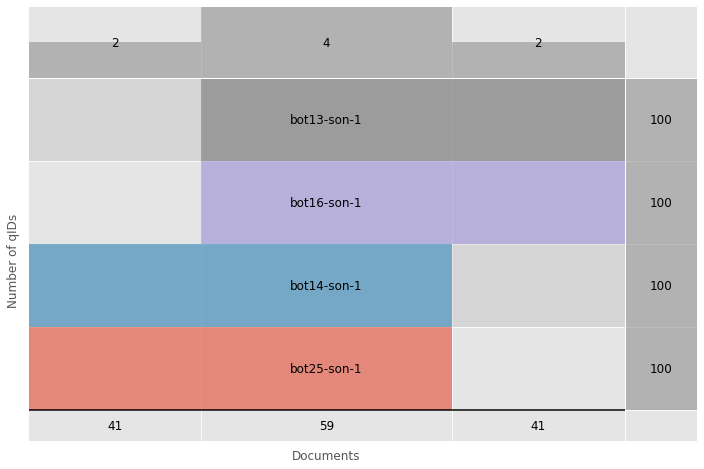

Common documents: {'MARCO_28_629707354', 'MARCO_28_771447759', 'MARCO_57_139128300', 'MARCO_05_1269770019', 'MARCO_45_1527370726', 'MARCO_56_499820806', 'MARCO_47_715203808', 'MARCO_26_746385703', 'MARCO_38_74537490', 'MARCO_47_715185503', 'MARCO_09_541065829', 'WAPO_a41540780cacd6f519d657e5907d1423', 'MARCO_42_1086605493', 'MARCO_15_1949968677', 'MARCO_27_463594838', 'MARCO_31_61784072', 'MARCO_00_1450291313', 'MARCO_03_343307399', 'MARCO_19_1856090515', 'MARCO_30_307890164', 'MARCO_53_630991541', 'MARCO_58_65306486', 'MARCO_42_1015125020', 'MARCO_28_135770096', 'MARCO_50_421768613', 'MARCO_42_1014841049', 'MARCO_24_947151795', 'MARCO_47_715259095', 'MARCO_32_302475065', 'MARCO_58_7030988', 'MARCO_44_1519625347', 'MARCO_41_1783989605', 'MARCO_34_1354426044', 'MARCO_32_652045395', 'MARCO_23_141729552', 'MARCO_42_1015182405', 'MARCO_52_204154925', 'MARCO_28_218644315', 'MARCO_25_1296028169', 'MARCO_47_715174640', 'WAPO_3ca4c840-3803-11e3-ae46-e4248e75c8ea', 'MARCO_45_1515624667', 'MARCO

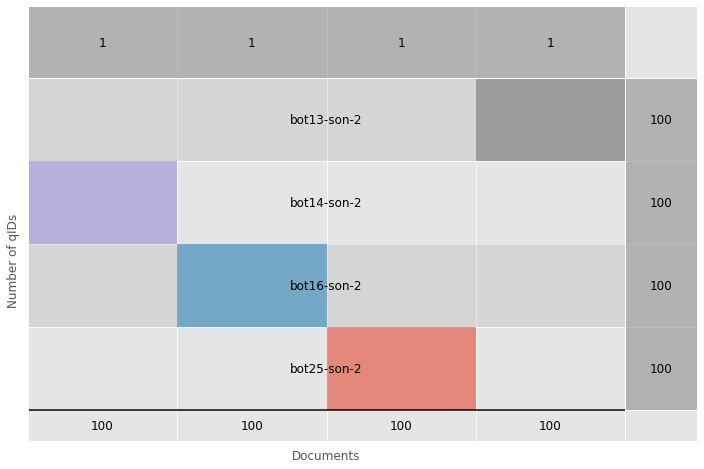

Common documents: set()
Indices for bot13-son-2: set()
Indices for bot14-son-2: set()
Indices for bot16-son-2: set()
Indices for bot25-son-2: set()


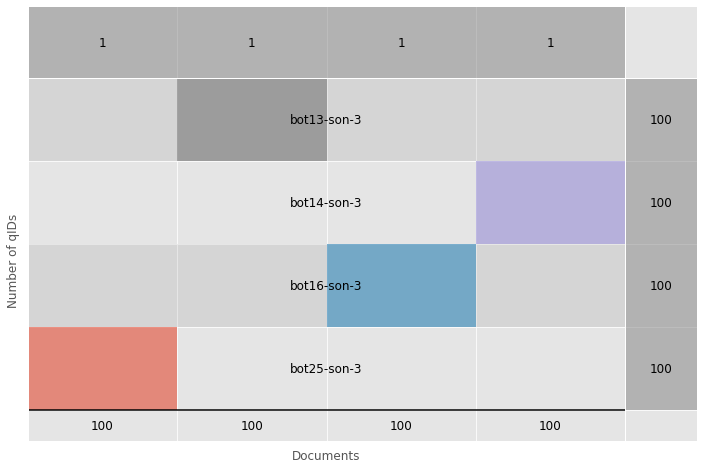

Common documents: set()
Indices for bot13-son-3: set()
Indices for bot14-son-3: set()
Indices for bot16-son-3: set()
Indices for bot25-son-3: set()


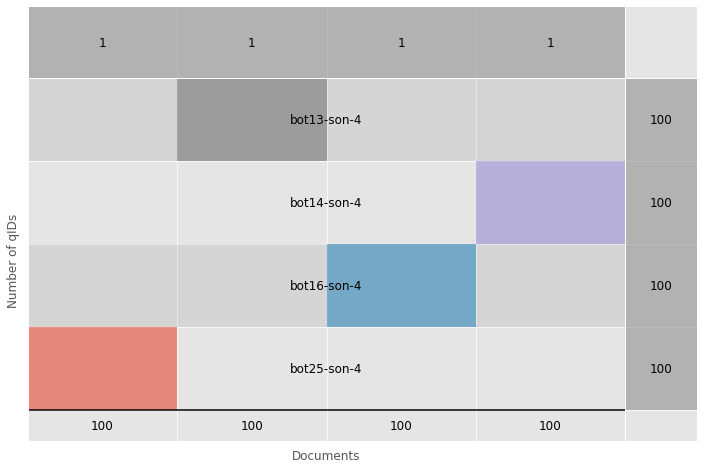

Common documents: set()
Indices for bot13-son-4: set()
Indices for bot14-son-4: set()
Indices for bot16-son-4: set()
Indices for bot25-son-4: set()


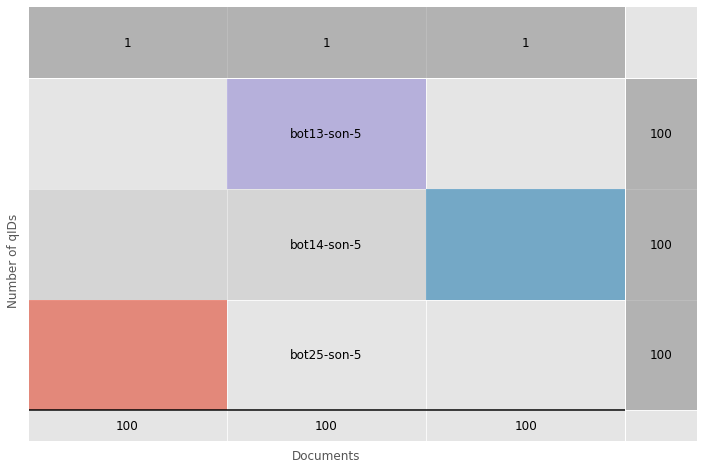

Common documents: set()
Indices for bot13-son-5: set()
Indices for bot14-son-5: set()
Indices for bot25-son-5: set()


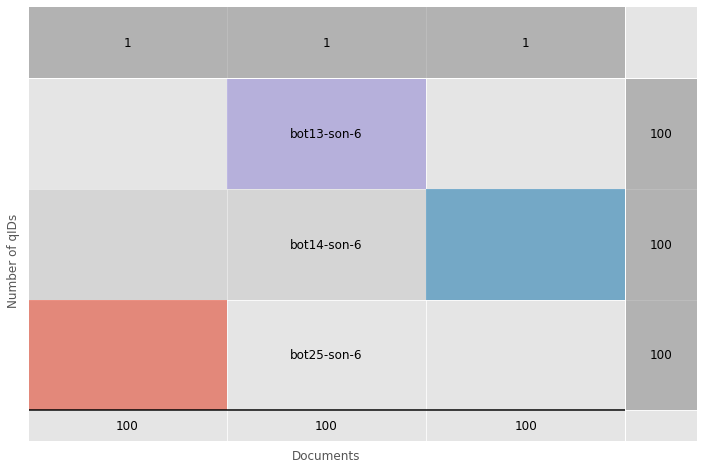

Common documents: set()
Indices for bot13-son-6: set()
Indices for bot14-son-6: set()
Indices for bot25-son-6: set()


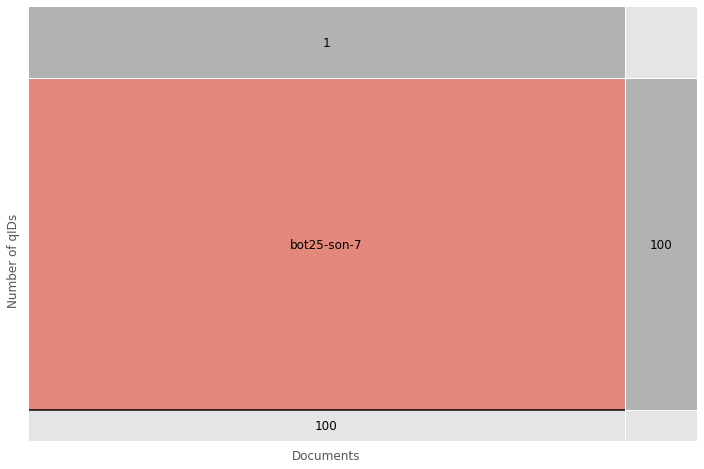

Common documents: {'MARCO_30_816247443', 'KILT_47559547', 'MARCO_06_36888534', 'MARCO_41_430003206', 'MARCO_33_603094986', 'MARCO_04_1208651667', 'MARCO_34_514204980', 'MARCO_49_1100682340', 'MARCO_56_824575956', 'MARCO_38_1701528224', 'MARCO_00_770736373', 'MARCO_45_93684270', 'MARCO_45_527591804', 'MARCO_39_152124893', 'MARCO_12_915038137', 'MARCO_35_984390176', 'MARCO_02_1240182180', 'MARCO_04_211268488', 'MARCO_20_1370968065', 'MARCO_53_632567771', 'MARCO_30_516905549', 'MARCO_57_1274073431', 'MARCO_49_1846018940', 'MARCO_19_1625615481', 'MARCO_33_1476644345', 'KILT_46981896', 'MARCO_45_136338496', 'MARCO_33_1161612138', 'MARCO_08_195233041', 'MARCO_21_641450826', 'MARCO_56_877043387', 'MARCO_00_1544894101', 'MARCO_24_434281798', 'MARCO_56_407085984', 'MARCO_02_1055367375', 'MARCO_24_837627008', 'MARCO_01_1257953536', 'MARCO_31_351016094', 'MARCO_41_430925088', 'MARCO_35_795411120', 'MARCO_50_1372702033', 'MARCO_29_1274052729', 'MARCO_24_1755324001', 'MARCO_02_705019342', 'MARCO_00

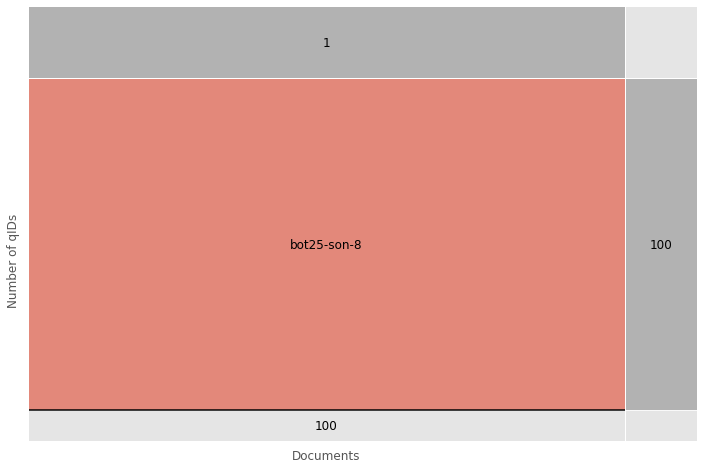

Common documents: {'MARCO_25_1408097463', 'MARCO_52_1236751220', 'MARCO_13_399052139', 'MARCO_46_378420943', 'MARCO_11_1090576755', 'MARCO_41_699928841', 'MARCO_39_925292202', 'MARCO_31_1404694260', 'MARCO_25_1844081788', 'MARCO_12_1929312852', 'MARCO_16_1127269159', 'MARCO_33_1431308950', 'MARCO_44_583248671', 'MARCO_33_1431444395', 'MARCO_44_236087611', 'MARCO_24_1116199241', 'MARCO_31_1394190336', 'MARCO_12_667113561', 'MARCO_19_1936360620', 'MARCO_50_285880159', 'MARCO_25_1831538248', 'MARCO_54_401553158', 'MARCO_34_510425064', 'MARCO_36_298904290', 'MARCO_59_823201666', 'MARCO_55_172685099', 'MARCO_46_372739443', 'MARCO_11_232903471', 'MARCO_09_223229545', 'MARCO_37_192528847', 'MARCO_58_833743777', 'MARCO_43_1675337715', 'MARCO_25_1165971007', 'MARCO_15_191841666', 'MARCO_59_535716852', 'MARCO_31_1298540680', 'MARCO_04_906076385', 'MARCO_25_1158147177', 'MARCO_13_1494396767', 'MARCO_55_535706047', 'MARCO_23_48275377', 'MARCO_14_1049608054', 'MARCO_24_1258860766', 'MARCO_54_354830

In [301]:
import pandas as pd
from supervenn import supervenn
from matplotlib import pyplot as plt


# Group the dataframe by the qID characters from the 7th position onwards
grouped = doc_lists_df.groupby(doc_lists_df["qID"].str[6:])

# Loop through each group and generate a supervenn diagram for that group
for name, group in grouped:
    # Create a list of sets and labels for this group
    doc_sets = [set(docs[:100]) for docs in group["docList"].tolist()]  ### choose here the number of doc
    labels = [qid for qid in group["qID"].tolist()]

    # Find the documents that are in common with the other sets and their indices
    common_docs = set.intersection(*doc_sets)
    doc_indices = [set([i for i, doc in enumerate(docs) if doc in common_docs]) for docs in group["docList"].tolist()]

    # Generate the supervenn diagram and plot it
    fig, ax = plt.subplots()
    supervenn(doc_sets, labels, side_plots=True, widths_minmax_ratio=0.35, sets_ordering='minimize gaps' ,ax=ax)
    plt.title(f"Overlap between {len(doc_sets)} qIDs starting with '{name}'")
    plt.xlabel("Documents")
    plt.ylabel("Number of qIDs")
    plt.show()

    # Print the common documents and their indices in each list
    print(f"Common documents: {common_docs}")
    for i, indices in enumerate(doc_indices):
        print(f"Indices for {labels[i]}: {indices}")


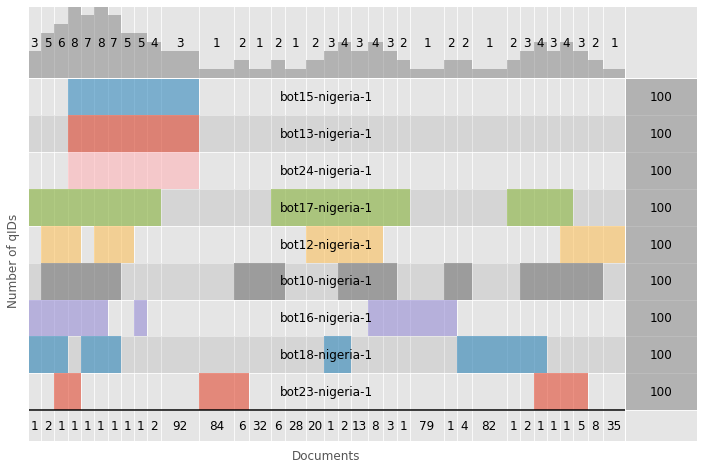

Common documents: set()


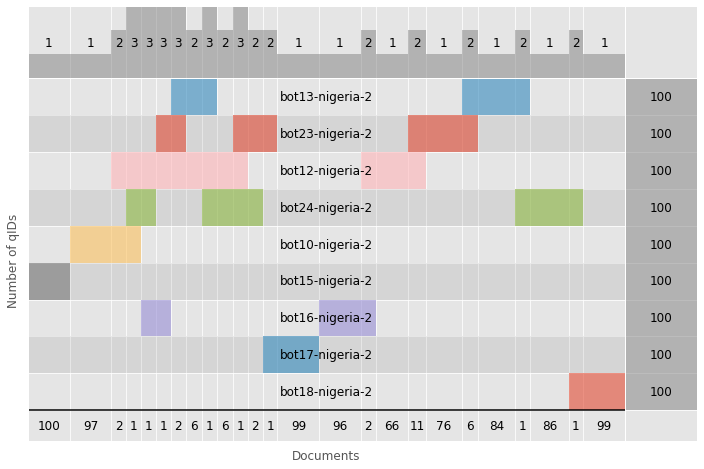

Common documents: set()


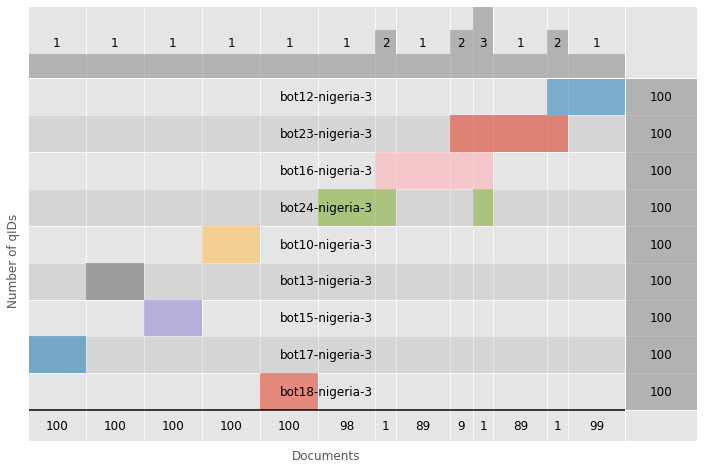

Common documents: set()


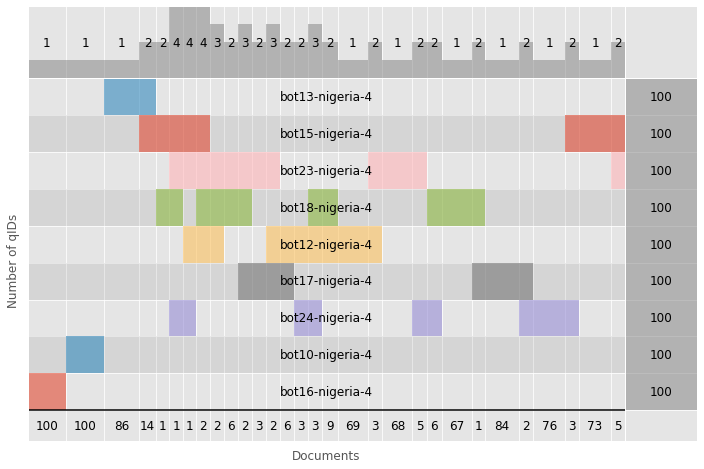

Common documents: set()


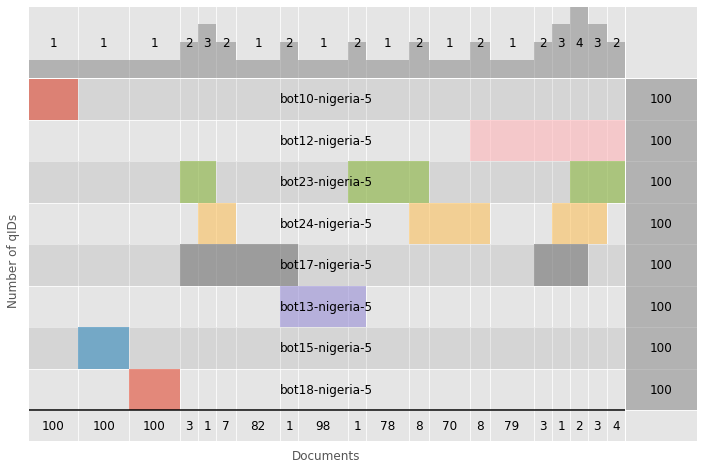

Common documents: set()


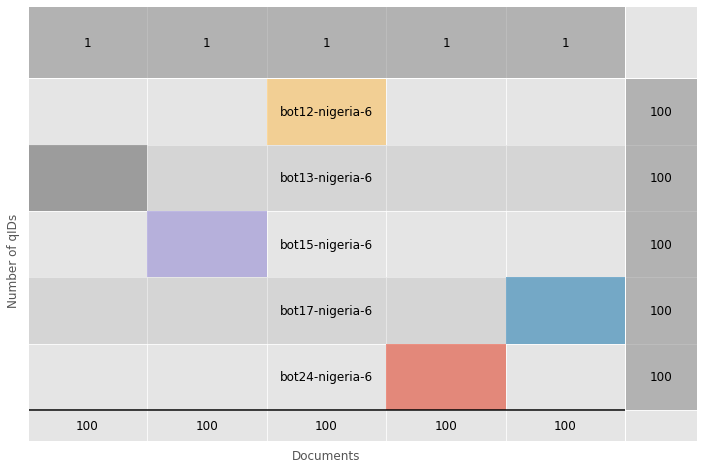

Common documents: set()


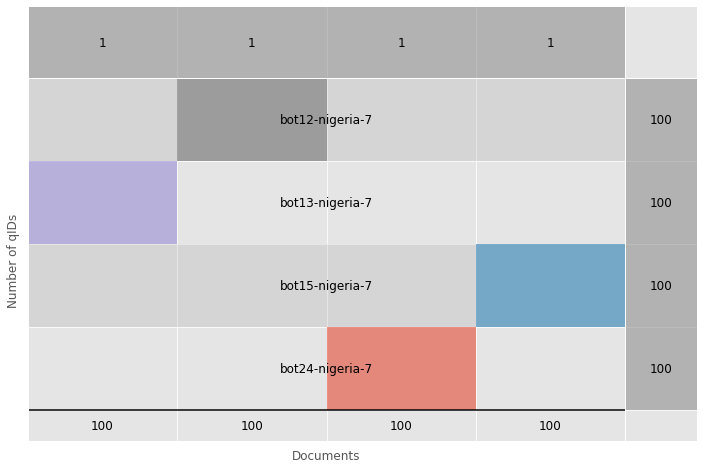

Common documents: set()


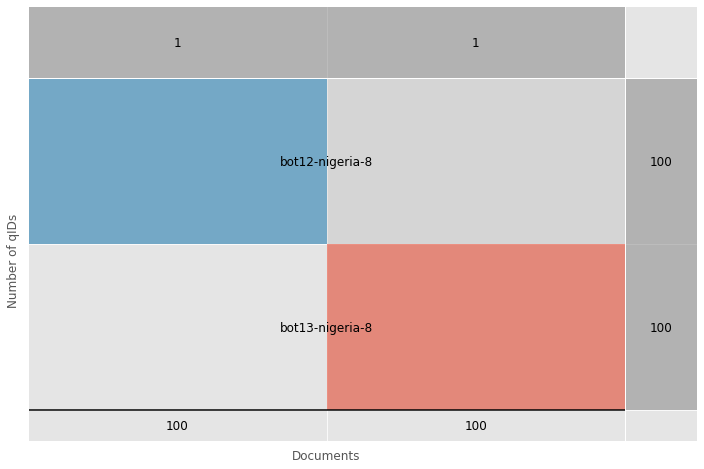

Common documents: set()


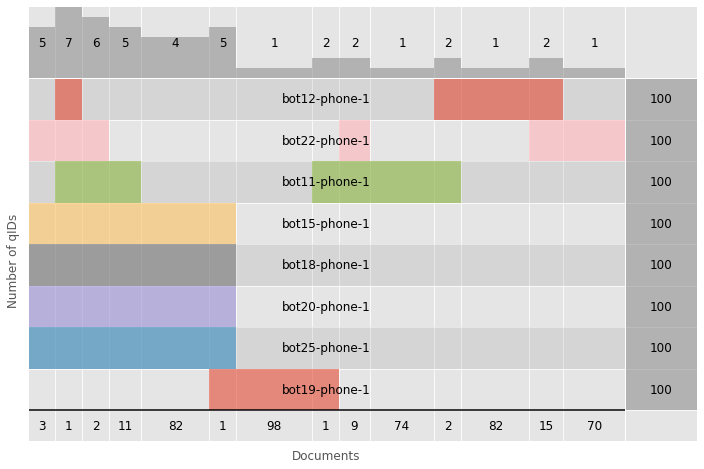

Common documents: set()


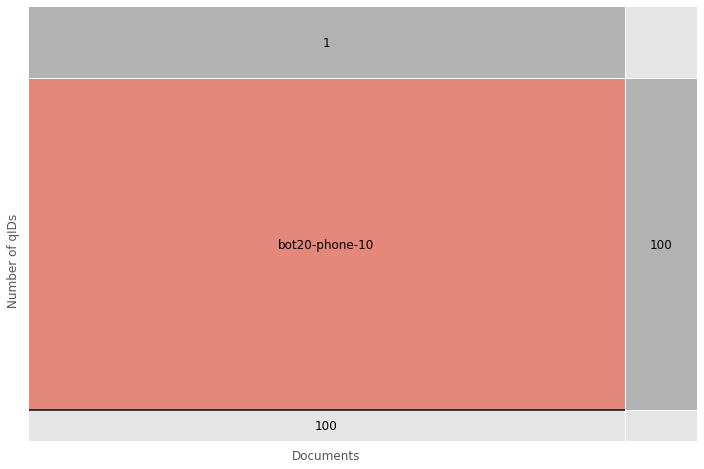

Common documents: {'MARCO_12_1136849134', 'MARCO_59_381265610', 'MARCO_20_700184929', 'MARCO_36_891140639', 'MARCO_31_27345689', 'MARCO_46_8661450', 'MARCO_52_1186797761', 'MARCO_43_841425995', 'MARCO_12_1137504323', 'MARCO_56_817668217', 'MARCO_59_410914593', 'MARCO_13_1760350003', 'MARCO_56_817836999', 'MARCO_43_1549086512', 'MARCO_45_300345561', 'MARCO_48_507480441', 'MARCO_56_307842698', 'MARCO_00_383943932', 'MARCO_39_415976468', 'MARCO_12_1488321513', 'MARCO_25_127047119', 'MARCO_55_838269059', 'MARCO_47_610308194', 'MARCO_22_1283090461', 'MARCO_20_696250341', 'MARCO_22_1284424102', 'MARCO_32_1527108984', 'MARCO_49_1228175555', 'MARCO_20_957014991', 'MARCO_13_1185966670', 'MARCO_36_939912639', 'MARCO_39_420466603', 'MARCO_43_759780335', 'MARCO_55_154046770', 'MARCO_28_179421625', 'MARCO_49_1230345239', 'MARCO_36_849192361', 'MARCO_45_1690338347', 'MARCO_49_804060861', 'MARCO_45_1688245401', 'MARCO_15_614245110', 'MARCO_55_836386866', 'MARCO_38_36224732', 'MARCO_44_805496208', 'MA

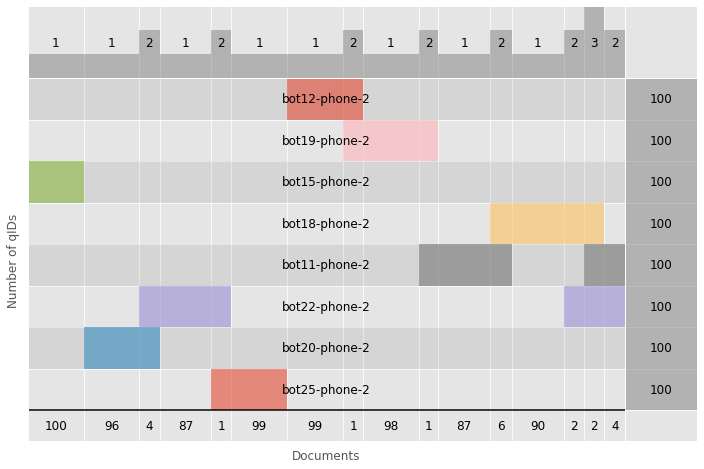

Common documents: set()


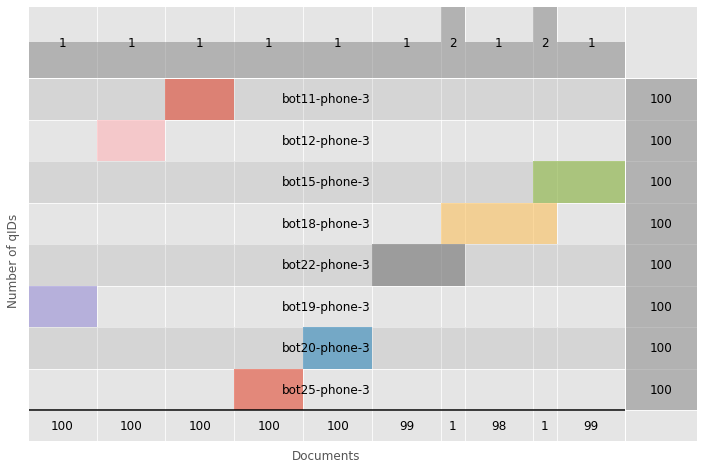

Common documents: set()


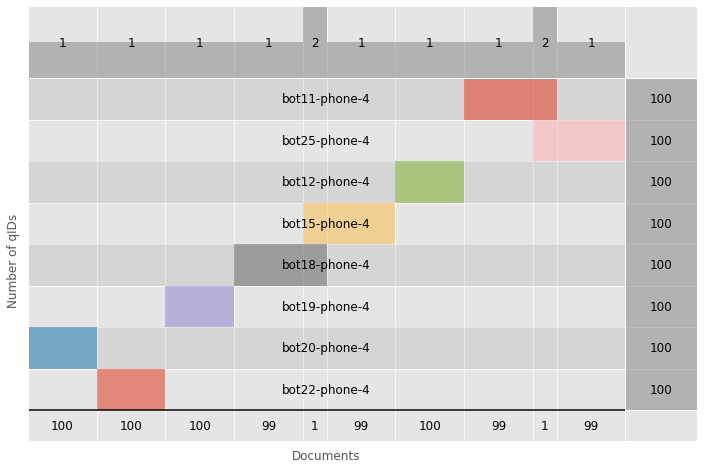

Common documents: set()


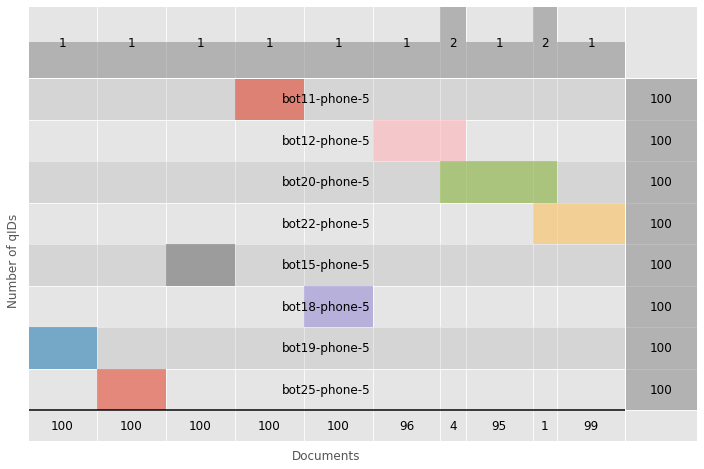

Common documents: set()


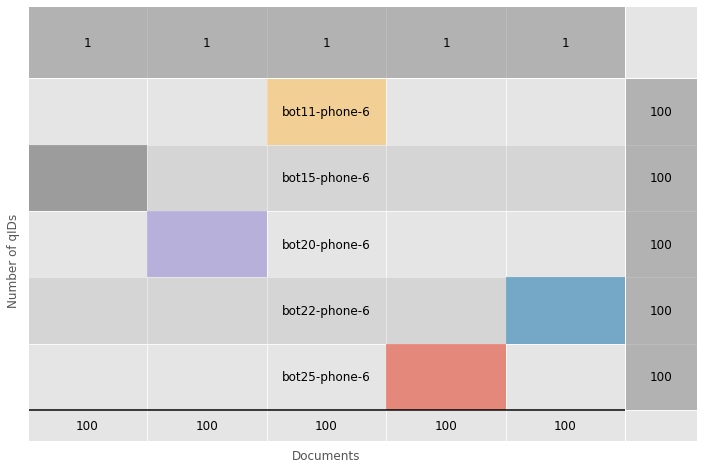

Common documents: set()


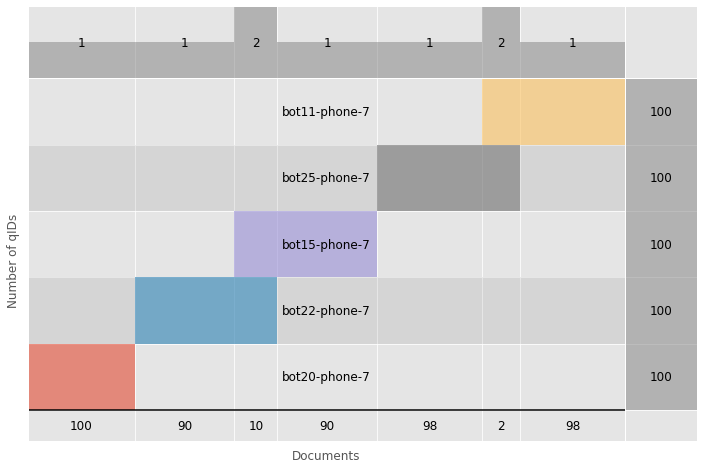

Common documents: set()


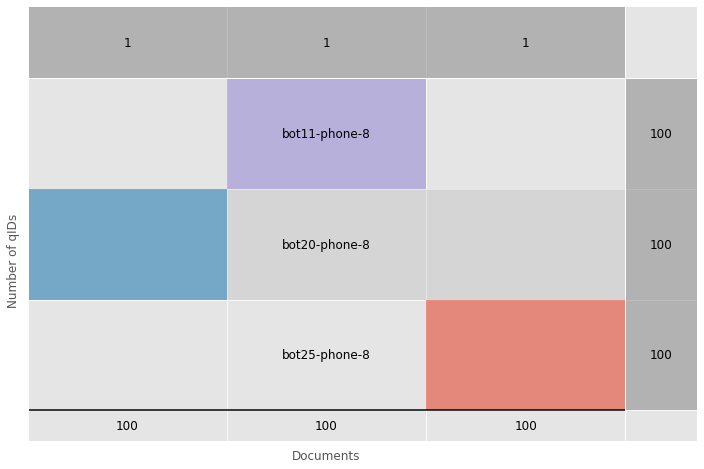

Common documents: set()


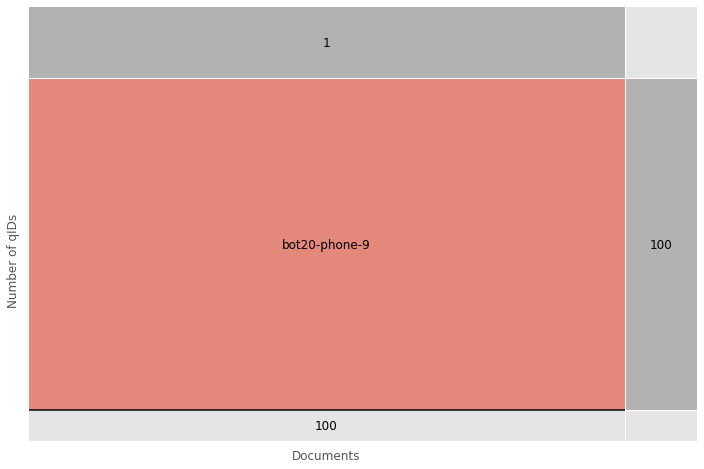

Common documents: {'MARCO_45_1353178840', 'MARCO_33_689791570', 'MARCO_12_575383847', 'MARCO_49_488970263', 'MARCO_53_1311504757', 'MARCO_49_497942795', 'MARCO_53_1452922985', 'MARCO_50_2273545566', 'MARCO_37_816221250', 'MARCO_12_575560389', 'MARCO_48_1592934975', 'MARCO_39_1061457173', 'MARCO_21_1138862858', 'MARCO_12_575425314', 'MARCO_15_1866504160', 'MARCO_49_488726854', 'MARCO_29_347200865', 'MARCO_56_15747164', 'MARCO_41_354051694', 'MARCO_37_599690932', 'MARCO_29_1668039698', 'MARCO_12_575380049', 'MARCO_50_812502872', 'MARCO_00_490594840', 'MARCO_53_1348557311', 'MARCO_31_1408573003', 'MARCO_49_491986816', 'MARCO_48_1283672472', 'MARCO_37_1629595289', 'MARCO_49_661076631', 'MARCO_12_575493012', 'MARCO_43_218206733', 'MARCO_20_452529222', 'MARCO_19_1662634876', 'MARCO_12_575534125', 'MARCO_49_660918757', 'MARCO_13_48405325', 'MARCO_28_1676865946', 'MARCO_47_246597375', 'MARCO_15_309589538', 'MARCO_39_221582035', 'MARCO_52_674791684', 'MARCO_55_988822005', 'MARCO_34_379320560', 

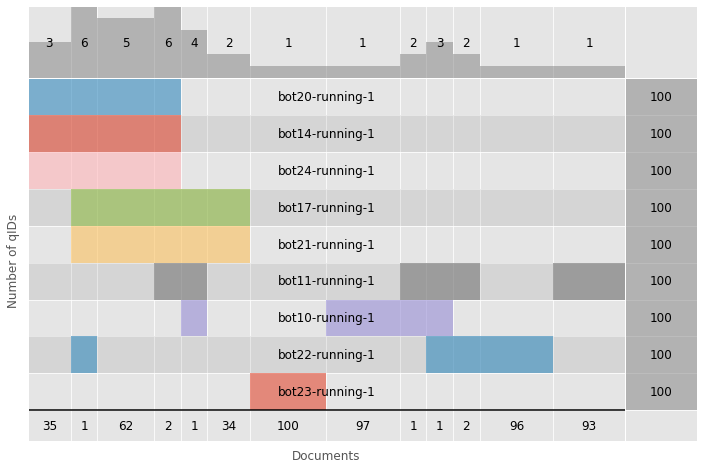

Common documents: set()


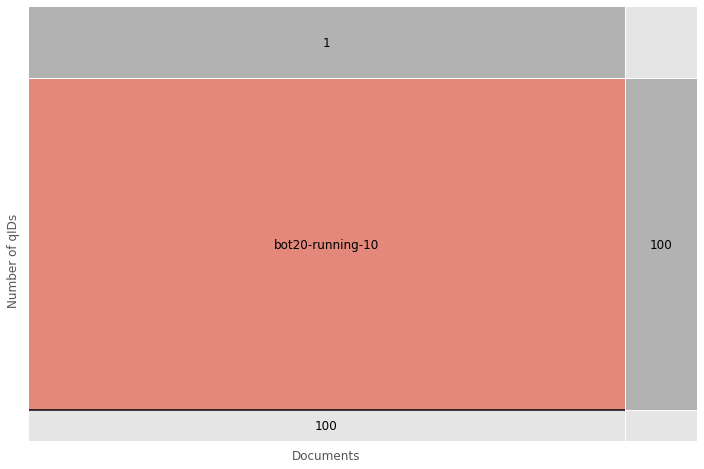

Common documents: {'MARCO_40_1124826299', 'MARCO_31_1573368819', 'MARCO_23_1647271869', 'MARCO_40_1125300583', 'MARCO_58_1627193503', 'MARCO_57_1566062383', 'MARCO_19_1514637543', 'MARCO_24_632466587', 'MARCO_54_334230278', 'MARCO_00_1331535183', 'MARCO_33_586032163', 'MARCO_06_513684390', 'MARCO_39_795580248', 'MARCO_00_652558394', 'MARCO_43_1667014138', 'MARCO_23_545275525', 'MARCO_29_1534274300', 'MARCO_39_785198881', 'MARCO_44_1478436293', 'MARCO_40_1125275698', 'MARCO_15_1459896300', 'MARCO_29_697799736', 'MARCO_40_1124787044', 'MARCO_04_1172683074', 'MARCO_45_879844703', 'MARCO_40_1125082123', 'MARCO_02_982443327', 'MARCO_46_1153214678', 'MARCO_28_1740911902', 'MARCO_06_513952820', 'MARCO_06_513756964', 'MARCO_29_1312243137', 'MARCO_35_1260170881', 'MARCO_40_1125254330', 'MARCO_07_274018775', 'MARCO_07_565321649', 'MARCO_08_92734691', 'MARCO_29_1326554585', 'MARCO_30_235331350', 'MARCO_02_1253457212', 'MARCO_43_1655811613', 'MARCO_40_1125102685', 'MARCO_30_599642299', 'MARCO_06_5

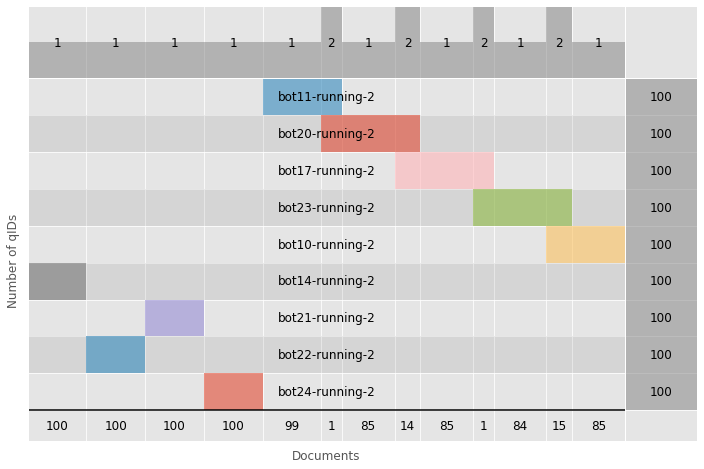

Common documents: set()


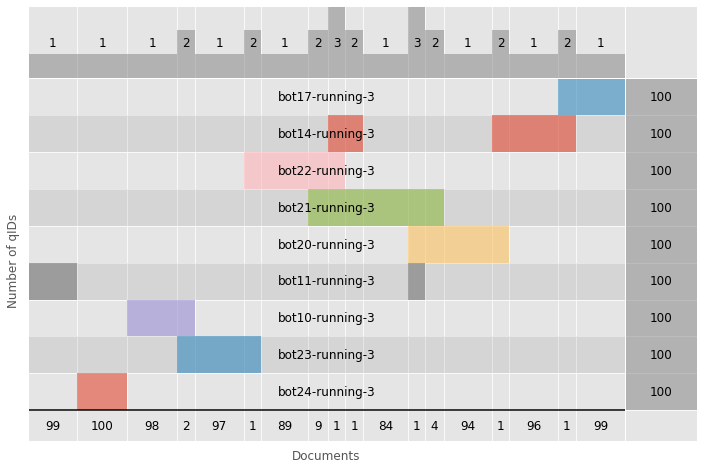

Common documents: set()


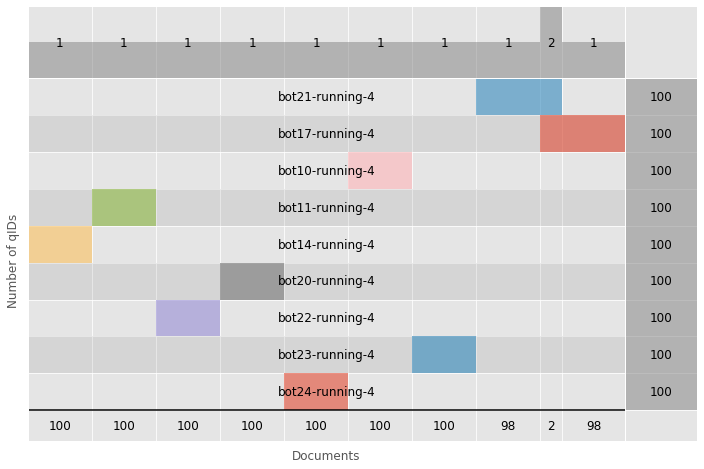

Common documents: set()


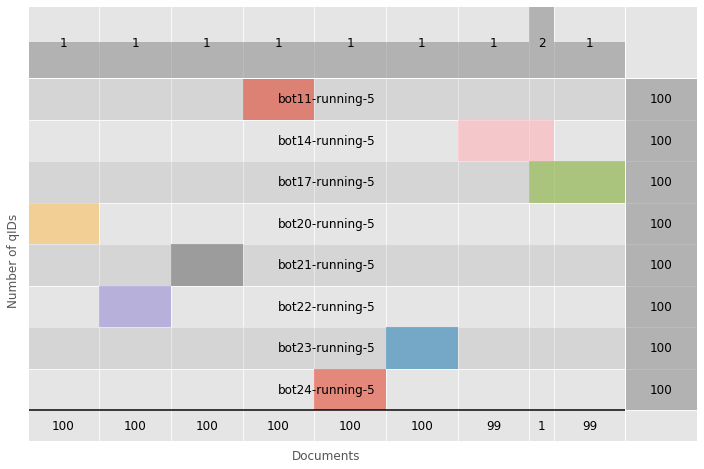

Common documents: set()


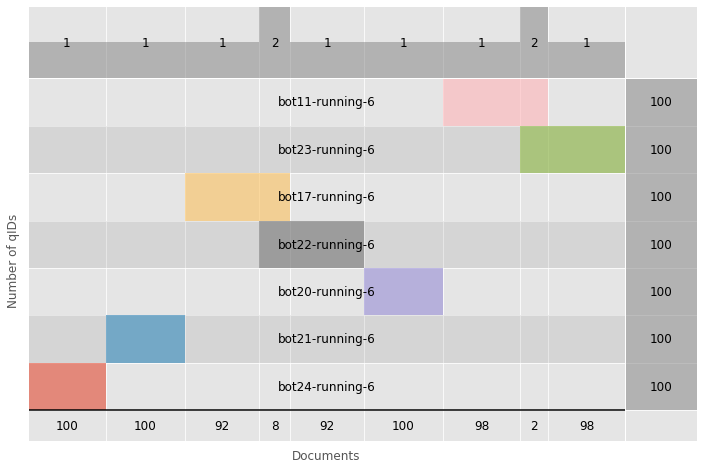

Common documents: set()


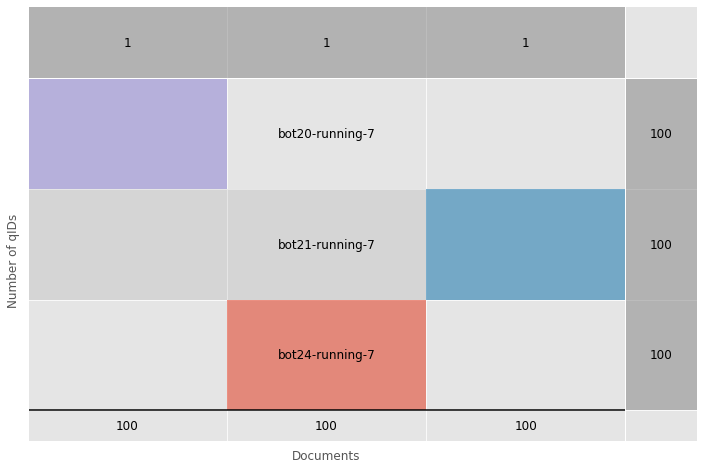

Common documents: set()


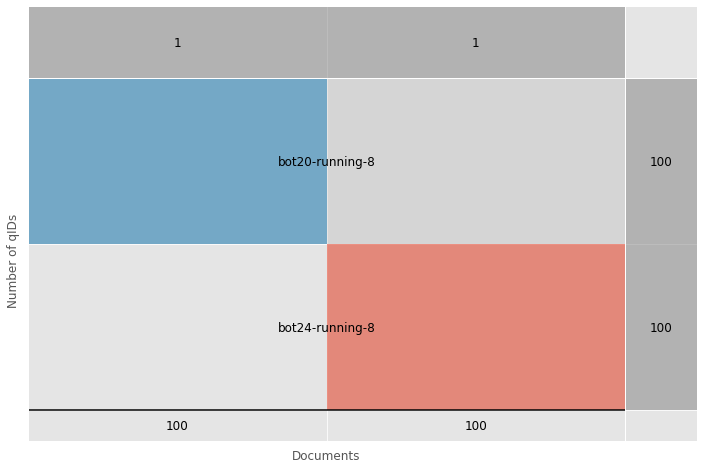

Common documents: set()


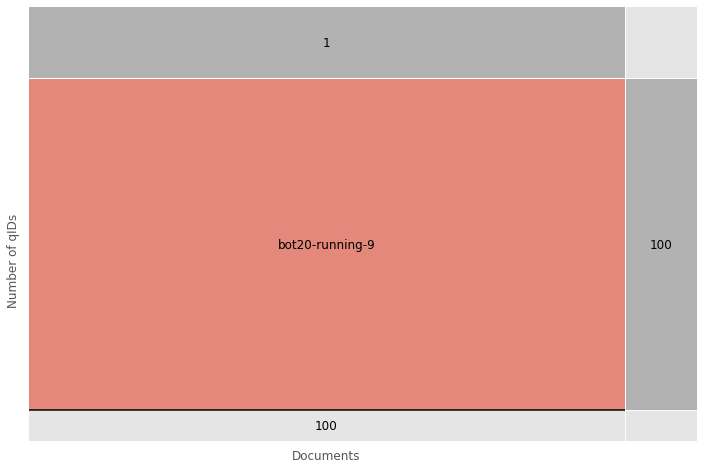

Common documents: {'MARCO_57_588107003', 'MARCO_19_1653148222', 'MARCO_53_169686836', 'MARCO_00_1632476821', 'MARCO_57_247255519', 'MARCO_01_2144428844', 'MARCO_25_327367865', 'MARCO_39_1365733902', 'MARCO_28_965641582', 'MARCO_34_1288016810', 'MARCO_28_584084333', 'MARCO_39_730939380', 'MARCO_52_579425838', 'MARCO_50_1208840265', 'MARCO_13_1356183230', 'MARCO_27_547936089', 'MARCO_09_966613847', 'MARCO_24_440198338', 'MARCO_33_1485170639', 'MARCO_26_292935784', 'MARCO_04_512165797', 'MARCO_21_880095551', 'MARCO_51_972083580', 'MARCO_46_611910591', 'MARCO_51_967447718', 'MARCO_02_1128028107', 'MARCO_14_1211720320', 'MARCO_43_1668225194', 'MARCO_53_1260196792', 'MARCO_45_57017671', 'WAPO_00b8e670-3f0d-11e3-b028-de922d7a3f47', 'MARCO_47_433882089', 'MARCO_23_922711793', 'MARCO_29_1141546957', 'MARCO_34_1306716772', 'MARCO_50_735427786', 'MARCO_23_917270220', 'MARCO_48_377317789', 'MARCO_50_2081041802', 'MARCO_33_1472815037', 'MARCO_24_430647704', 'MARCO_27_194417552', 'MARCO_39_173975104

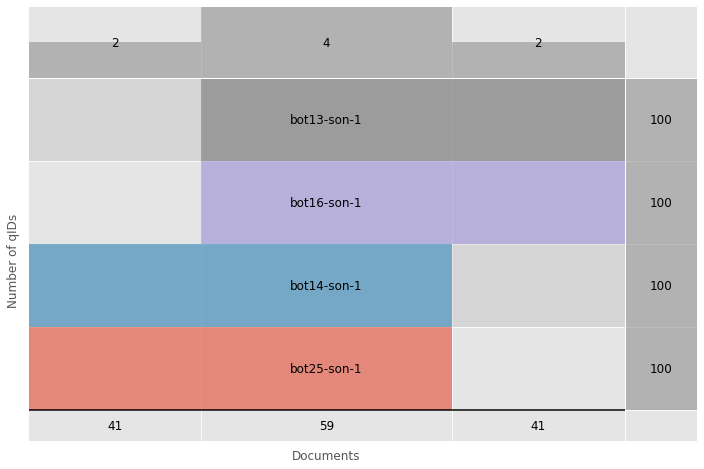

Common documents: {'MARCO_28_629707354', 'MARCO_28_771447759', 'MARCO_57_139128300', 'MARCO_05_1269770019', 'MARCO_45_1527370726', 'MARCO_56_499820806', 'MARCO_47_715203808', 'MARCO_26_746385703', 'MARCO_38_74537490', 'MARCO_47_715185503', 'MARCO_09_541065829', 'WAPO_a41540780cacd6f519d657e5907d1423', 'MARCO_42_1086605493', 'MARCO_15_1949968677', 'MARCO_27_463594838', 'MARCO_31_61784072', 'MARCO_00_1450291313', 'MARCO_03_343307399', 'MARCO_19_1856090515', 'MARCO_30_307890164', 'MARCO_53_630991541', 'MARCO_58_65306486', 'MARCO_42_1015125020', 'MARCO_28_135770096', 'MARCO_50_421768613', 'MARCO_42_1014841049', 'MARCO_24_947151795', 'MARCO_47_715259095', 'MARCO_32_302475065', 'MARCO_58_7030988', 'MARCO_44_1519625347', 'MARCO_41_1783989605', 'MARCO_34_1354426044', 'MARCO_32_652045395', 'MARCO_23_141729552', 'MARCO_42_1015182405', 'MARCO_52_204154925', 'MARCO_28_218644315', 'MARCO_25_1296028169', 'MARCO_47_715174640', 'WAPO_3ca4c840-3803-11e3-ae46-e4248e75c8ea', 'MARCO_45_1515624667', 'MARCO

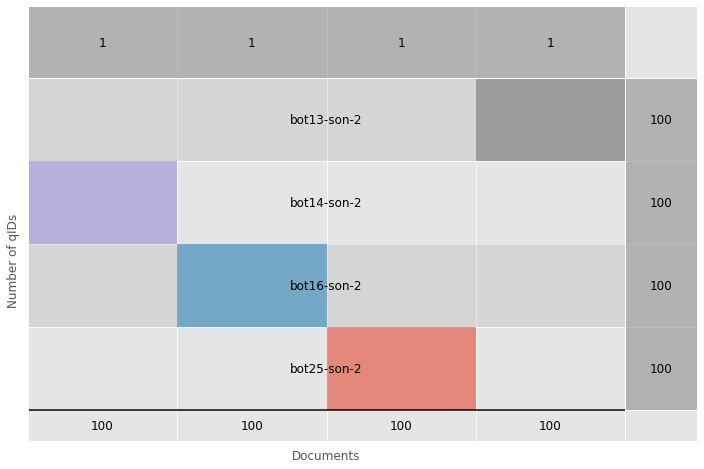

Common documents: set()


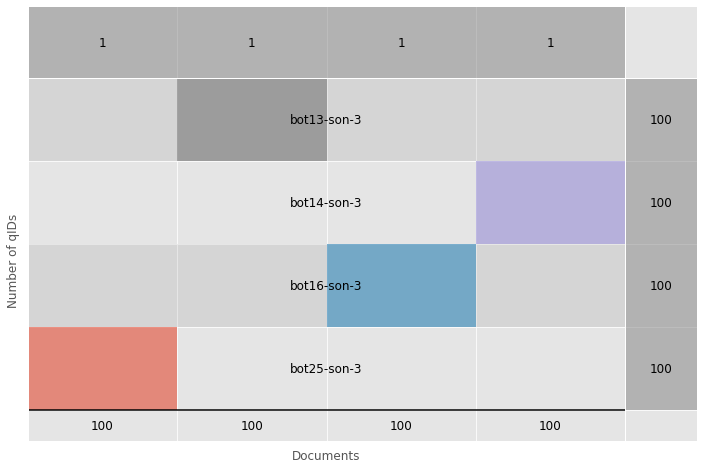

Common documents: set()


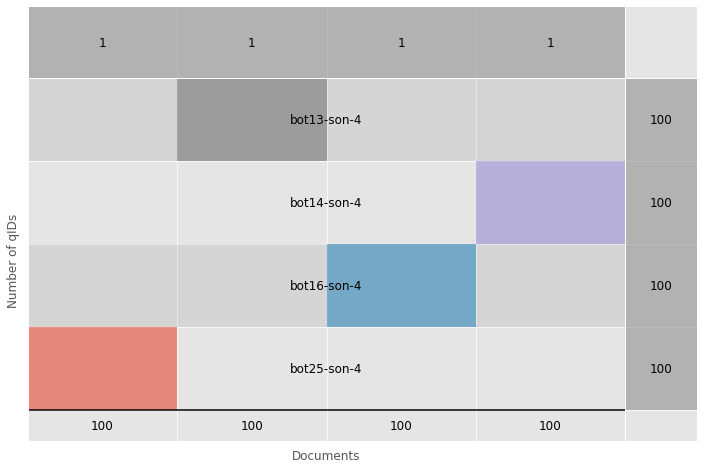

Common documents: set()


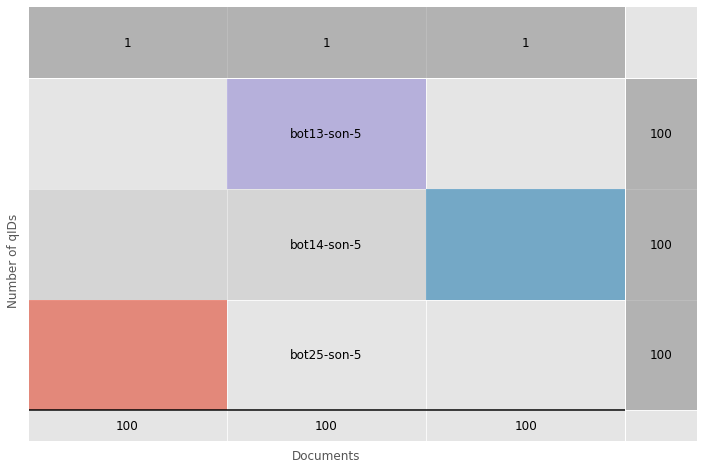

Common documents: set()


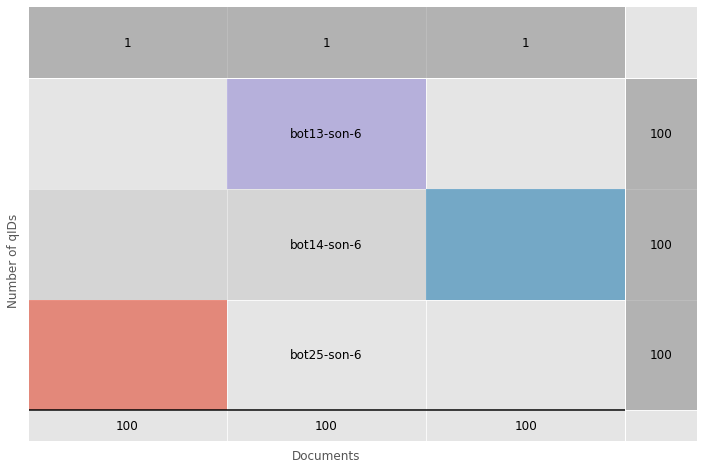

Common documents: set()


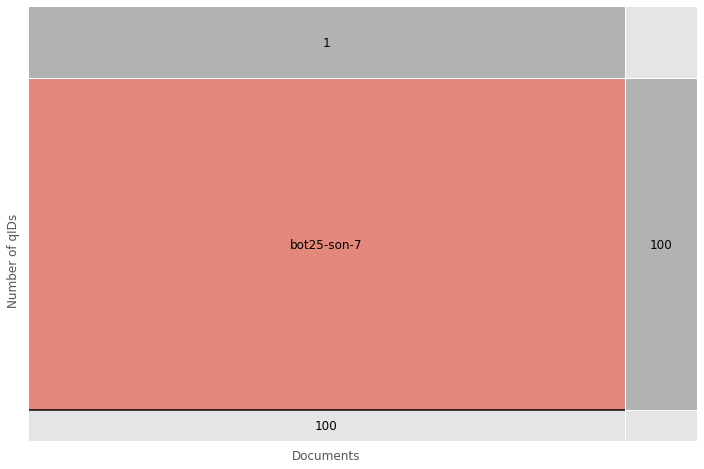

Common documents: {'MARCO_30_816247443', 'KILT_47559547', 'MARCO_06_36888534', 'MARCO_41_430003206', 'MARCO_33_603094986', 'MARCO_04_1208651667', 'MARCO_34_514204980', 'MARCO_49_1100682340', 'MARCO_56_824575956', 'MARCO_38_1701528224', 'MARCO_00_770736373', 'MARCO_45_93684270', 'MARCO_45_527591804', 'MARCO_39_152124893', 'MARCO_12_915038137', 'MARCO_35_984390176', 'MARCO_02_1240182180', 'MARCO_04_211268488', 'MARCO_20_1370968065', 'MARCO_53_632567771', 'MARCO_30_516905549', 'MARCO_57_1274073431', 'MARCO_49_1846018940', 'MARCO_19_1625615481', 'MARCO_33_1476644345', 'KILT_46981896', 'MARCO_45_136338496', 'MARCO_33_1161612138', 'MARCO_08_195233041', 'MARCO_21_641450826', 'MARCO_56_877043387', 'MARCO_00_1544894101', 'MARCO_24_434281798', 'MARCO_56_407085984', 'MARCO_02_1055367375', 'MARCO_24_837627008', 'MARCO_01_1257953536', 'MARCO_31_351016094', 'MARCO_41_430925088', 'MARCO_35_795411120', 'MARCO_50_1372702033', 'MARCO_29_1274052729', 'MARCO_24_1755324001', 'MARCO_02_705019342', 'MARCO_00

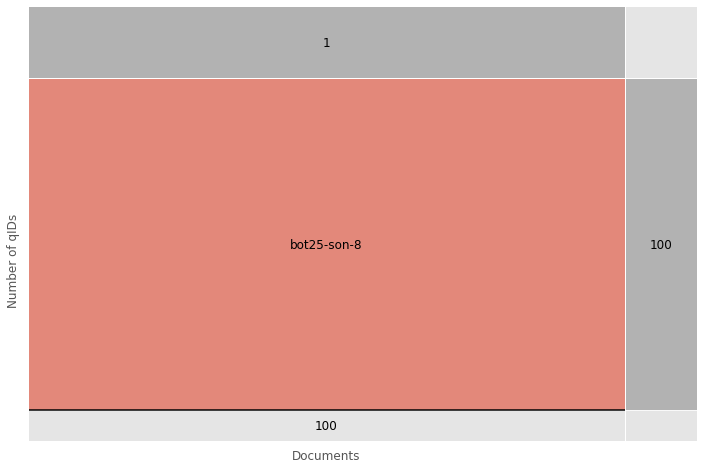

Common documents: {'MARCO_25_1408097463', 'MARCO_52_1236751220', 'MARCO_13_399052139', 'MARCO_46_378420943', 'MARCO_11_1090576755', 'MARCO_41_699928841', 'MARCO_39_925292202', 'MARCO_31_1404694260', 'MARCO_25_1844081788', 'MARCO_12_1929312852', 'MARCO_16_1127269159', 'MARCO_33_1431308950', 'MARCO_44_583248671', 'MARCO_33_1431444395', 'MARCO_44_236087611', 'MARCO_24_1116199241', 'MARCO_31_1394190336', 'MARCO_12_667113561', 'MARCO_19_1936360620', 'MARCO_50_285880159', 'MARCO_25_1831538248', 'MARCO_54_401553158', 'MARCO_34_510425064', 'MARCO_36_298904290', 'MARCO_59_823201666', 'MARCO_55_172685099', 'MARCO_46_372739443', 'MARCO_11_232903471', 'MARCO_09_223229545', 'MARCO_37_192528847', 'MARCO_58_833743777', 'MARCO_43_1675337715', 'MARCO_25_1165971007', 'MARCO_15_191841666', 'MARCO_59_535716852', 'MARCO_31_1298540680', 'MARCO_04_906076385', 'MARCO_25_1158147177', 'MARCO_13_1494396767', 'MARCO_55_535706047', 'MARCO_23_48275377', 'MARCO_14_1049608054', 'MARCO_24_1258860766', 'MARCO_54_354830

In [302]:
import pandas as pd
from supervenn import supervenn
from matplotlib import pyplot as plt


# Group the dataframe by the qID characters from the 7th position onwards
grouped = doc_lists_df.groupby(doc_lists_df["qID"].str[6:])

# Loop through each group and generate a supervenn diagram for that group
for name, group in grouped:
    # Create a list of sets and labels for this group
    doc_sets = [set(docs[:100]) for docs in group["docList"].tolist()]  ### choose here the number of doc
    labels = [qid for qid in group["qID"].tolist()]

    # Find the common documents between the sets and their positions within each list
    common_docs = set.intersection(*doc_sets)
    common_doc_positions = {}
    for doc in common_docs:
        common_doc_positions[doc] = [i for i, docs in enumerate(group["docList"].tolist()) if doc in docs]

    # Generate the supervenn diagram and plot it
    fig, ax = plt.subplots()
    supervenn(doc_sets, labels, side_plots=True, widths_minmax_ratio=0.35, sets_ordering='minimize gaps' ,ax=ax)
    plt.title(f"Overlap between {len(doc_sets)} qIDs starting with '{name}'")
    plt.xlabel("Documents")
    plt.ylabel("Number of qIDs")
    plt.show()

    # Print the common documents and their positions within each list
    print(f"Common documents: {common_docs}")
    for doc, positions in common_doc_positions.items():
        print(f"Positions for document {doc}: {positions}")
